## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


In [ ]:
# !pip install optuna

Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle

from scipy import stats
from scipy.stats import normaltest

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import median_absolute_error

import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Прочитаем наш файл с исходными данными:

In [ ]:
file_path = '/content/drive/MyDrive/ProjectPracticum2/train.csv'
taxi_data = pd.read_csv(file_path)
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определите временные рамки (без учета времени), за которые представлены данные.

In [ ]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_datetime'].describe()

count                          1458644
mean     2016-04-01 10:10:24.940037120
min                2016-01-01 00:00:17
25%      2016-02-17 16:46:04.249999872
50%                2016-04-01 17:19:40
75%      2016-05-15 03:56:08.750000128
max                2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

Временные рамки данных: с 2016-01-01 по 2016-06-30

### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [ ]:
total_missing = taxi_data.isnull().sum().sum()
total_missing

0

Пропуски в данных отсутствуют.

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [ ]:
print(f"Всего {taxi_data['vendor_id'].nunique()} уникальных таксопарка.")
print(f"Максимальное количество пассажиров составляет {taxi_data['passenger_count'].max()} человек.")
print(f"Средняя длительность поездки равна {round(taxi_data['trip_duration'].mean())} секунд." )
print(f"Медианная длительность поездки равна {round(taxi_data['trip_duration'].median())} секунд.")
print(f"Минимальное время поездки составляет {taxi_data['trip_duration'].min()} секунд.")
print(f"Максимальное время поездки составяляет {taxi_data['trip_duration'].max()} секунд.")

Всего 2 уникальных таксопарка.
Максимальное количество пассажиров составляет 9 человек.
Средняя длительность поездки равна 959 секунд.
Медианная длительность поездки равна 662 секунд.
Минимальное время поездки составляет 1 секунд.
Максимальное время поездки составяляет 3526282 секунд.


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [ ]:
def add_datetime_features(DataFrame):
    """
    Добавляет признаки даты и времени к DataFrame.
    Аргументы:
    DataFrame : pandas.DataFrame
        Исходный DataFrame, к которому добавляются признаки даты и времени.
    Возвращает:
    pandas.DataFrame
        DataFrame с добавленными признаками даты и времени.
    """
    DataFrame['pickup_datetime'] = pd.to_datetime(DataFrame['pickup_datetime'])
    DataFrame['pickup_date'] = pd.to_datetime(DataFrame['pickup_datetime']).dt.date
    DataFrame['pickup_hour'] = pd.to_datetime(DataFrame['pickup_datetime']).dt.hour
    DataFrame['pickup_day_of_week'] = pd.to_datetime(DataFrame['pickup_datetime']).dt.dayofweek
    return DataFrame

In [ ]:
taxi_data = add_datetime_features(taxi_data)
trips_on_saturday = taxi_data[taxi_data['pickup_day_of_week'] == 5].shape[0]
average_trips_per_day = round(taxi_data.groupby(taxi_data['pickup_date']).size().mean())
print(f"В субботу было совершено {trips_on_saturday} поездок.")
print(f"В среднем в день совершается {average_trips_per_day} поездок.")

В субботу было совершено 220868 поездок.
В среднем в день совершается 8015 поездок.


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [ ]:
def add_holiday_features(trips_data, holiday_data):
    """
    Добавляет признак праздника к набору данных о поездках.
    Аргументы:
    trips_data : pandas.DataFrame
        Набор данных о поездках, к которому добавляется признак праздника.
    holiday_data : pandas.DataFrame
        Набор данных о праздниках, содержащий информацию о датах праздников.
    Возвращает:
    pandas.DataFrame
        Набор данных о поездках с добавленным признаком праздника.
    """
    holiday_dates = holiday_data['date'].values

    def is_holiday(pickup_date):
        return 1 if pickup_date in holiday_dates else 0

    trips_data['pickup_holiday'] = trips_data['pickup_date'].map(is_holiday)
    return trips_data

In [ ]:
holiday_data = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/holiday_data.csv', sep=';')
taxi_data['pickup_date'] = pd.to_datetime(taxi_data['pickup_date'])
holiday_data['date'] = pd.to_datetime(holiday_data['date'])
taxi_data = add_holiday_features(taxi_data, holiday_data)
holiday_trips = taxi_data[taxi_data['pickup_holiday'] == 1]
median_trip_duration_seconds = round(holiday_trips['trip_duration'].median())

print(f"Медианная длительность поездки на такси в праздничные дни составляет {median_trip_duration_seconds} секунд")

Медианная длительность поездки на такси в праздничные дни составляет 585 секунд


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [ ]:
def add_osrm_features(trips, osrm):
    """
    Добавляет признаки, полученные из OSRM, к набору данных о поездках.
    Аргументы:
    trips : pandas.DataFrame
        Набор данных о поездках, к которому добавляются признаки из OSRM.
    osrm : pandas.DataFrame
        Набор данных, содержащий признаки, полученные из OSRM, такие как 'id', 'total_distance', 'total_travel_time', 'number_of_steps'.
    Возвращает:
    pandas.DataFrame
        Набор данных о поездках с добавленными признаками из OSRM.
    Пример использования:
    >>> trips = add_osrm_features(trips, osrm)
    """
    osrm_features = osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    trips = trips.merge(osrm_features, on='id', how='left')
    return trips

In [ ]:
osrm_data = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/osrm_data_train.csv')
taxi_data = add_osrm_features(taxi_data, osrm_data)
dif_med_duration = round(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median())
print(f"Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM, составляет {dif_med_duration}.")

Разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM, составляет 372.


In [ ]:
# Количество пропусков
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [ ]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [ ]:
def add_geographical_features(data):
    """
    Добавляет географические признаки к набору данных:
        - haversine_distance: расстояние, рассчитанное с использованием формулы Хаверсина,
            между точками с координатами места взятия и места высадки.
        - direction: направление посадки и высадки, рассчитанное на основе угла между
             координатами места взятия и места высадки.
    Аргументы:
    data : pandas.DataFrame
        Набор данных, к которому добавляются географические признаки.
    Возвращает:
    pandas.DataFrame
        Набор данных с добавленными географическими признаками.
    """
    lat1 = data['pickup_latitude']
    lng1 = data['pickup_longitude']
    lat2 = data['dropoff_latitude']
    lng2 = data['dropoff_longitude']
    data['haversine_distance'] = get_haversine_distance(lat1, lng1, lat2, lng2)
    data['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)
    return data

In [ ]:
taxi_data = add_geographical_features(taxi_data)
harvesine_median = round(taxi_data['haversine_distance'].median(), 2)
print(f"Медианное расстояние Хаверсина поездок составляет {harvesine_median} км.")

Медианное расстояние Хаверсина поездок составляет 2.09 км.


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [ ]:
def add_cluster_features(data, model_knn):
    """
    Добавляет пространственные кластерные признаки к набору данных:
        - 'pickup_latitude': широта места посадки
        - 'pickup_longitude': долгота места посадки
        - 'dropoff_latitude': широта места высадки
        - 'dropoff_longitude': долгота места высадки
    Аргументы:
    data : pandas.DataFrame
        Набор данных, к которому добавляются пространственные кластерные признаки.
    model_knn : обученная модель KNN
        Модель k-ближайших соседей, используемая для предсказания кластеров.
    Возвращает:
    pandas.DataFrame
        Набор данных с добавленными пространственными кластерными признаками.
    """
    data['geo_cluster'] = model_knn.predict(data[['pickup_latitude',
                                                'pickup_longitude',
                                                'dropoff_latitude',
                                                'dropoff_longitude']])
    return data

In [ ]:
# Создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# Обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)
data = add_cluster_features(taxi_data, kmeans)
taxi_data['geo_cluster'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


geo_cluster
0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: count, dtype: int64

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [ ]:
def add_weather_features(trips_data, weather):
    """
    Добавляет метеорологические признаки в данные о поездках на основе предоставленных метеоданных:
        temperature - температура;
        visibility - видимость;
        wind speed - средняя скорость ветра;
        precip - количество осадков;
        events - погодные явления.
    Аргументы:
    - trips_data (pandas.DataFrame): Данные о поездках, содержащие столбцы pickup_date и pickup_hour.
    - weather (pandas.DataFrame): Метеоданные, содержащие столбцы date, hour, temperature, visibility, wind speed, precip и events.
    Возвращает:
    - pandas.DataFrame: Объединенные данные, содержащие исходные данные о поездках с добавленными метеорологическими признаками.
    """
    weather['time'] = pd.to_datetime(weather['time'])
    weather['date'] = weather['time'].dt.date
    weather['hour'] = weather['time'].dt.hour
    weather['date'] = pd.to_datetime(weather['date'])
    weather = weather[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
    merged_data = pd.merge(trips_data, weather, left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'], how='left')
    merged_data = merged_data.drop(['date', 'hour'], axis=1)
    return merged_data

In [ ]:
weather_data = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/weather_data.csv')
taxi_data = add_weather_features(taxi_data, weather_data)
snowy_days = taxi_data[taxi_data['events'] == 'Snow'].shape[0]
missing_percentage = round((taxi_data['temperature'].isnull().sum() / len(taxi_data['events'])) * 100, 2)

print(f"Количество поездок в снежную погоду составляет {snowy_days}." )
print(f"Пропуски в столбцах с погодными условиями занимают {missing_percentage}%.")

Количество поездок в снежную погоду составляет 13126.
Пропуски в столбцах с погодными условиями занимают 0.82%.


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [ ]:
def fill_null_weather_data(trips_data):
    """
    Заполняет пропуски в столбцах с погодными условиями -
    temperature, visibility, wind speed, precip медианным значением
    температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки.
    Аргументы:
    - trips_data (pandas.DataFrame): Данные о поездках.
    Возвращает:
    - pandas.DataFrame: Обновленные данные о поездках с заполненными пропущенными значениями метеоданных.
    """
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    trips_data[weather_columns] = trips_data.groupby('pickup_date')[weather_columns].transform(lambda x: x.fillna(x.median()))
    trips_data['events'].fillna('None', inplace=True)
    osrm_columns = ['total_distance', 'total_travel_time', 'number_of_steps']
    trips_data[osrm_columns] = trips_data[osrm_columns].fillna(trips_data[osrm_columns].median())
    return trips_data

In [ ]:
taxi_data2 = fill_null_weather_data(taxi_data)
median_temperature = round(taxi_data2['temperature'].median(), 1)

print(f"Медиана в столбце temperature после заполнения пропусков составляет {median_temperature}.")

Медиана в столбце temperature после заполнения пропусков составляет 11.1.


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


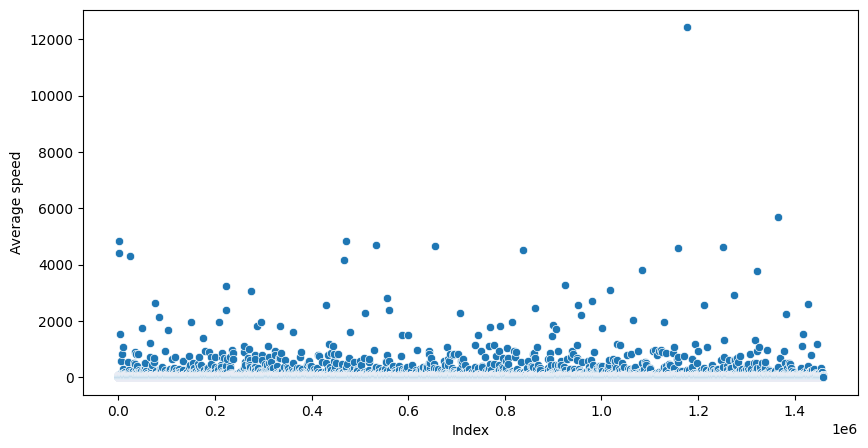

In [ ]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

б) Сколько выбросов по признаку скорости вам удалось найти?

In [ ]:
outliers_trip_duration = taxi_data[taxi_data['trip_duration'] > 24*60*60]
taxi_data = taxi_data[taxi_data['trip_duration'] <= 24*60*60].copy()

print(f"Выбросы по признаку длительности поездки составляют {outliers_trip_duration.shape[0]}.")

taxi_data.loc[:, 'avr_speed'] = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
outliers_speed = taxi_data[taxi_data['avr_speed'] > 300]
taxi_data = taxi_data[taxi_data['avr_speed'] <= 300].copy()
taxi_data = taxi_data.drop(columns=['avr_speed'], axis=1)

print(f"Выбросы по признаку скорости составляют {outliers_speed.shape[0]}.")

Выбросы по признаку длительности поездки составляют 4.
Выбросы по признаку скорости составляют 407.


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [ ]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

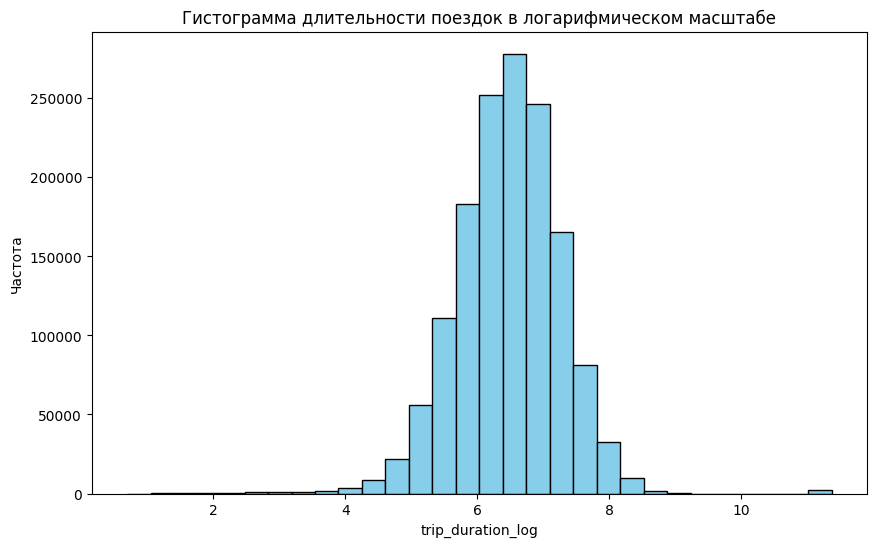

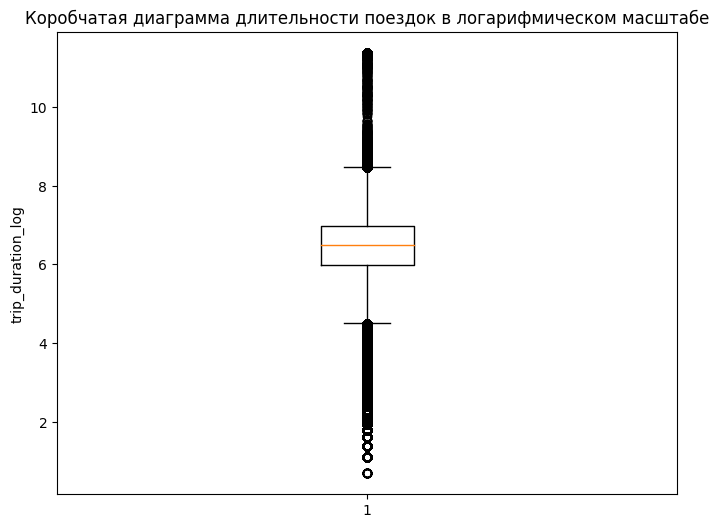

In [ ]:
# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.hist(taxi_data['trip_duration_log'], bins=30, color='skyblue', edgecolor='black')
plt.title('Гистограмма длительности поездок в логарифмическом масштабе')
plt.xlabel('trip_duration_log')
plt.ylabel('Частота')
plt.show()

# Построение коробчатой диаграммы
plt.figure(figsize=(8, 6))
plt.boxplot(taxi_data['trip_duration_log'])
plt.title('Коробчатая диаграмма длительности поездок в логарифмическом масштабе')
plt.ylabel('trip_duration_log')
plt.show()



Исходя из визуализации, можно сделать предположение, что полученное распределение является нормальным.

In [ ]:
# Проведение теста Д’Агостино
stat, p = normaltest(taxi_data['trip_duration_log'])
alpha = 0.05
print("p-значение:", p)
if p < alpha:
    print("Распределение не является нормальным")
else:
    print("Распределение является нормальным")


p-значение: 0.0
Распределение не является нормальным


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

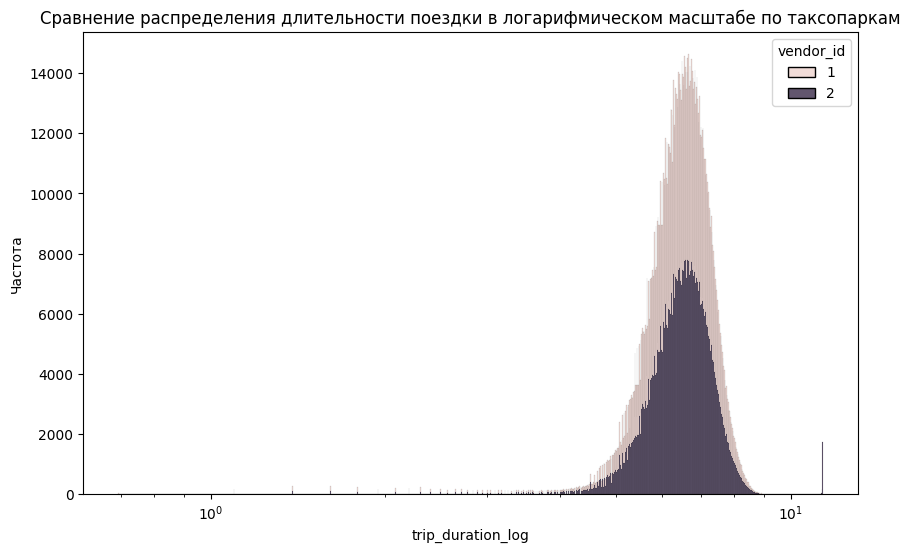

In [ ]:
# Построение гистограммы распределения длительности поездки в логарифмическом масштабе по таксопаркам
plt.figure(figsize=(10, 6))
sns.histplot(data=taxi_data, x='trip_duration_log', hue='vendor_id', multiple="stack", log_scale=True)
plt.title('Сравнение распределения длительности поездки в логарифмическом масштабе по таксопаркам')
plt.xlabel('trip_duration_log')
plt.ylabel('Частота')
plt.show()

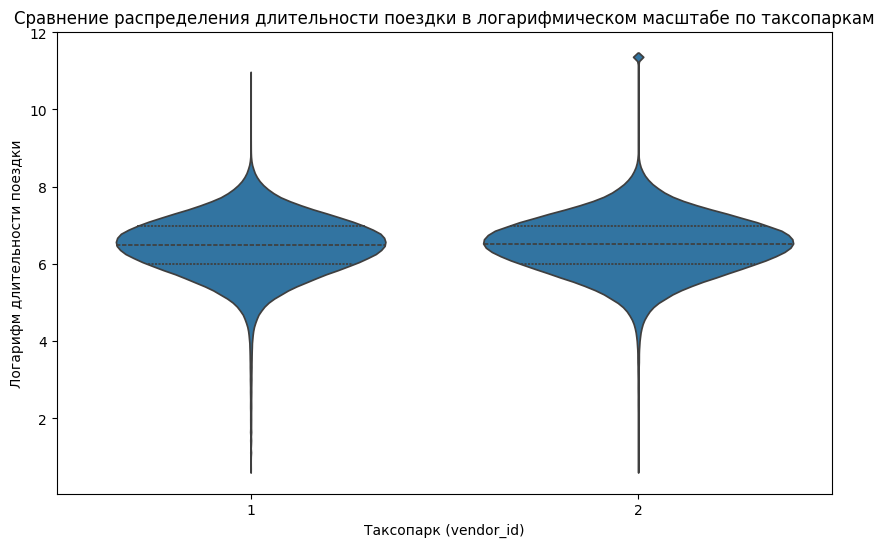

In [ ]:
# Построение скрипичной диаграммы распределения длительности поездки в логарифмическом масштабе по таксопаркам
plt.figure(figsize=(10, 6))
sns.violinplot(data=taxi_data, x='vendor_id', y='trip_duration_log', density_norm='count', inner='quartile')
plt.title('Сравнение распределения длительности поездки в логарифмическом масштабе по таксопаркам')
plt.xlabel('Таксопарк (vendor_id)')
plt.ylabel('Логарифм длительности поездки')
plt.show()

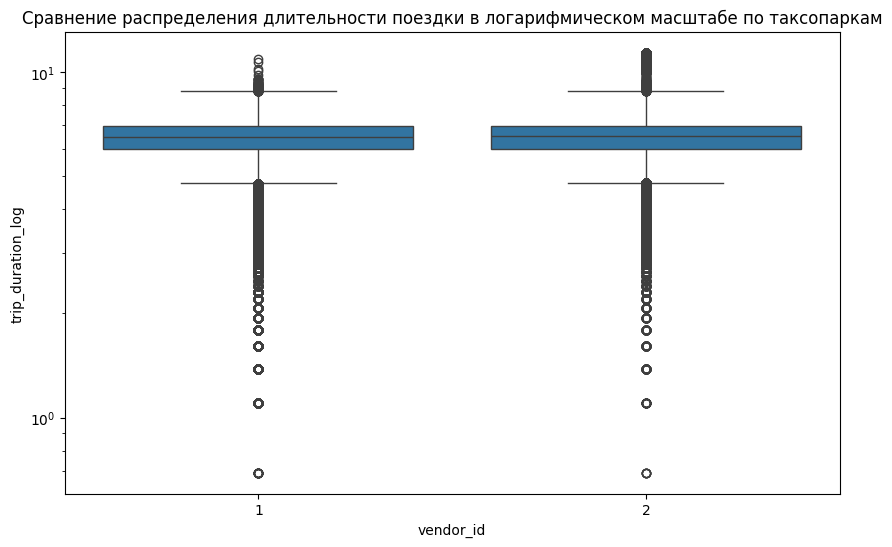

In [ ]:
# Построение ящика с усами распределения длительности поездки в логарифмическом масштабе по таксопаркам
plt.figure(figsize=(10, 6))
sns.boxplot(data=taxi_data, x='vendor_id', y='trip_duration_log', log_scale=True)
plt.title('Сравнение распределения длительности поездки в логарифмическом масштабе по таксопаркам')
plt.xlabel('vendor_id')
plt.ylabel('trip_duration_log')
plt.show()

Распределения в группах практически не отличаются, это может указывать на то, что признак vendor_id не имеет большого значения для определения длительности поездки.
Однако, окончательные выводы можно будет сделать на основе дополнительного анализа данных.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

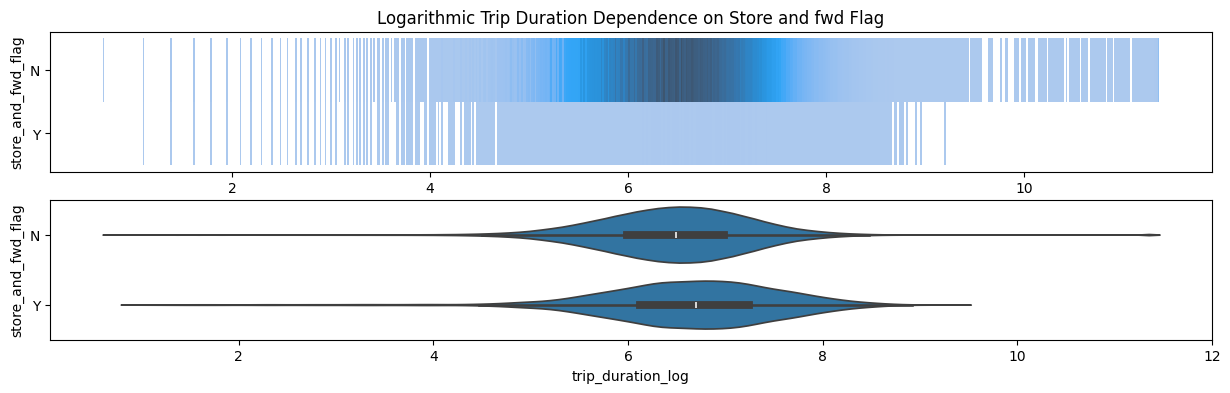

In [ ]:
# Построение скрипичной диаграммы распределения длительности поездки в логарифмическом масштабе
# в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag)
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 4))

histplot = sns.histplot(
    data = taxi_data,
    x = 'trip_duration_log',
    y = 'store_and_fwd_flag',
    ax = axes[0]
)
histplot.set_title('Logarithmic Trip Duration Dependence on Store and fwd Flag')
violinplot = sns.violinplot(
    data = taxi_data,
    x = 'trip_duration_log',
    y = 'store_and_fwd_flag',
    ax = axes[1]
);

In [ ]:
taxi_data['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    1450192
Y       8041
Name: count, dtype: int64

* Распределения в группах значительно отличаются, это может указывать на то, что признак отправки сообщения (store_and_fwd_flag) имеет значение для определения длительности поездки.


* Самые продолжительные поездки относятся к категории N.





### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

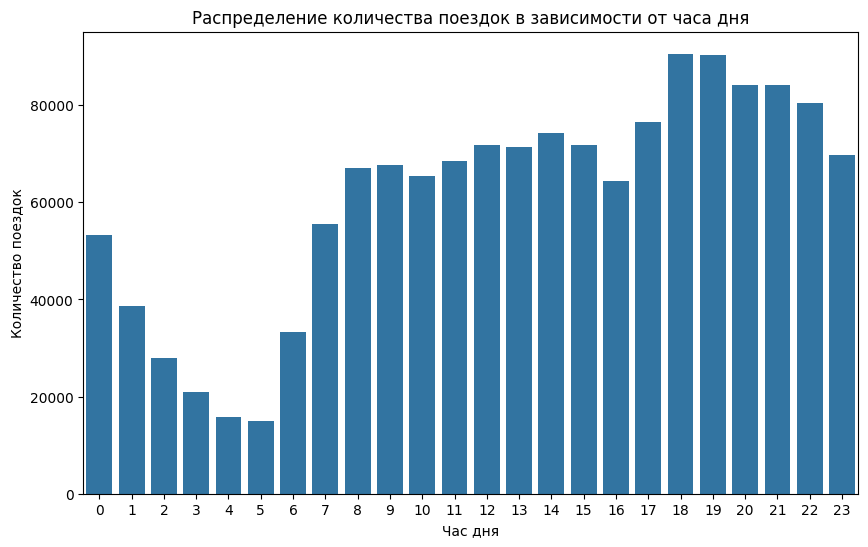

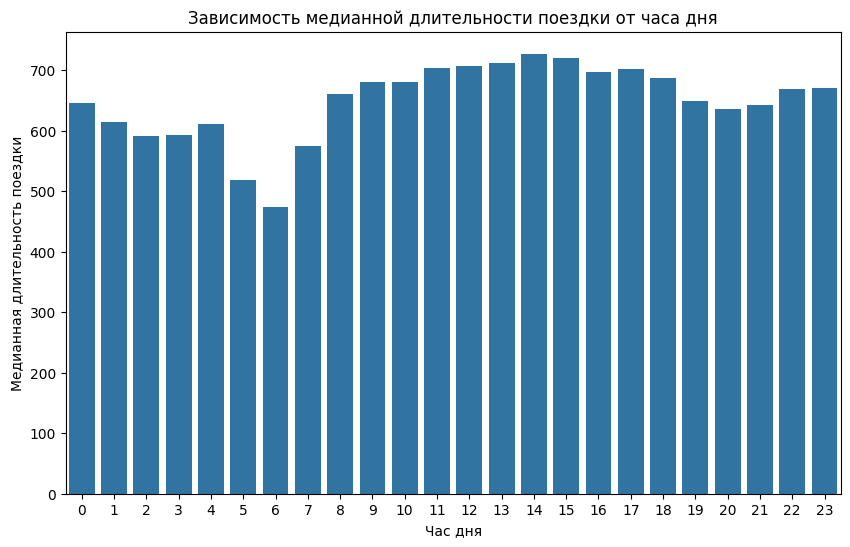

In [ ]:
# Построение распределения количества поездок в зависимости от часа дня
plt.figure(figsize=(10, 6))
sns.countplot(data=taxi_data, x='pickup_hour')
plt.title('Распределение количества поездок в зависимости от часа дня')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.show()

# Вычисление медианной длительности поездок
trip_duration_median = taxi_data.groupby('pickup_hour')['trip_duration'].median()

# Заполнение столбца с медианными значениями
taxi_data_med = taxi_data['pickup_hour'].to_frame()
taxi_data_med['trip_duration_median'] = taxi_data['pickup_hour'].map(trip_duration_median)

# Построение зависимости медианной длительности поездки от часа дня
plt.figure(figsize=(10, 6))
sns.barplot(data=taxi_data_med, x='pickup_hour', y='trip_duration_median')
plt.title('Зависимость медианной длительности поездки от часа дня')
plt.xlabel('Час дня')
plt.ylabel('Медианная длительность поездки')
plt.show()

На основе построенных графиков можно увидеть, что:
* с 00:00 по 5:00 такси заказывают реже всего;
* с 13:00 по 18:00 наблюдается пик медианной длительности поездок.

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


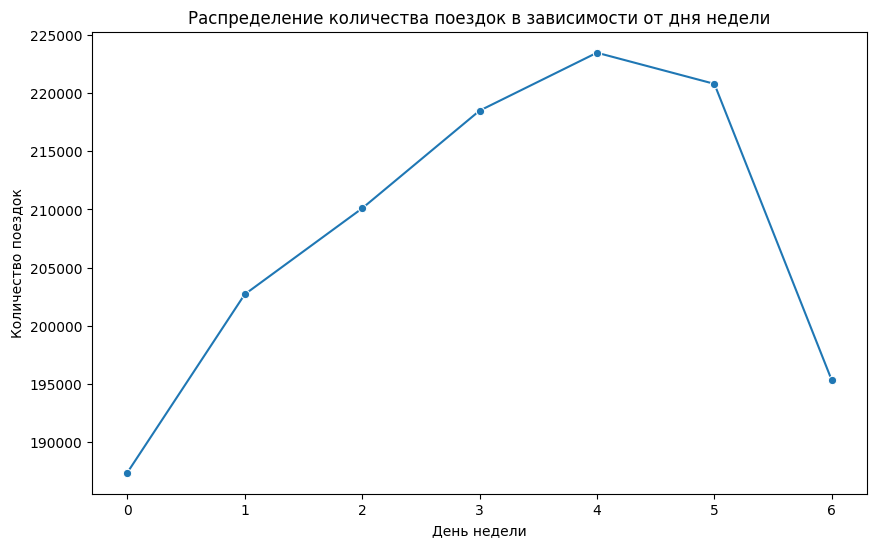

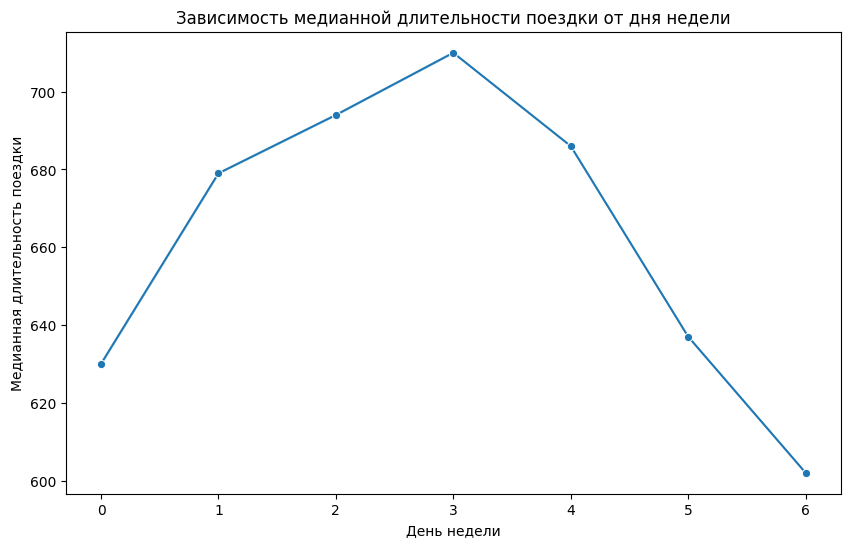

In [ ]:
# Построение распределения количества поездок в зависимости от дня недели
plt.figure(figsize=(10, 6))
sns.lineplot(data=taxi_data['pickup_day_of_week'].value_counts().sort_index(), marker='o')
plt.title('Распределение количества поездок в зависимости от дня недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.show()

# Вычисление медианной длительности поездок
trip_duration_median_dow = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()

# Заполнение столбца с медианными значениями
taxi_data_med['pickup_day_of_week'] = taxi_data['pickup_day_of_week']
taxi_data_med['trip_duration_median_day_of_week'] = taxi_data['pickup_day_of_week'].map(trip_duration_median_dow)

# Построение зависимости медианной длительности поездки от дня недели
plt.figure(figsize=(10, 6))
sns.lineplot(data=taxi_data_med, x='pickup_day_of_week', y='trip_duration_median_day_of_week', marker='o')
plt.title('Зависимость медианной длительности поездки от дня недели')
plt.xlabel('День недели')
plt.ylabel('Медианная длительность поездки')
plt.show()

В пятницу совершается больше всего поездок.

В воскресенье медианная длительность поездок наименьшая.

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [ ]:
pivot_table = pd.pivot_table(taxi_data, values='trip_duration', index='pickup_hour', columns='pickup_day_of_week', aggfunc='median')
pivot_table

pickup_day_of_week      0      1      2      3      4      5      6
pickup_hour                                                        
0                   598.0  591.0  601.0  609.0  649.0  685.0  675.0
1                   567.0  584.0  553.0  564.0  600.0  640.0  643.0
2                   565.0  565.0  544.0  576.0  572.0  610.0  604.5
3                   600.0  568.0  574.0  584.0  578.0  591.0  608.0
4                   640.0  600.5  616.0  595.0  634.0  610.0  598.5
5                   519.0  455.0  448.0  480.0  532.0  631.0  634.0
6                   462.0  461.0  463.0  471.0  476.0  508.0  554.0
7                   575.0  586.0  593.0  599.0  578.0  481.0  474.0
8                   672.0  703.0  704.0  721.0  689.0  489.0  460.0
9                   705.0  755.0  742.0  772.0  743.0  510.0  470.0
10                  694.0  778.0  788.0  772.0  744.0  542.0  506.0
11                  702.0  806.0  809.0  804.0  754.5  579.0  551.0
12                  692.0  783.5  800.5  799.0  746.0  618.0  594.0
13                  673.0  768.5  798.0  772.0  712.0  651.5  628.0
14                  681.0  768.0  783.0  811.0  735.0  660.0  667.0
15                  676.0  741.0  774.0  786.0  759.0  662.0  658.5
16                  642.0  706.0  741.0  757.0  729.5  655.0  672.0
17                  645.0  713.0  759.0  753.0  712.0  685.0  650.0
18                  637.0  699.5  724.0  729.0  696.0  678.0  641.0
19                  575.0  631.0  658.0  692.0  669.0  698.0  600.5
20                  573.0  622.0  639.0  682.0  664.0  669.0  585.0
21                  597.0  634.0  665.0  692.0  666.0  656.0  570.0
22                  602.0  659.0  675.0  709.0  705.0  690.0  586.0
23                  612.0  633.0  659.0  692.0  717.0  705.0  595.5

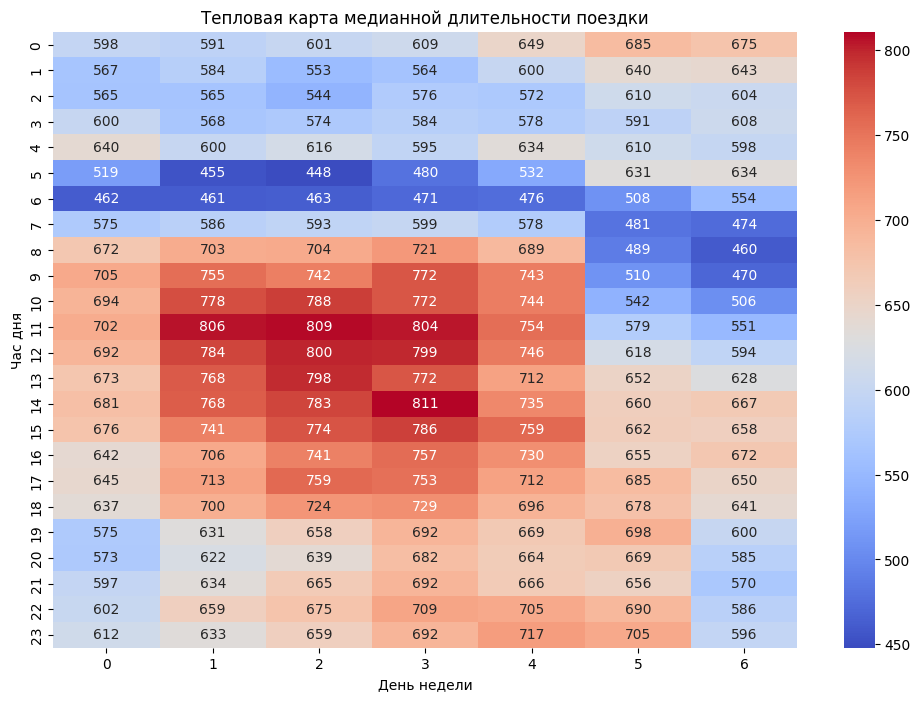

In [ ]:
# Создание тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".0f")
plt.title('Тепловая карта медианной длительности поездки')
plt.xlabel('День недели')
plt.ylabel('Час дня')
plt.show()

Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.

Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


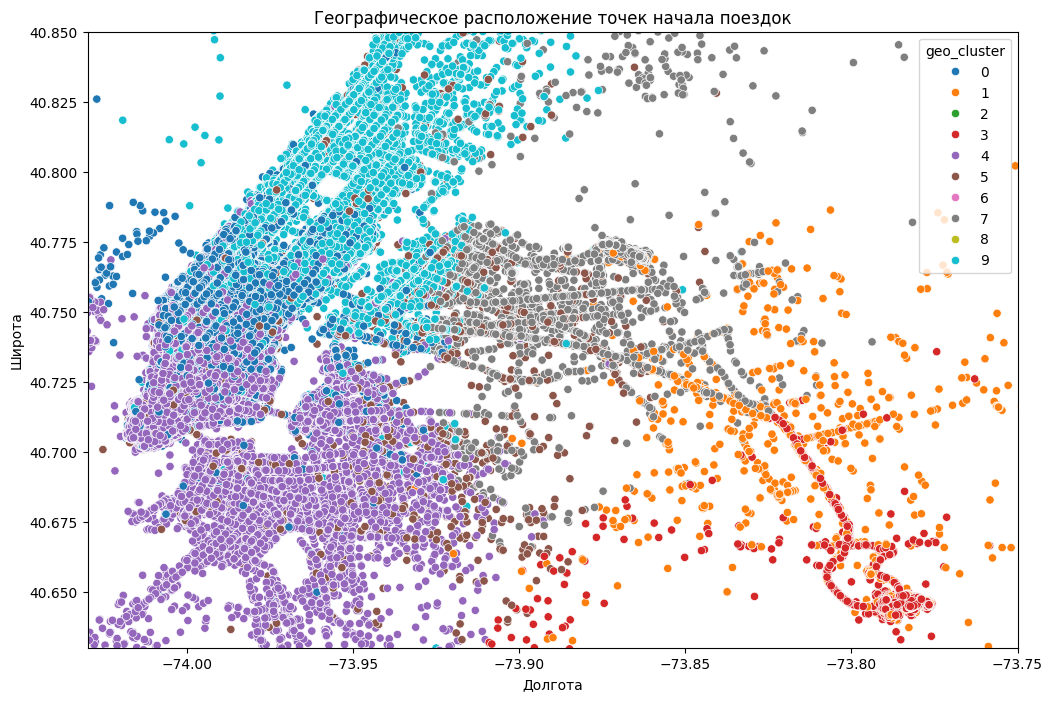

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


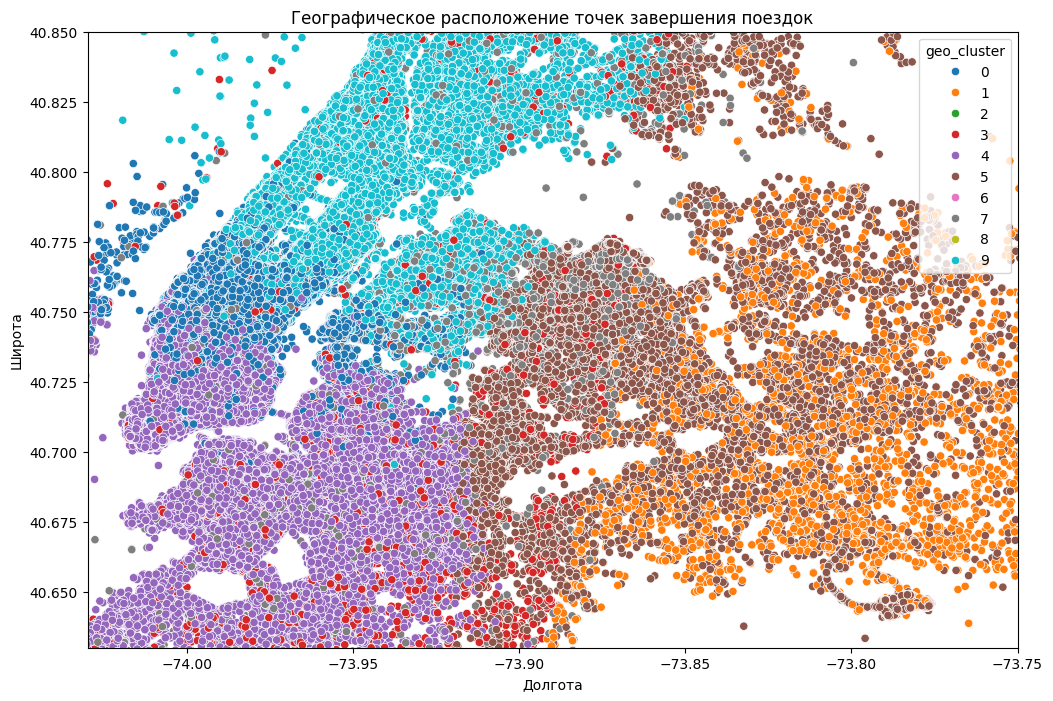

In [ ]:
# Ограничения на границы осей абсцисс и ординат
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Создание диаграммы рассеяния для точек начала поездок
plt.figure(figsize=(12, 8))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', hue='geo_cluster', data=taxi_data, palette='tab10')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.title('Географическое расположение точек начала поездок')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

# Создание диаграммы рассеяния для точек завершения поездок
plt.figure(figsize=(12, 8))
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', hue='geo_cluster', data=taxi_data, palette='tab10')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.title('Географическое расположение точек завершения поездок')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [ ]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [ ]:
train_data = taxi_data.copy()
train_data.head()

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  number_of_steps  \
0         40.765602                  N  ...              5.0   
1         40.731152                  N  ...              6.0   
2         40.710087                  N  ...             16.0   
3         40.706718                  N  ...              4.0   
4         40.782520                  N  ...              5.0   

  haversine_distance   direction  geo_cluster  temperature  visibility  \
0           1.498521   99.970196            9          4.4         8.0   
1           1.805507 -117.153768            4         28.9        16.1   
2           6.385098 -159.680165            4         -6.7        16.1   
3           1.485498 -172.737700            4          7.2        16.1   
4           1.188588  179.473585            9          9.4        16.1   

   wind speed  precip  events  trip_duration_log  
0        27.8     0.3    None           6.122493  
1         7.4     0.0    None           6.498282  
2        24.1     0.0    None           7.661527  
3        25.9     0.0    None           6.063785  
4         9.3     0.0    None           6.077642  

[5 rows x 27 columns]

### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


Наличие признака "dropoff_datetime" в обучающем наборе данных может создать утечку данных. Это потому, что информация о времени высадки пассажиров может быть связана с целевой переменной, и использование этого признака в модели может привести к переобучению, поскольку в реальных условиях временные данные о высадке пассажиров будут недоступны в момент прогнозирования.

In [ ]:
drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print(f'Осталось:  {train_data.shape[1]} признаков')

Осталось:  25 признаков


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [ ]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [ ]:
# Закодировать признак vendor_id
train_data['vendor_id'] = (train_data['vendor_id'] != 1).astype(int)

# Закодировать признак store_and_fwd_flag
train_data['store_and_fwd_flag'] = (train_data['store_and_fwd_flag'] != 'N').astype(int)

# Рассчет среднего по закодированному столбцу vendor_id
avr_vendor_id = round(train_data['vendor_id'].mean(), 2)

# Рассчет среднего по закодированному столбцу store_and_fwd_flag
avr_store_and_fwd_flag = round(train_data['store_and_fwd_flag'].mean(), 3)

print("Среднее по закодированному столбцу vendor_id", avr_vendor_id)
print("Среднее по закодированному столбцу store_and_fwd_flag", avr_store_and_fwd_flag)

Среднее по закодированному столбцу vendor_id 0.53
Среднее по закодированному столбцу store_and_fwd_flag 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [ ]:
# Выбор признаков для кодирования
features_to_encode = train_data[['pickup_day_of_week', 'geo_cluster', 'events']]

# Создание экземпляра OneHotEncoder с указанными параметрами
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')

# Применение кодировщика к выбранным признакам и преобразование в DataFrame
data_onehot = pd.DataFrame(one_hot_encoder.fit_transform(features_to_encode).toarray(), columns=one_hot_encoder.get_feature_names_out(features_to_encode.columns))

In [ ]:
print("Количество сгенерированных с помощью OneHotEncoding столбцов:", data_onehot.shape[1])

Количество сгенерированных с помощью OneHotEncoding столбцов: 18


Добавим полученную таблицу с закодированными признаками:

In [ ]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(features_to_encode, axis=1), data_onehot],
    axis=1
)
print(f"Shape of data: {train_data.shape}")

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [ ]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [ ]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [ ]:
# Создание экземпляра SelectKBest с параметром score_func=f_regression
selector = SelectKBest(score_func=f_regression, k=25)

# Применение SelectKBest к обучающей выборке
X_train_selected = selector.fit_transform(X_train, y_train_log)

# Оставление только отобранных признаков в обучающей и валидационной выборках
X_train_selected_columns = X_train.columns[selector.get_support()]
X_train_selected = X_train[X_train_selected_columns]
X_valid_selected = X_valid[X_train_selected_columns]

In [ ]:
X_train_selected_columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'temperature',
       'pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6',
       'geo_cluster_1', 'geo_cluster_3', 'geo_cluster_5', 'geo_cluster_7',
       'geo_cluster_9'],
      dtype='object')

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [ ]:
# Создание экземпляра MinMaxScaler
scaler = MinMaxScaler()

# Обучение нормализатора на обучающей выборке и трансформация обучающей и валидационной выборок
X_train_selected_normalized = scaler.fit_transform(X_train_selected)
X_valid_selected_normalized = scaler.transform(X_valid_selected)

# Рассчет среднего арифметического для первого предиктора
mean_first_predictor = round(np.mean(X_valid_selected_normalized[:, 0]), 2)
mean_first_predictor

0.54

In [ ]:
# Сохранение DataFrame в CSV
X_train_selected_normalized_df = pd.DataFrame(data=X_train_selected_normalized, columns=X_train_selected_columns)
X_valid_selected_normalized_df = pd.DataFrame(data=X_valid_selected_normalized, columns=X_train_selected_columns)
# X_train_selected_normalized_df.to_csv('/content/drive/MyDrive/ProjectPracticum2/X_train_selected_normalized.csv', index=False)
# X_valid_selected_normalized_df.to_csv('/content/drive/MyDrive/ProjectPracticum2/X_valid_selected_normalized.csv', index=False)

y_train_log_df = pd.DataFrame(data=y_train_log)
y_valid_log_df = pd.DataFrame(data=y_valid_log)
# y_train_log_df.to_csv('/content/drive/MyDrive/ProjectPracticum2/y_train_log.csv', index=False)
# y_valid_log_df.to_csv('/content/drive/MyDrive/ProjectPracticum2/y_valid_log.csv', index=False)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
X_train_selected_normalized_df = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/X_train_selected_normalized.csv')
X_valid_selected_normalized_df = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/X_valid_selected_normalized.csv')

y_train_log_df = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/y_train_log.csv')
y_valid_log_df = pd.read_csv('/content/drive/MyDrive/ProjectPracticum2/y_valid_log.csv')

In [ ]:
# Строим модель линейной регрессии
model_lr = LinearRegression()

# Обучаем модель
model_lr.fit(X_train_selected_normalized_df, y_train_log_df)

# Рассчитываем метрику RMSLE на тренировочной выборке
y_train_pred_log = model_lr.predict(X_train_selected_normalized_df)
rmsle_train_lr = np.sqrt(np.mean((y_train_log_df - y_train_pred_log)**2))

# Рассчитываем метрику RMSLE на валидационной выборке
y_val_pred_log = model_lr.predict(X_valid_selected_normalized_df)
rmsle_valid_lr = np.sqrt(np.mean((y_valid_log_df - y_val_pred_log)**2))

# Выводим результаты
print("RMSLE на тренировочной выборке:", round(rmsle_train_lr, 2))
print("RMSLE на валидационной выборке:", round(rmsle_valid_lr, 2))


RMSLE на тренировочной выборке: 0.54
RMSLE на валидационной выборке: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
# # Создаем объект PolynomialFeatures для генерации полиномиальных признаков второй степени без добавления bias
# poly = PolynomialFeatures(degree=2, include_bias=False)

# # Генерируем полиномиальные признаки
# X_train_poly = poly.fit_transform(X_train_selected_normalized)

# # Строим модель линейной регрессии
# model_poly = LinearRegression()

# # Обучаем модель
# model_poly.fit(X_train_poly, y_train_log)

# # Рассчитываем метрику RMSLE на тренировочной выборке
# y_train_pred_log = model_poly.predict(X_train_poly)
# rmsle_train_poly = np.sqrt(np.mean((y_train_log - y_train_pred_log)**2))

# # Нормализуем факторы в валидационной выборке
# X_val_poly = poly.transform(X_valid_selected_normalized)

# # Рассчитываем метрику RMSLE на валидационной выборке
# y_val_pred_log = model.predict(X_val_poly)
# rmsle_val_poly = np.sqrt(np.mean((y_valid_log - y_val_pred_log)**2))

# # Выводим результаты
# print("RMSLE на тренировочной выборке:", round(rmsle_train_poly, 2))
# print("RMSLE на валидационной выборке:", round(rmsle_val_poly, 2))

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# ваш код здесь

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
# Строим модель дерева решений
model_dtr = DecisionTreeRegressor(random_state = 42)

# Обучаем модель
model_dtr.fit(X_train_selected_normalized_df, y_train_log_df.values.ravel())

# Рассчитываем метрику RMSLE на тренировочной выборке
y_train_pred_log = model_dtr.predict(X_train_selected_normalized_df)
rmsle_train_dtr = np.sqrt(np.mean((y_train_log_df.values.ravel() - y_train_pred_log)**2))

# Рассчитываем метрику RMSLE на валидационной выборке
y_val_pred_log = model_dtr.predict(X_valid_selected_normalized_df)
rmsle_val_dtr = np.sqrt(np.mean((y_valid_log_df.values.ravel() - y_val_pred_log)**2))

# Выводим результаты
print("RMSLE на тренировочной выборке:", round(rmsle_train_dtr, 2))
print("RMSLE на валидационной выборке:", round(rmsle_val_dtr, 2))

RMSLE на тренировочной выборке: 0.0
RMSLE на валидационной выборке: 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


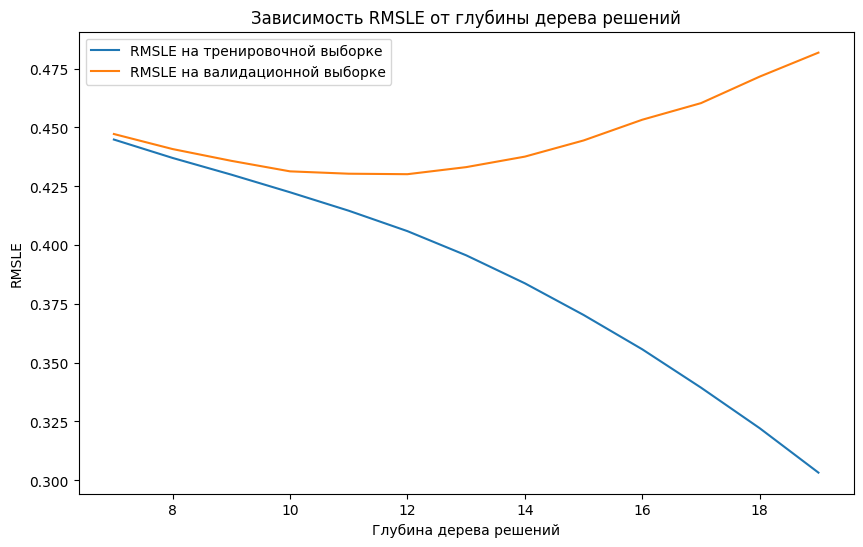

In [ ]:
# Задаем диапазон глубины дерева
max_depths = range(7, 20)

# Создаем пустые списки для хранения значений RMSLE
rmsle_train_list = []
rmsle_val_list = []

# Перебираем все возможные варианты глубины дерева
for depth in max_depths:
    # Строим модель дерева решений с указанной глубиной
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)

    # Обучаем модель
    model.fit(X_train_selected_normalized_df, y_train_log_df.values.ravel())

    # Рассчитываем метрику RMSLE на тренировочной выборке
    y_train_pred_log = model.predict(X_train_selected_normalized_df)
    rmsle_train = np.sqrt(np.mean((y_train_log_df.values.ravel() - y_train_pred_log)**2))
    rmsle_train_list.append(rmsle_train)

    # Рассчитываем метрику RMSLE на валидационной выборке
    y_val_pred_log = model.predict(X_valid_selected_normalized_df)
    rmsle_val = np.sqrt(np.mean((y_valid_log_df.values.ravel() - y_val_pred_log)**2))
    rmsle_val_list.append(rmsle_val)

# Строим графики
plt.figure(figsize=(10, 6))
plt.plot(max_depths, rmsle_train_list, label='RMSLE на тренировочной выборке')
plt.plot(max_depths, rmsle_val_list, label='RMSLE на валидационной выборке')
plt.xlabel('Глубина дерева решений')
plt.ylabel('RMSLE')
plt.title('Зависимость RMSLE от глубины дерева решений')
plt.legend()
plt.show()

In [ ]:
# Находим значения метрик RMSLE на тренировочной и валидационной выборках
# для дерева решений с выбранной оптимальной глубиной
optimal_depth = 12
model_dtr = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)

# Обучаем модель
model_dtr.fit(X_train_selected_normalized_df, y_train_log_df.values.ravel())

# Рассчитываем метрику RMSLE на тренировочной выборке
y_train_pred_log = model_dtr.predict(X_train_selected_normalized_df)
rmsle_train_dtr = np.sqrt(np.mean((y_train_log_df.values.ravel() - y_train_pred_log)**2))

# Рассчитываем метрику RMSLE на валидационной выборке
y_val_pred_log = model_dtr.predict(X_valid_selected_normalized_df)
rmsle_val_dtr = np.sqrt(np.mean((y_valid_log_df.values.ravel() - y_val_pred_log)**2))

print(f"RMSLE на тренировочной выборке: {round(rmsle_train_dtr, 2)}")
print(f"RMSLE на тренировочной выборке: {round(rmsle_val_dtr, 2)}")

RMSLE на тренировочной выборке: 0.41
RMSLE на тренировочной выборке: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# Создание и обучение модели случайного леса
model_rfr = RandomForestRegressor(n_estimators=200, max_depth=12, criterion='squared_error',
                                min_samples_split=20, random_state=42, verbose=True)
model_rfr.fit(X_train_selected_normalized_df, y_train_log_df.values.ravel())

# Прогнозирование на обучающей выборке
y_train_pred = model_rfr.predict(X_train_selected_normalized_df)
rmsle_train_rfr = np.sqrt(np.mean((y_train_log_df.values.ravel() - y_train_pred)**2))

# Прогнозирование на валидационной выборке
y_valid_pred = model_rfr.predict(X_valid_selected_normalized_df)
rmsle_valid_rfr = np.sqrt(np.mean((y_valid_log_df.values.ravel() - y_valid_pred)**2))

# Вывод результатов
print(f'RMSLE на тренировочной выборке: {rmsle_train_rfr:.2f}')
print(f'RMSLE на валидационной выборке: {rmsle_valid_rfr:.2f}')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed: 11.7min
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 40.5min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   29.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.2s


RMSLE на тренировочной выборке: 0.40
RMSLE на валидационной выборке: 0.41


[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   14.7s


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
# Создание и обучение модели градиентного бустинга
model_gbr = GradientBoostingRegressor(learning_rate=0.5, n_estimators=100, max_depth=6,
                                  min_samples_split=30, random_state=42, verbose=True)
model_gbr.fit(X_train_selected_normalized_df, y_train_log_df.values.ravel())

# Прогнозирование на обучающей выборке
y_train_pred = model_gbr.predict(X_train_selected_normalized_df)
rmsle_train_gbr = np.sqrt(np.mean((y_train_log_df.values.ravel() - y_train_pred)**2))

# Прогнозирование на валидационной выборке
y_valid_pred = model_gbr.predict(X_valid_selected_normalized_df)
rmsle_valid_gbr = np.sqrt(np.mean((y_valid_log_df.values.ravel() - y_valid_pred)**2))

# Вывод результатов
print(f'RMSLE на тренировочной выборке: {rmsle_train_gbr:.2f}')
print(f'RMSLE на валидационной выборке: {rmsle_valid_gbr:.2f}')

      Iter       Train Loss   Remaining Time 
         1           0.3110           20.26m
         2           0.2247           18.03m
         3           0.1987           17.67m
         4           0.1876           17.15m
         5           0.1823           16.37m
         6           0.1783           16.11m
         7           0.1756           15.98m
         8           0.1730           15.49m
         9           0.1709           15.31m
        10           0.1696           15.14m
        20           0.1577           13.09m
        30           0.1538           11.43m
        40           0.1502            9.70m
        50           0.1480            8.05m
        60           0.1451            6.43m
        70           0.1431            4.81m
        80           0.1410            3.21m
        90           0.1393            1.60m
       100           0.1383            0.00s
RMSLE на тренировочной выборке: 0.37
RMSLE на валидационной выборке: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


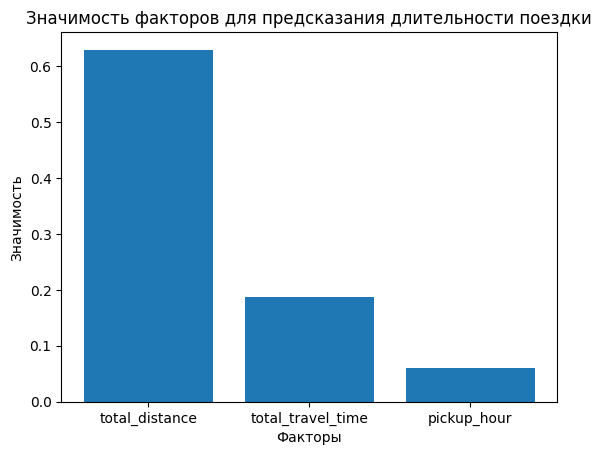

In [ ]:
# Получение коэффициентов значимости факторов
feature_importances = model_gbr.feature_importances_

# Отсортировать факторы по их значимости
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]

# Выбрать топ-3 наиболее значимых фактора
top_3_features = sorted_indices[:3]
top_3_importances = sorted_feature_importances[:3]

# Получение названий значимых факторов
feature_names = X_train_selected_normalized_df.columns[top_3_features]

# Построение столбчатой диаграммы
plt.bar(range(len(top_3_features)), top_3_importances, tick_label=feature_names)
plt.xlabel('Факторы')
plt.ylabel('Значимость')
plt.title('Значимость факторов для предсказания длительности поездки')
plt.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [ ]:
# Получение предсказаний модели на валидационной выборке
y_pred_log = model_gbr.predict(X_valid_selected_normalized_df)

# Преобразование логарифмических предсказаний и целевой переменной в исходный масштаб
y_pred = np.exp(y_pred_log) - 1
y_valid = np.exp(y_valid_log_df) - 1

# Расчет медианной абсолютной ошибки (MeAE)
meae = median_absolute_error(y_valid, y_pred)

# Перевод значения MeAE в минуты и округление до первого знака после точки-разделителя
meae_minutes = round(meae / 60, 1)

# Вывод значения метрики MeAE в минутах
print("Медианная абсолютная ошибка (MeAE) в минутах: ", meae_minutes)

Медианная абсолютная ошибка (MeAE) в минутах:  1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/ProjectPracticum2/test_data.csv")
osrm_data_test = pd.read_csv("/content/drive/MyDrive/ProjectPracticum2/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data['pickup_date'] = pd.to_datetime(test_data['pickup_date'])
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
)
best_features = X_train_selected_columns
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [ ]:
# Предсказание длительности поездки для тестовой выборки
y_test_predict_log = model_gbr.predict(X_test_scaled)

# Преобразование логарифмических предсказаний в исходный масштаб
y_test_predict = np.exp(y_test_predict_log) - 1

test_id = test_data["id"]

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
# submission.to_csv('/content/drive/MyDrive/ProjectPracticum2/submission_gb.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.

Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
# !pip install xgboost

После чего модуль можно импортировать:

In [ ]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
X_train_scaled = X_train_selected_normalized_df
y_train_log = y_train_log_df
X_valid_scaled = X_valid_selected_normalized_df
y_valid_log = y_valid_log_df
best_features = list(best_features)
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model_xgb = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73991	valid-rmse:0.74191
[10]	train-rmse:0.49091	valid-rmse:0.49350
[20]	train-rmse:0.44059	valid-rmse:0.44349
[30]	train-rmse:0.42632	valid-rmse:0.42939
[40]	train-rmse:0.41827	valid-rmse:0.42149
[50]	train-rmse:0.41368	valid-rmse:0.41718
[60]	train-rmse:0.40965	valid-rmse:0.41342
[70]	train-rmse:0.40665	valid-rmse:0.41071
[80]	train-rmse:0.40411	valid-rmse:0.40850
[90]	train-rmse:0.40228	valid-rmse:0.40690
[100]	train-rmse:0.40040	valid-rmse:0.40525
[110]	train-rmse:0.39923	valid-rmse:0.40438
[120]	train-rmse:0.39789	valid-rmse:0.40331
[130]	train-rmse:0.39646	valid-rmse:0.40220
[140]	train-rmse:0.39550	valid-rmse:0.40146
[150]	train-rmse:0.39448	valid-rmse:0.40072
[160]	train-rmse:0.39352	valid-rmse:0.39998
[170]	train-rmse:0.39261	valid-rmse:0.39927
[180]	train-rmse:0.39184	valid-rmse:0.39882
[190]	train-rmse:0.39098	valid-rmse:0.39827
[200]	train-rmse:0.39005	valid-rmse:0.39772
[210]	train-rmse:0.38933	valid-rmse:0.39729
[220]	train-rmse:0.38844	valid-rmse:0.39666

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model_xgb.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model_xgb.best_score)

Modeling RMSLE 0.39419


### **Использование Optuna для поиска оптимальных параметров модели XGBoost**

In [ ]:
def objective(trial):
    # Создание матриц наблюдений в формате DMatrix
    X_train_scaled = X_train_selected_normalized_df
    y_train_log = y_train_log_df
    X_valid_scaled = X_valid_selected_normalized_df
    y_valid_log = y_valid_log_df
    best_features = [
        'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
        'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time',
        'number_of_steps', 'haversine_distance', 'temperature',
        'pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3',
        'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6',
        'geo_cluster_1', 'geo_cluster_3', 'geo_cluster_5', 'geo_cluster_7',
        'geo_cluster_9']
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=best_features)
    dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=best_features)
    dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

    # Гиперпараметры модели
    xgb_pars = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster' : 'gbtree',
        'nthread': -1,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 1e-3, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
    }

    # Тренировочная и валидационная выборка
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    # Обучаем модель XGBoost
    model_xgb = xgb.train(
        params=xgb_pars, #гиперпараметры модели
        dtrain=dtrain, #обучающая выборка
        num_boost_round=300, #количество моделей в ансамбле
        evals=watchlist, #выборки, на которых считается матрица
        early_stopping_rounds=20, #раняя остановка
        maximize=False, #смена поиска максимума на минимум
        # verbose_eval=10 #шаг, через который происходит отображение метрик
    )

    #Делаем предсказание на тестовом наборе данных
    y_test_predict = np.exp(model_xgb.predict(dtest)) - 1

    return model_xgb.best_score

In [ ]:
# Создание и запуск исследования Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-06-02 05:34:15,463] A new study created in memory with name: no-name-1e3c1a98-42ec-482c-bb1a-894949b742e7


[0]	train-rmse:0.54888	valid-rmse:0.55127
[1]	train-rmse:0.49214	valid-rmse:0.49470
[2]	train-rmse:0.48201	valid-rmse:0.48451
[3]	train-rmse:0.47452	valid-rmse:0.47709
[4]	train-rmse:0.45229	valid-rmse:0.45501
[5]	train-rmse:0.44741	valid-rmse:0.45028
[6]	train-rmse:0.44526	valid-rmse:0.44810
[7]	train-rmse:0.44384	valid-rmse:0.44674
[8]	train-rmse:0.44250	valid-rmse:0.44533
[9]	train-rmse:0.44006	valid-rmse:0.44273
[10]	train-rmse:0.43533	valid-rmse:0.43803
[11]	train-rmse:0.43291	valid-rmse:0.43556
[12]	train-rmse:0.43202	valid-rmse:0.43465
[13]	train-rmse:0.43036	valid-rmse:0.43303
[14]	train-rmse:0.42968	valid-rmse:0.43236
[15]	train-rmse:0.42900	valid-rmse:0.43172
[16]	train-rmse:0.42820	valid-rmse:0.43092
[17]	train-rmse:0.42788	valid-rmse:0.43067
[18]	train-rmse:0.42678	valid-rmse:0.42959
[19]	train-rmse:0.42624	valid-rmse:0.42912
[20]	train-rmse:0.42602	valid-rmse:0.42894
[21]	train-rmse:0.42533	valid-rmse:0.42810
[22]	train-rmse:0.42495	valid-rmse:0.42775
[23]	train-rmse:0.424

[I 2024-06-02 05:35:14,671] Trial 0 finished with value: 0.40146029837892727 and parameters: {'min_child_weight': 2, 'lambda': 0.2886970190277997, 'alpha': 0.4414281632260449, 'max_depth': 4, 'eta': 0.6104804287328223, 'gamma': 0.4112373777232329, 'colsample_bytree': 0.39664340342036464, 'subsample': 0.6655784622594052}. Best is trial 0 with value: 0.40146029837892727.


[0]	train-rmse:0.51053	valid-rmse:0.51323
[1]	train-rmse:0.46758	valid-rmse:0.47102
[2]	train-rmse:0.45781	valid-rmse:0.46177
[3]	train-rmse:0.44933	valid-rmse:0.45360
[4]	train-rmse:0.41849	valid-rmse:0.42388
[5]	train-rmse:0.41396	valid-rmse:0.41992
[6]	train-rmse:0.41121	valid-rmse:0.41863
[7]	train-rmse:0.40946	valid-rmse:0.41765
[8]	train-rmse:0.40740	valid-rmse:0.41616
[9]	train-rmse:0.40604	valid-rmse:0.41561
[10]	train-rmse:0.40335	valid-rmse:0.41342
[11]	train-rmse:0.40187	valid-rmse:0.41217
[12]	train-rmse:0.40118	valid-rmse:0.41180
[13]	train-rmse:0.39985	valid-rmse:0.41090
[14]	train-rmse:0.39916	valid-rmse:0.41054
[15]	train-rmse:0.39838	valid-rmse:0.41059
[16]	train-rmse:0.39762	valid-rmse:0.41024
[17]	train-rmse:0.39728	valid-rmse:0.41032
[18]	train-rmse:0.39663	valid-rmse:0.41023
[19]	train-rmse:0.39612	valid-rmse:0.41044
[20]	train-rmse:0.39541	valid-rmse:0.41046
[21]	train-rmse:0.39489	valid-rmse:0.41023
[22]	train-rmse:0.39443	valid-rmse:0.41048
[23]	train-rmse:0.393

[I 2024-06-02 05:35:32,754] Trial 1 finished with value: 0.40847590461791017 and parameters: {'min_child_weight': 13, 'lambda': 0.8396711036504431, 'alpha': 0.19663190660226787, 'max_depth': 8, 'eta': 0.696137274348082, 'gamma': 0.24534599801857163, 'colsample_bytree': 0.5458117666233165, 'subsample': 0.50357488372785}. Best is trial 0 with value: 0.40146029837892727.


[0]	train-rmse:0.54751	valid-rmse:0.55084
[1]	train-rmse:0.45452	valid-rmse:0.45890
[2]	train-rmse:0.42913	valid-rmse:0.43433
[3]	train-rmse:0.42075	valid-rmse:0.42679
[4]	train-rmse:0.40986	valid-rmse:0.41716
[5]	train-rmse:0.40421	valid-rmse:0.41263
[6]	train-rmse:0.40121	valid-rmse:0.41055
[7]	train-rmse:0.39952	valid-rmse:0.41011
[8]	train-rmse:0.39419	valid-rmse:0.40576
[9]	train-rmse:0.39255	valid-rmse:0.40520
[10]	train-rmse:0.39122	valid-rmse:0.40457
[11]	train-rmse:0.39039	valid-rmse:0.40419
[12]	train-rmse:0.38770	valid-rmse:0.40254
[13]	train-rmse:0.38657	valid-rmse:0.40248
[14]	train-rmse:0.38556	valid-rmse:0.40263
[15]	train-rmse:0.38491	valid-rmse:0.40247
[16]	train-rmse:0.38370	valid-rmse:0.40216
[17]	train-rmse:0.38286	valid-rmse:0.40215
[18]	train-rmse:0.38207	valid-rmse:0.40234
[19]	train-rmse:0.38109	valid-rmse:0.40232
[20]	train-rmse:0.38021	valid-rmse:0.40253
[21]	train-rmse:0.37896	valid-rmse:0.40263
[22]	train-rmse:0.37834	valid-rmse:0.40255
[23]	train-rmse:0.377

[I 2024-06-02 05:35:47,799] Trial 2 finished with value: 0.402148968891115 and parameters: {'min_child_weight': 7, 'lambda': 0.49935097568351733, 'alpha': 0.5487079372451982, 'max_depth': 9, 'eta': 0.5350184376261549, 'gamma': 0.07839292984841638, 'colsample_bytree': 0.8784116535381761, 'subsample': 0.5760048606105671}. Best is trial 0 with value: 0.40146029837892727.


[0]	train-rmse:0.50574	valid-rmse:0.50829
[1]	train-rmse:0.49302	valid-rmse:0.49512
[2]	train-rmse:0.48881	valid-rmse:0.49106
[3]	train-rmse:0.48197	valid-rmse:0.48430
[4]	train-rmse:0.45943	valid-rmse:0.46196
[5]	train-rmse:0.45561	valid-rmse:0.45815
[6]	train-rmse:0.45345	valid-rmse:0.45604
[7]	train-rmse:0.44881	valid-rmse:0.45135
[8]	train-rmse:0.44749	valid-rmse:0.45005
[9]	train-rmse:0.44642	valid-rmse:0.44901
[10]	train-rmse:0.44411	valid-rmse:0.44662
[11]	train-rmse:0.44274	valid-rmse:0.44516
[12]	train-rmse:0.44131	valid-rmse:0.44379
[13]	train-rmse:0.43978	valid-rmse:0.44228
[14]	train-rmse:0.43899	valid-rmse:0.44149
[15]	train-rmse:0.43813	valid-rmse:0.44067
[16]	train-rmse:0.43685	valid-rmse:0.43937
[17]	train-rmse:0.43418	valid-rmse:0.43672
[18]	train-rmse:0.43196	valid-rmse:0.43438
[19]	train-rmse:0.43119	valid-rmse:0.43364
[20]	train-rmse:0.43088	valid-rmse:0.43337
[21]	train-rmse:0.42961	valid-rmse:0.43210
[22]	train-rmse:0.42887	valid-rmse:0.43141
[23]	train-rmse:0.428

[I 2024-06-02 05:36:39,566] Trial 3 finished with value: 0.4045054554918627 and parameters: {'min_child_weight': 4, 'lambda': 0.1614883450433632, 'alpha': 0.387057267890832, 'max_depth': 3, 'eta': 0.9504966838797448, 'gamma': 0.7575586741021981, 'colsample_bytree': 0.569271392205741, 'subsample': 0.7447327346415147}. Best is trial 0 with value: 0.40146029837892727.


[0]	train-rmse:0.53218	valid-rmse:0.53453
[1]	train-rmse:0.48237	valid-rmse:0.48486
[2]	train-rmse:0.47204	valid-rmse:0.47468
[3]	train-rmse:0.46716	valid-rmse:0.46962
[4]	train-rmse:0.44095	valid-rmse:0.44357
[5]	train-rmse:0.43575	valid-rmse:0.43842
[6]	train-rmse:0.43334	valid-rmse:0.43609
[7]	train-rmse:0.43124	valid-rmse:0.43406
[8]	train-rmse:0.42934	valid-rmse:0.43223
[9]	train-rmse:0.42826	valid-rmse:0.43125
[10]	train-rmse:0.42354	valid-rmse:0.42661
[11]	train-rmse:0.42141	valid-rmse:0.42451
[12]	train-rmse:0.42024	valid-rmse:0.42338
[13]	train-rmse:0.41849	valid-rmse:0.42169
[14]	train-rmse:0.41777	valid-rmse:0.42101
[15]	train-rmse:0.41706	valid-rmse:0.42037
[16]	train-rmse:0.41618	valid-rmse:0.41964
[17]	train-rmse:0.41599	valid-rmse:0.41952
[18]	train-rmse:0.41491	valid-rmse:0.41858
[19]	train-rmse:0.41433	valid-rmse:0.41804
[20]	train-rmse:0.41336	valid-rmse:0.41712
[21]	train-rmse:0.41270	valid-rmse:0.41648
[22]	train-rmse:0.41209	valid-rmse:0.41597
[23]	train-rmse:0.411

[I 2024-06-02 05:37:27,526] Trial 4 finished with value: 0.3974993555905066 and parameters: {'min_child_weight': 7, 'lambda': 0.5741982550717438, 'alpha': 0.47819928774114306, 'max_depth': 5, 'eta': 0.652405564591165, 'gamma': 0.3667880857792273, 'colsample_bytree': 0.5173268394009757, 'subsample': 0.9063613680084834}. Best is trial 4 with value: 0.3974993555905066.


[0]	train-rmse:0.55502	valid-rmse:0.55746
[1]	train-rmse:0.47177	valid-rmse:0.47449
[2]	train-rmse:0.44906	valid-rmse:0.45181
[3]	train-rmse:0.44065	valid-rmse:0.44340
[4]	train-rmse:0.42832	valid-rmse:0.43123
[5]	train-rmse:0.42415	valid-rmse:0.42714
[6]	train-rmse:0.42154	valid-rmse:0.42466
[7]	train-rmse:0.41873	valid-rmse:0.42196
[8]	train-rmse:0.41705	valid-rmse:0.42046
[9]	train-rmse:0.41586	valid-rmse:0.41948
[10]	train-rmse:0.41435	valid-rmse:0.41803
[11]	train-rmse:0.41327	valid-rmse:0.41699
[12]	train-rmse:0.41094	valid-rmse:0.41486
[13]	train-rmse:0.41016	valid-rmse:0.41419
[14]	train-rmse:0.40954	valid-rmse:0.41369
[15]	train-rmse:0.40828	valid-rmse:0.41260
[16]	train-rmse:0.40761	valid-rmse:0.41211
[17]	train-rmse:0.40701	valid-rmse:0.41164
[18]	train-rmse:0.40626	valid-rmse:0.41127
[19]	train-rmse:0.40562	valid-rmse:0.41071
[20]	train-rmse:0.40513	valid-rmse:0.41030
[21]	train-rmse:0.40475	valid-rmse:0.40998
[22]	train-rmse:0.40428	valid-rmse:0.40959
[23]	train-rmse:0.403

[I 2024-06-02 05:38:00,125] Trial 5 finished with value: 0.40153008245576155 and parameters: {'min_child_weight': 20, 'lambda': 0.393128595092221, 'alpha': 0.1348456531990922, 'max_depth': 6, 'eta': 0.5523365044671097, 'gamma': 0.2767999232639046, 'colsample_bytree': 0.6946312090703503, 'subsample': 0.5559293684116454}. Best is trial 4 with value: 0.3974993555905066.


[0]	train-rmse:0.78584	valid-rmse:0.78778
[1]	train-rmse:0.77988	valid-rmse:0.78182
[2]	train-rmse:0.77407	valid-rmse:0.77602
[3]	train-rmse:0.76835	valid-rmse:0.77031
[4]	train-rmse:0.76262	valid-rmse:0.76459
[5]	train-rmse:0.75696	valid-rmse:0.75894
[6]	train-rmse:0.75142	valid-rmse:0.75341
[7]	train-rmse:0.74594	valid-rmse:0.74793
[8]	train-rmse:0.74065	valid-rmse:0.74265
[9]	train-rmse:0.73535	valid-rmse:0.73736
[10]	train-rmse:0.73011	valid-rmse:0.73213
[11]	train-rmse:0.72507	valid-rmse:0.72710
[12]	train-rmse:0.72014	valid-rmse:0.72218
[13]	train-rmse:0.71518	valid-rmse:0.71722
[14]	train-rmse:0.71039	valid-rmse:0.71244
[15]	train-rmse:0.70556	valid-rmse:0.70761
[16]	train-rmse:0.70100	valid-rmse:0.70306
[17]	train-rmse:0.69638	valid-rmse:0.69844
[18]	train-rmse:0.69187	valid-rmse:0.69394
[19]	train-rmse:0.68735	valid-rmse:0.68943
[20]	train-rmse:0.68293	valid-rmse:0.68502
[21]	train-rmse:0.67855	valid-rmse:0.68065
[22]	train-rmse:0.67425	valid-rmse:0.67636
[23]	train-rmse:0.670

[I 2024-06-02 05:39:12,698] Trial 6 finished with value: 0.4337724710321987 and parameters: {'min_child_weight': 14, 'lambda': 0.03409739086852687, 'alpha': 0.013569279393935417, 'max_depth': 5, 'eta': 0.011862520449994505, 'gamma': 0.07871784445985255, 'colsample_bytree': 0.8560581861262813, 'subsample': 0.9692066411295903}. Best is trial 4 with value: 0.3974993555905066.


[0]	train-rmse:0.70663	valid-rmse:0.70866
[1]	train-rmse:0.64002	valid-rmse:0.64213
[2]	train-rmse:0.58995	valid-rmse:0.59218
[3]	train-rmse:0.55286	valid-rmse:0.55518
[4]	train-rmse:0.52311	valid-rmse:0.52550
[5]	train-rmse:0.50079	valid-rmse:0.50323
[6]	train-rmse:0.48463	valid-rmse:0.48715
[7]	train-rmse:0.47264	valid-rmse:0.47521
[8]	train-rmse:0.46374	valid-rmse:0.46634
[9]	train-rmse:0.45687	valid-rmse:0.45950
[10]	train-rmse:0.45143	valid-rmse:0.45405
[11]	train-rmse:0.44818	valid-rmse:0.45078
[12]	train-rmse:0.44492	valid-rmse:0.44751
[13]	train-rmse:0.44203	valid-rmse:0.44466
[14]	train-rmse:0.44017	valid-rmse:0.44280
[15]	train-rmse:0.43787	valid-rmse:0.44053
[16]	train-rmse:0.43622	valid-rmse:0.43885
[17]	train-rmse:0.43440	valid-rmse:0.43704
[18]	train-rmse:0.43302	valid-rmse:0.43565
[19]	train-rmse:0.43157	valid-rmse:0.43421
[20]	train-rmse:0.43038	valid-rmse:0.43302
[21]	train-rmse:0.42935	valid-rmse:0.43200
[22]	train-rmse:0.42784	valid-rmse:0.43049
[23]	train-rmse:0.426

[I 2024-06-02 05:40:17,185] Trial 7 finished with value: 0.3951206686698775 and parameters: {'min_child_weight': 2, 'lambda': 0.8368181469789833, 'alpha': 0.5741298991296142, 'max_depth': 5, 'eta': 0.17532022261445943, 'gamma': 0.45055204346973715, 'colsample_bytree': 0.7565635036522873, 'subsample': 0.9314234677066404}. Best is trial 7 with value: 0.3951206686698775.


[0]	train-rmse:0.62933	valid-rmse:0.63168
[1]	train-rmse:0.54272	valid-rmse:0.54537
[2]	train-rmse:0.51172	valid-rmse:0.51458
[3]	train-rmse:0.48460	valid-rmse:0.48744
[4]	train-rmse:0.45760	valid-rmse:0.46065
[5]	train-rmse:0.44529	valid-rmse:0.44859
[6]	train-rmse:0.44128	valid-rmse:0.44451
[7]	train-rmse:0.43592	valid-rmse:0.43936
[8]	train-rmse:0.43403	valid-rmse:0.43756
[9]	train-rmse:0.43278	valid-rmse:0.43638
[10]	train-rmse:0.42596	valid-rmse:0.42963
[11]	train-rmse:0.42339	valid-rmse:0.42712
[12]	train-rmse:0.42198	valid-rmse:0.42573
[13]	train-rmse:0.42043	valid-rmse:0.42433
[14]	train-rmse:0.41933	valid-rmse:0.42327
[15]	train-rmse:0.41739	valid-rmse:0.42164
[16]	train-rmse:0.41610	valid-rmse:0.42046
[17]	train-rmse:0.41538	valid-rmse:0.41984
[18]	train-rmse:0.41394	valid-rmse:0.41873
[19]	train-rmse:0.41271	valid-rmse:0.41777
[20]	train-rmse:0.41184	valid-rmse:0.41710
[21]	train-rmse:0.41145	valid-rmse:0.41683
[22]	train-rmse:0.41069	valid-rmse:0.41640
[23]	train-rmse:0.410

[I 2024-06-02 05:41:16,782] Trial 8 finished with value: 0.39595952515661503 and parameters: {'min_child_weight': 11, 'lambda': 0.3623682540540497, 'alpha': 0.17725405462643132, 'max_depth': 7, 'eta': 0.35007128983723335, 'gamma': 0.10516007247043524, 'colsample_bytree': 0.3474510597647378, 'subsample': 0.6745470410254053}. Best is trial 7 with value: 0.3951206686698775.


[0]	train-rmse:0.59830	valid-rmse:0.60104
[1]	train-rmse:0.50350	valid-rmse:0.50683
[2]	train-rmse:0.45859	valid-rmse:0.46227
[3]	train-rmse:0.43842	valid-rmse:0.44221
[4]	train-rmse:0.42643	valid-rmse:0.43065
[5]	train-rmse:0.41985	valid-rmse:0.42440
[6]	train-rmse:0.41597	valid-rmse:0.42090
[7]	train-rmse:0.41344	valid-rmse:0.41870
[8]	train-rmse:0.41100	valid-rmse:0.41685
[9]	train-rmse:0.40732	valid-rmse:0.41334
[10]	train-rmse:0.40614	valid-rmse:0.41255
[11]	train-rmse:0.40462	valid-rmse:0.41170
[12]	train-rmse:0.40265	valid-rmse:0.40988
[13]	train-rmse:0.40135	valid-rmse:0.40929
[14]	train-rmse:0.40046	valid-rmse:0.40888
[15]	train-rmse:0.39912	valid-rmse:0.40832
[16]	train-rmse:0.39790	valid-rmse:0.40776
[17]	train-rmse:0.39727	valid-rmse:0.40774
[18]	train-rmse:0.39634	valid-rmse:0.40707
[19]	train-rmse:0.39603	valid-rmse:0.40712
[20]	train-rmse:0.39466	valid-rmse:0.40638
[21]	train-rmse:0.39422	valid-rmse:0.40614
[22]	train-rmse:0.39371	valid-rmse:0.40607
[23]	train-rmse:0.393

[I 2024-06-02 05:41:36,077] Trial 9 finished with value: 0.40545303916011344 and parameters: {'min_child_weight': 2, 'lambda': 0.3002765027117936, 'alpha': 0.5821016623127735, 'max_depth': 8, 'eta': 0.3852407180781302, 'gamma': 0.66732464233725, 'colsample_bytree': 0.9127492489632716, 'subsample': 0.3350735850995077}. Best is trial 7 with value: 0.3951206686698775.


[0]	train-rmse:0.78150	valid-rmse:0.78344
[1]	train-rmse:0.77134	valid-rmse:0.77329
[2]	train-rmse:0.76162	valid-rmse:0.76359
[3]	train-rmse:0.75198	valid-rmse:0.75397
[4]	train-rmse:0.74263	valid-rmse:0.74463
[5]	train-rmse:0.73355	valid-rmse:0.73556
[6]	train-rmse:0.72477	valid-rmse:0.72678
[7]	train-rmse:0.71625	valid-rmse:0.71827
[8]	train-rmse:0.70815	valid-rmse:0.71017
[9]	train-rmse:0.70019	valid-rmse:0.70222
[10]	train-rmse:0.69241	valid-rmse:0.69445
[11]	train-rmse:0.68728	valid-rmse:0.68933
[12]	train-rmse:0.67997	valid-rmse:0.68203
[13]	train-rmse:0.67282	valid-rmse:0.67487
[14]	train-rmse:0.66597	valid-rmse:0.66803
[15]	train-rmse:0.65933	valid-rmse:0.66140
[16]	train-rmse:0.65295	valid-rmse:0.65505
[17]	train-rmse:0.64670	valid-rmse:0.64881
[18]	train-rmse:0.64074	valid-rmse:0.64286
[19]	train-rmse:0.63511	valid-rmse:0.63725
[20]	train-rmse:0.62943	valid-rmse:0.63157
[21]	train-rmse:0.62386	valid-rmse:0.62600
[22]	train-rmse:0.61856	valid-rmse:0.62071
[23]	train-rmse:0.613

[I 2024-06-02 05:42:31,354] Trial 10 finished with value: 0.4381389090066459 and parameters: {'min_child_weight': 19, 'lambda': 0.9933003983130745, 'alpha': 0.9166077075336543, 'max_depth': 3, 'eta': 0.022049389417007736, 'gamma': 0.9254159533818489, 'colsample_bytree': 0.7048314426652075, 'subsample': 0.83855889436917}. Best is trial 7 with value: 0.3951206686698775.


[0]	train-rmse:0.70309	valid-rmse:0.70533
[1]	train-rmse:0.60788	valid-rmse:0.61035
[2]	train-rmse:0.57601	valid-rmse:0.57865
[3]	train-rmse:0.53182	valid-rmse:0.53456
[4]	train-rmse:0.49601	valid-rmse:0.49887
[5]	train-rmse:0.47489	valid-rmse:0.47801
[6]	train-rmse:0.46460	valid-rmse:0.46771
[7]	train-rmse:0.45305	valid-rmse:0.45630
[8]	train-rmse:0.44776	valid-rmse:0.45113
[9]	train-rmse:0.44467	valid-rmse:0.44805
[10]	train-rmse:0.43691	valid-rmse:0.44043
[11]	train-rmse:0.43389	valid-rmse:0.43751
[12]	train-rmse:0.43228	valid-rmse:0.43588
[13]	train-rmse:0.43044	valid-rmse:0.43404
[14]	train-rmse:0.42910	valid-rmse:0.43273
[15]	train-rmse:0.42663	valid-rmse:0.43042
[16]	train-rmse:0.42515	valid-rmse:0.42900
[17]	train-rmse:0.42414	valid-rmse:0.42805
[18]	train-rmse:0.42304	valid-rmse:0.42702
[19]	train-rmse:0.42195	valid-rmse:0.42604
[20]	train-rmse:0.42040	valid-rmse:0.42470
[21]	train-rmse:0.41972	valid-rmse:0.42418
[22]	train-rmse:0.41812	valid-rmse:0.42277
[23]	train-rmse:0.417

[I 2024-06-02 05:43:36,567] Trial 11 finished with value: 0.3965995765897037 and parameters: {'min_child_weight': 10, 'lambda': 0.6666276469439091, 'alpha': 0.7226312649309665, 'max_depth': 7, 'eta': 0.2672666268214096, 'gamma': 0.5681607187151362, 'colsample_bytree': 0.3026715937130674, 'subsample': 0.7913664262345714}. Best is trial 7 with value: 0.3951206686698775.


[0]	train-rmse:0.68602	valid-rmse:0.68809
[1]	train-rmse:0.60732	valid-rmse:0.60963
[2]	train-rmse:0.55433	valid-rmse:0.55671
[3]	train-rmse:0.51845	valid-rmse:0.52091
[4]	train-rmse:0.49015	valid-rmse:0.49273
[5]	train-rmse:0.47093	valid-rmse:0.47354
[6]	train-rmse:0.45782	valid-rmse:0.46053
[7]	train-rmse:0.44847	valid-rmse:0.45126
[8]	train-rmse:0.44210	valid-rmse:0.44496
[9]	train-rmse:0.43732	valid-rmse:0.44023
[10]	train-rmse:0.43358	valid-rmse:0.43653
[11]	train-rmse:0.43111	valid-rmse:0.43404
[12]	train-rmse:0.42881	valid-rmse:0.43175
[13]	train-rmse:0.42695	valid-rmse:0.42991
[14]	train-rmse:0.42556	valid-rmse:0.42857
[15]	train-rmse:0.42392	valid-rmse:0.42705
[16]	train-rmse:0.42241	valid-rmse:0.42560
[17]	train-rmse:0.42099	valid-rmse:0.42427
[18]	train-rmse:0.41926	valid-rmse:0.42258
[19]	train-rmse:0.41780	valid-rmse:0.42117
[20]	train-rmse:0.41620	valid-rmse:0.41957
[21]	train-rmse:0.41529	valid-rmse:0.41879
[22]	train-rmse:0.41465	valid-rmse:0.41820
[23]	train-rmse:0.413

[I 2024-06-02 05:44:35,902] Trial 12 finished with value: 0.39718381013276327 and parameters: {'min_child_weight': 10, 'lambda': 0.7303049633039966, 'alpha': 0.2869733672526572, 'max_depth': 6, 'eta': 0.21688884923265433, 'gamma': 0.008779569762075945, 'colsample_bytree': 0.7797032424119309, 'subsample': 0.4039198225999421}. Best is trial 7 with value: 0.3951206686698775.


[0]	train-rmse:0.68453	valid-rmse:0.68666
[1]	train-rmse:0.60678	valid-rmse:0.60911
[2]	train-rmse:0.55116	valid-rmse:0.55364
[3]	train-rmse:0.51213	valid-rmse:0.51485
[4]	train-rmse:0.48513	valid-rmse:0.48799
[5]	train-rmse:0.46633	valid-rmse:0.46930
[6]	train-rmse:0.45333	valid-rmse:0.45643
[7]	train-rmse:0.44435	valid-rmse:0.44754
[8]	train-rmse:0.43720	valid-rmse:0.44055
[9]	train-rmse:0.43188	valid-rmse:0.43523
[10]	train-rmse:0.42825	valid-rmse:0.43168
[11]	train-rmse:0.42469	valid-rmse:0.42822
[12]	train-rmse:0.42193	valid-rmse:0.42554
[13]	train-rmse:0.41976	valid-rmse:0.42351
[14]	train-rmse:0.41837	valid-rmse:0.42215
[15]	train-rmse:0.41643	valid-rmse:0.42032
[16]	train-rmse:0.41462	valid-rmse:0.41859
[17]	train-rmse:0.41342	valid-rmse:0.41746
[18]	train-rmse:0.41180	valid-rmse:0.41597
[19]	train-rmse:0.41060	valid-rmse:0.41484
[20]	train-rmse:0.40968	valid-rmse:0.41416
[21]	train-rmse:0.40889	valid-rmse:0.41348
[22]	train-rmse:0.40702	valid-rmse:0.41171
[23]	train-rmse:0.406

[I 2024-06-02 05:45:50,044] Trial 13 finished with value: 0.3919579268954944 and parameters: {'min_child_weight': 14, 'lambda': 0.8904109809267912, 'alpha': 0.7439931558680372, 'max_depth': 7, 'eta': 0.20709057462387048, 'gamma': 0.19762282581281973, 'colsample_bytree': 0.9988813936183685, 'subsample': 0.683591832954626}. Best is trial 13 with value: 0.3919579268954944.


[0]	train-rmse:0.70857	valid-rmse:0.71059
[1]	train-rmse:0.64359	valid-rmse:0.64577
[2]	train-rmse:0.59350	valid-rmse:0.59574
[3]	train-rmse:0.55543	valid-rmse:0.55771
[4]	train-rmse:0.52663	valid-rmse:0.52897
[5]	train-rmse:0.50512	valid-rmse:0.50748
[6]	train-rmse:0.48886	valid-rmse:0.49129
[7]	train-rmse:0.47651	valid-rmse:0.47898
[8]	train-rmse:0.46716	valid-rmse:0.46969
[9]	train-rmse:0.45985	valid-rmse:0.46237
[10]	train-rmse:0.45423	valid-rmse:0.45678
[11]	train-rmse:0.44993	valid-rmse:0.45248
[12]	train-rmse:0.44655	valid-rmse:0.44911
[13]	train-rmse:0.44336	valid-rmse:0.44588
[14]	train-rmse:0.44079	valid-rmse:0.44335
[15]	train-rmse:0.43878	valid-rmse:0.44137
[16]	train-rmse:0.43687	valid-rmse:0.43944
[17]	train-rmse:0.43505	valid-rmse:0.43762
[18]	train-rmse:0.43355	valid-rmse:0.43612
[19]	train-rmse:0.43215	valid-rmse:0.43470
[20]	train-rmse:0.43091	valid-rmse:0.43347
[21]	train-rmse:0.42986	valid-rmse:0.43245
[22]	train-rmse:0.42873	valid-rmse:0.43136
[23]	train-rmse:0.427

[I 2024-06-02 05:46:54,102] Trial 14 finished with value: 0.39514391135972715 and parameters: {'min_child_weight': 16, 'lambda': 0.9878480232811988, 'alpha': 0.7552881790964696, 'max_depth': 5, 'eta': 0.16663260237080993, 'gamma': 0.4901893755802922, 'colsample_bytree': 0.9891679734708556, 'subsample': 0.9840137007523957}. Best is trial 13 with value: 0.3919579268954944.


[0]	train-rmse:0.71729	valid-rmse:0.71932
[1]	train-rmse:0.65669	valid-rmse:0.65886
[2]	train-rmse:0.60780	valid-rmse:0.61007
[3]	train-rmse:0.56849	valid-rmse:0.57091
[4]	train-rmse:0.53733	valid-rmse:0.53991
[5]	train-rmse:0.51277	valid-rmse:0.51547
[6]	train-rmse:0.49344	valid-rmse:0.49627
[7]	train-rmse:0.47844	valid-rmse:0.48141
[8]	train-rmse:0.46663	valid-rmse:0.46975
[9]	train-rmse:0.45735	valid-rmse:0.46056
[10]	train-rmse:0.44984	valid-rmse:0.45314
[11]	train-rmse:0.44401	valid-rmse:0.44739
[12]	train-rmse:0.43900	valid-rmse:0.44247
[13]	train-rmse:0.43518	valid-rmse:0.43871
[14]	train-rmse:0.43213	valid-rmse:0.43570
[15]	train-rmse:0.42910	valid-rmse:0.43278
[16]	train-rmse:0.42684	valid-rmse:0.43061
[17]	train-rmse:0.42483	valid-rmse:0.42867
[18]	train-rmse:0.42275	valid-rmse:0.42665
[19]	train-rmse:0.42117	valid-rmse:0.42509
[20]	train-rmse:0.41979	valid-rmse:0.42378
[21]	train-rmse:0.41873	valid-rmse:0.42276
[22]	train-rmse:0.41719	valid-rmse:0.42124
[23]	train-rmse:0.415

[I 2024-06-02 05:48:10,800] Trial 15 finished with value: 0.3894427577261468 and parameters: {'min_child_weight': 17, 'lambda': 0.8090186384044328, 'alpha': 0.7280305396969164, 'max_depth': 7, 'eta': 0.14214283010545042, 'gamma': 0.29743076527062307, 'colsample_bytree': 0.9951733008189173, 'subsample': 0.8726805886527066}. Best is trial 15 with value: 0.3894427577261468.


[0]	train-rmse:0.59079	valid-rmse:0.59322
[1]	train-rmse:0.49778	valid-rmse:0.50054
[2]	train-rmse:0.45788	valid-rmse:0.46079
[3]	train-rmse:0.44022	valid-rmse:0.44342
[4]	train-rmse:0.43099	valid-rmse:0.43430
[5]	train-rmse:0.42523	valid-rmse:0.42871
[6]	train-rmse:0.42013	valid-rmse:0.42374
[7]	train-rmse:0.41736	valid-rmse:0.42111
[8]	train-rmse:0.41399	valid-rmse:0.41795
[9]	train-rmse:0.41201	valid-rmse:0.41616
[10]	train-rmse:0.41005	valid-rmse:0.41437
[11]	train-rmse:0.40823	valid-rmse:0.41291
[12]	train-rmse:0.40737	valid-rmse:0.41222
[13]	train-rmse:0.40410	valid-rmse:0.40907
[14]	train-rmse:0.40324	valid-rmse:0.40854
[15]	train-rmse:0.40212	valid-rmse:0.40756
[16]	train-rmse:0.40135	valid-rmse:0.40693
[17]	train-rmse:0.40070	valid-rmse:0.40658
[18]	train-rmse:0.40002	valid-rmse:0.40598
[19]	train-rmse:0.39923	valid-rmse:0.40532
[20]	train-rmse:0.39830	valid-rmse:0.40460
[21]	train-rmse:0.39769	valid-rmse:0.40433
[22]	train-rmse:0.39670	valid-rmse:0.40347
[23]	train-rmse:0.396

[I 2024-06-02 05:48:48,249] Trial 16 finished with value: 0.3940749319565772 and parameters: {'min_child_weight': 17, 'lambda': 0.8433882643382916, 'alpha': 0.9909912205476745, 'max_depth': 7, 'eta': 0.4102179830631889, 'gamma': 0.2371990849365191, 'colsample_bytree': 0.9777860698387671, 'subsample': 0.8327894792255823}. Best is trial 15 with value: 0.3894427577261468.


[0]	train-rmse:0.73167	valid-rmse:0.73380
[1]	train-rmse:0.67810	valid-rmse:0.68045
[2]	train-rmse:0.63506	valid-rmse:0.63766
[3]	train-rmse:0.59901	valid-rmse:0.60181
[4]	train-rmse:0.56563	valid-rmse:0.56868
[5]	train-rmse:0.53799	valid-rmse:0.54121
[6]	train-rmse:0.51504	valid-rmse:0.51851
[7]	train-rmse:0.49586	valid-rmse:0.49963
[8]	train-rmse:0.48018	valid-rmse:0.48423
[9]	train-rmse:0.46720	valid-rmse:0.47142
[10]	train-rmse:0.45645	valid-rmse:0.46085
[11]	train-rmse:0.44816	valid-rmse:0.45274
[12]	train-rmse:0.44165	valid-rmse:0.44639
[13]	train-rmse:0.43531	valid-rmse:0.44032
[14]	train-rmse:0.43075	valid-rmse:0.43594
[15]	train-rmse:0.42595	valid-rmse:0.43137
[16]	train-rmse:0.42260	valid-rmse:0.42827
[17]	train-rmse:0.41901	valid-rmse:0.42482
[18]	train-rmse:0.41610	valid-rmse:0.42211
[19]	train-rmse:0.41336	valid-rmse:0.41954
[20]	train-rmse:0.41106	valid-rmse:0.41739
[21]	train-rmse:0.40926	valid-rmse:0.41580
[22]	train-rmse:0.40774	valid-rmse:0.41442
[23]	train-rmse:0.406

[I 2024-06-02 05:50:22,858] Trial 17 finished with value: 0.38642595771586374 and parameters: {'min_child_weight': 16, 'lambda': 0.7083571846373168, 'alpha': 0.7898662536340426, 'max_depth': 9, 'eta': 0.11654284093885178, 'gamma': 0.17882784276693822, 'colsample_bytree': 0.831285292052187, 'subsample': 0.7421085430530319}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.47689	valid-rmse:0.48031
[1]	train-rmse:0.42409	valid-rmse:0.42898
[2]	train-rmse:0.41528	valid-rmse:0.42091
[3]	train-rmse:0.41006	valid-rmse:0.41689
[4]	train-rmse:0.40420	valid-rmse:0.41249
[5]	train-rmse:0.40209	valid-rmse:0.41195
[6]	train-rmse:0.39998	valid-rmse:0.41061
[7]	train-rmse:0.39629	valid-rmse:0.40785
[8]	train-rmse:0.39253	valid-rmse:0.40519
[9]	train-rmse:0.39099	valid-rmse:0.40470
[10]	train-rmse:0.38888	valid-rmse:0.40445
[11]	train-rmse:0.38799	valid-rmse:0.40402
[12]	train-rmse:0.38688	valid-rmse:0.40349
[13]	train-rmse:0.38574	valid-rmse:0.40304
[14]	train-rmse:0.38469	valid-rmse:0.40289
[15]	train-rmse:0.38365	valid-rmse:0.40221
[16]	train-rmse:0.38243	valid-rmse:0.40242
[17]	train-rmse:0.38149	valid-rmse:0.40247
[18]	train-rmse:0.38060	valid-rmse:0.40243
[19]	train-rmse:0.37974	valid-rmse:0.40256
[20]	train-rmse:0.37867	valid-rmse:0.40277
[21]	train-rmse:0.37776	valid-rmse:0.40277
[22]	train-rmse:0.37711	valid-rmse:0.40300
[23]	train-rmse:0.375

[I 2024-06-02 05:50:37,501] Trial 18 finished with value: 0.4022066000174837 and parameters: {'min_child_weight': 17, 'lambda': 0.713371136879437, 'alpha': 0.8436763832416962, 'max_depth': 9, 'eta': 0.7944366782492975, 'gamma': 0.3512934268660881, 'colsample_bytree': 0.8202497480725129, 'subsample': 0.8785718345575629}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.75132	valid-rmse:0.75336
[1]	train-rmse:0.71495	valid-rmse:0.71709
[2]	train-rmse:0.68202	valid-rmse:0.68428
[3]	train-rmse:0.65354	valid-rmse:0.65592
[4]	train-rmse:0.62681	valid-rmse:0.62928
[5]	train-rmse:0.60275	valid-rmse:0.60535
[6]	train-rmse:0.58124	valid-rmse:0.58395
[7]	train-rmse:0.56215	valid-rmse:0.56496
[8]	train-rmse:0.54529	valid-rmse:0.54821
[9]	train-rmse:0.53023	valid-rmse:0.53325
[10]	train-rmse:0.51673	valid-rmse:0.51987
[11]	train-rmse:0.50491	valid-rmse:0.50813
[12]	train-rmse:0.49488	valid-rmse:0.49818
[13]	train-rmse:0.48554	valid-rmse:0.48895
[14]	train-rmse:0.47768	valid-rmse:0.48117
[15]	train-rmse:0.47032	valid-rmse:0.47391
[16]	train-rmse:0.46412	valid-rmse:0.46779
[17]	train-rmse:0.45822	valid-rmse:0.46193
[18]	train-rmse:0.45302	valid-rmse:0.45684
[19]	train-rmse:0.44833	valid-rmse:0.45223
[20]	train-rmse:0.44424	valid-rmse:0.44819
[21]	train-rmse:0.44061	valid-rmse:0.44463
[22]	train-rmse:0.43742	valid-rmse:0.44153
[23]	train-rmse:0.434

[I 2024-06-02 05:52:02,975] Trial 19 finished with value: 0.38998035175058476 and parameters: {'min_child_weight': 18, 'lambda': 0.5913483591590958, 'alpha': 0.6660561117752192, 'max_depth': 8, 'eta': 0.07517814670523373, 'gamma': 0.5913147544562948, 'colsample_bytree': 0.9104195721018624, 'subsample': 0.7727027608771777}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.73756	valid-rmse:0.73963
[1]	train-rmse:0.68776	valid-rmse:0.69004
[2]	train-rmse:0.64719	valid-rmse:0.64971
[3]	train-rmse:0.61214	valid-rmse:0.61490
[4]	train-rmse:0.57946	valid-rmse:0.58249
[5]	train-rmse:0.55225	valid-rmse:0.55546
[6]	train-rmse:0.52935	valid-rmse:0.53282
[7]	train-rmse:0.51021	valid-rmse:0.51393
[8]	train-rmse:0.49445	valid-rmse:0.49843
[9]	train-rmse:0.48241	valid-rmse:0.48652
[10]	train-rmse:0.47028	valid-rmse:0.47462
[11]	train-rmse:0.46277	valid-rmse:0.46724
[12]	train-rmse:0.45503	valid-rmse:0.45966
[13]	train-rmse:0.44733	valid-rmse:0.45215
[14]	train-rmse:0.44190	valid-rmse:0.44690
[15]	train-rmse:0.43610	valid-rmse:0.44131
[16]	train-rmse:0.43287	valid-rmse:0.43818
[17]	train-rmse:0.42828	valid-rmse:0.43376
[18]	train-rmse:0.42465	valid-rmse:0.43030
[19]	train-rmse:0.42161	valid-rmse:0.42744
[20]	train-rmse:0.41912	valid-rmse:0.42517
[21]	train-rmse:0.41676	valid-rmse:0.42295
[22]	train-rmse:0.41438	valid-rmse:0.42072
[23]	train-rmse:0.412

[I 2024-06-02 05:53:37,917] Trial 20 finished with value: 0.38736575252665884 and parameters: {'min_child_weight': 15, 'lambda': 0.46948912264047254, 'alpha': 0.8938285338144224, 'max_depth': 9, 'eta': 0.10760737385343142, 'gamma': 0.16087892775280466, 'colsample_bytree': 0.6107425152732328, 'subsample': 0.7268748240857787}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.73709	valid-rmse:0.73917
[1]	train-rmse:0.68693	valid-rmse:0.68921
[2]	train-rmse:0.64611	valid-rmse:0.64865
[3]	train-rmse:0.61091	valid-rmse:0.61368
[4]	train-rmse:0.57813	valid-rmse:0.58118
[5]	train-rmse:0.55090	valid-rmse:0.55413
[6]	train-rmse:0.52801	valid-rmse:0.53150
[7]	train-rmse:0.50893	valid-rmse:0.51266
[8]	train-rmse:0.49329	valid-rmse:0.49727
[9]	train-rmse:0.48134	valid-rmse:0.48545
[10]	train-rmse:0.46928	valid-rmse:0.47360
[11]	train-rmse:0.46184	valid-rmse:0.46630
[12]	train-rmse:0.45418	valid-rmse:0.45878
[13]	train-rmse:0.44655	valid-rmse:0.45137
[14]	train-rmse:0.44113	valid-rmse:0.44608
[15]	train-rmse:0.43543	valid-rmse:0.44057
[16]	train-rmse:0.43221	valid-rmse:0.43746
[17]	train-rmse:0.42767	valid-rmse:0.43308
[18]	train-rmse:0.42409	valid-rmse:0.42969
[19]	train-rmse:0.42120	valid-rmse:0.42697
[20]	train-rmse:0.41884	valid-rmse:0.42480
[21]	train-rmse:0.41651	valid-rmse:0.42261
[22]	train-rmse:0.41414	valid-rmse:0.42040
[23]	train-rmse:0.412

[I 2024-06-02 05:55:12,783] Trial 21 finished with value: 0.38709941636664147 and parameters: {'min_child_weight': 15, 'lambda': 0.4849371847214361, 'alpha': 0.8960477470968021, 'max_depth': 9, 'eta': 0.10855605066890323, 'gamma': 0.17087544202688693, 'colsample_bytree': 0.6222524440037364, 'subsample': 0.7276141022363969}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.64385	valid-rmse:0.64625
[1]	train-rmse:0.54575	valid-rmse:0.54889
[2]	train-rmse:0.49315	valid-rmse:0.49689
[3]	train-rmse:0.46276	valid-rmse:0.46701
[4]	train-rmse:0.43844	valid-rmse:0.44327
[5]	train-rmse:0.42626	valid-rmse:0.43144
[6]	train-rmse:0.41908	valid-rmse:0.42491
[7]	train-rmse:0.41455	valid-rmse:0.42094
[8]	train-rmse:0.41081	valid-rmse:0.41763
[9]	train-rmse:0.40928	valid-rmse:0.41638
[10]	train-rmse:0.40528	valid-rmse:0.41297
[11]	train-rmse:0.40122	valid-rmse:0.40919
[12]	train-rmse:0.39958	valid-rmse:0.40780
[13]	train-rmse:0.39735	valid-rmse:0.40618
[14]	train-rmse:0.39597	valid-rmse:0.40519
[15]	train-rmse:0.39397	valid-rmse:0.40375
[16]	train-rmse:0.39316	valid-rmse:0.40325
[17]	train-rmse:0.39188	valid-rmse:0.40245
[18]	train-rmse:0.39096	valid-rmse:0.40203
[19]	train-rmse:0.38990	valid-rmse:0.40146
[20]	train-rmse:0.38889	valid-rmse:0.40118
[21]	train-rmse:0.38818	valid-rmse:0.40098
[22]	train-rmse:0.38740	valid-rmse:0.40053
[23]	train-rmse:0.386

[I 2024-06-02 05:56:00,368] Trial 22 finished with value: 0.39237923527830293 and parameters: {'min_child_weight': 15, 'lambda': 0.4777347508553836, 'alpha': 0.8961181489129317, 'max_depth': 9, 'eta': 0.30846998819353544, 'gamma': 0.15866272628067205, 'colsample_bytree': 0.6325339425129359, 'subsample': 0.731238920037279}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.74390	valid-rmse:0.74596
[1]	train-rmse:0.70237	valid-rmse:0.70458
[2]	train-rmse:0.67650	valid-rmse:0.67885
[3]	train-rmse:0.64311	valid-rmse:0.64559
[4]	train-rmse:0.61080	valid-rmse:0.61345
[5]	train-rmse:0.58324	valid-rmse:0.58607
[6]	train-rmse:0.55957	valid-rmse:0.56254
[7]	train-rmse:0.53921	valid-rmse:0.54237
[8]	train-rmse:0.52336	valid-rmse:0.52674
[9]	train-rmse:0.50986	valid-rmse:0.51337
[10]	train-rmse:0.49558	valid-rmse:0.49929
[11]	train-rmse:0.48713	valid-rmse:0.49102
[12]	train-rmse:0.48316	valid-rmse:0.48711
[13]	train-rmse:0.47318	valid-rmse:0.47735
[14]	train-rmse:0.46958	valid-rmse:0.47384
[15]	train-rmse:0.46137	valid-rmse:0.46583
[16]	train-rmse:0.45743	valid-rmse:0.46201
[17]	train-rmse:0.45275	valid-rmse:0.45742
[18]	train-rmse:0.44732	valid-rmse:0.45217
[19]	train-rmse:0.44338	valid-rmse:0.44833
[20]	train-rmse:0.43941	valid-rmse:0.44451
[21]	train-rmse:0.43658	valid-rmse:0.44176
[22]	train-rmse:0.43321	valid-rmse:0.43851
[23]	train-rmse:0.430

[I 2024-06-02 05:57:37,391] Trial 23 finished with value: 0.38895499936264527 and parameters: {'min_child_weight': 12, 'lambda': 0.6148696899701283, 'alpha': 0.9886425979436508, 'max_depth': 9, 'eta': 0.09497433146897392, 'gamma': 0.14214587536000095, 'colsample_bytree': 0.447779517110263, 'subsample': 0.5977478507081501}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.73907	valid-rmse:0.74112
[1]	train-rmse:0.69065	valid-rmse:0.69286
[2]	train-rmse:0.65093	valid-rmse:0.65325
[3]	train-rmse:0.61658	valid-rmse:0.61905
[4]	train-rmse:0.58480	valid-rmse:0.58744
[5]	train-rmse:0.55802	valid-rmse:0.56080
[6]	train-rmse:0.53545	valid-rmse:0.53837
[7]	train-rmse:0.51659	valid-rmse:0.51968
[8]	train-rmse:0.50113	valid-rmse:0.50438
[9]	train-rmse:0.48913	valid-rmse:0.49244
[10]	train-rmse:0.47712	valid-rmse:0.48055
[11]	train-rmse:0.46984	valid-rmse:0.47335
[12]	train-rmse:0.46217	valid-rmse:0.46575
[13]	train-rmse:0.45455	valid-rmse:0.45826
[14]	train-rmse:0.44906	valid-rmse:0.45286
[15]	train-rmse:0.44339	valid-rmse:0.44729
[16]	train-rmse:0.44014	valid-rmse:0.44410
[17]	train-rmse:0.43549	valid-rmse:0.43953
[18]	train-rmse:0.43183	valid-rmse:0.43593
[19]	train-rmse:0.42893	valid-rmse:0.43313
[20]	train-rmse:0.42652	valid-rmse:0.43085
[21]	train-rmse:0.42404	valid-rmse:0.42845
[22]	train-rmse:0.42161	valid-rmse:0.42607
[23]	train-rmse:0.419

[I 2024-06-02 05:59:05,313] Trial 24 finished with value: 0.3897177662472518 and parameters: {'min_child_weight': 15, 'lambda': 0.4306263823735866, 'alpha': 0.8459262665237018, 'max_depth': 8, 'eta': 0.10549203252397173, 'gamma': 0.03598451143252085, 'colsample_bytree': 0.612148311455611, 'subsample': 0.6179274421292821}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.58579	valid-rmse:0.58841
[1]	train-rmse:0.50225	valid-rmse:0.50568
[2]	train-rmse:0.47496	valid-rmse:0.47904
[3]	train-rmse:0.45874	valid-rmse:0.46322
[4]	train-rmse:0.43043	valid-rmse:0.43584
[5]	train-rmse:0.42054	valid-rmse:0.42654
[6]	train-rmse:0.41576	valid-rmse:0.42247
[7]	train-rmse:0.41290	valid-rmse:0.42031
[8]	train-rmse:0.41079	valid-rmse:0.41864
[9]	train-rmse:0.40921	valid-rmse:0.41780
[10]	train-rmse:0.40471	valid-rmse:0.41391
[11]	train-rmse:0.40151	valid-rmse:0.41122
[12]	train-rmse:0.40017	valid-rmse:0.41002
[13]	train-rmse:0.39854	valid-rmse:0.40886
[14]	train-rmse:0.39768	valid-rmse:0.40834
[15]	train-rmse:0.39617	valid-rmse:0.40731
[16]	train-rmse:0.39502	valid-rmse:0.40648
[17]	train-rmse:0.39438	valid-rmse:0.40634
[18]	train-rmse:0.39353	valid-rmse:0.40617
[19]	train-rmse:0.39247	valid-rmse:0.40590
[20]	train-rmse:0.39074	valid-rmse:0.40471
[21]	train-rmse:0.39023	valid-rmse:0.40445
[22]	train-rmse:0.38912	valid-rmse:0.40408
[23]	train-rmse:0.388

[I 2024-06-02 05:59:40,904] Trial 25 finished with value: 0.39775666964455686 and parameters: {'min_child_weight': 20, 'lambda': 0.2073013647256597, 'alpha': 0.8203963787347608, 'max_depth': 9, 'eta': 0.45030114835618645, 'gamma': 0.183511246797658, 'colsample_bytree': 0.48409050820949917, 'subsample': 0.7152902474052812}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.66148	valid-rmse:0.66379
[1]	train-rmse:0.56992	valid-rmse:0.57263
[2]	train-rmse:0.51547	valid-rmse:0.51850
[3]	train-rmse:0.48198	valid-rmse:0.48539
[4]	train-rmse:0.45516	valid-rmse:0.45887
[5]	train-rmse:0.43942	valid-rmse:0.44333
[6]	train-rmse:0.42981	valid-rmse:0.43402
[7]	train-rmse:0.42287	valid-rmse:0.42743
[8]	train-rmse:0.41874	valid-rmse:0.42369
[9]	train-rmse:0.41492	valid-rmse:0.42009
[10]	train-rmse:0.41194	valid-rmse:0.41725
[11]	train-rmse:0.40942	valid-rmse:0.41492
[12]	train-rmse:0.40762	valid-rmse:0.41329
[13]	train-rmse:0.40624	valid-rmse:0.41209
[14]	train-rmse:0.40498	valid-rmse:0.41106
[15]	train-rmse:0.40351	valid-rmse:0.40996
[16]	train-rmse:0.40267	valid-rmse:0.40928
[17]	train-rmse:0.40115	valid-rmse:0.40816
[18]	train-rmse:0.40010	valid-rmse:0.40721
[19]	train-rmse:0.39909	valid-rmse:0.40672
[20]	train-rmse:0.39845	valid-rmse:0.40640
[21]	train-rmse:0.39785	valid-rmse:0.40612
[22]	train-rmse:0.39735	valid-rmse:0.40588
[23]	train-rmse:0.396

[I 2024-06-02 06:00:25,127] Trial 26 finished with value: 0.3958289674195513 and parameters: {'min_child_weight': 8, 'lambda': 0.5609782794426696, 'alpha': 0.9300945024039272, 'max_depth': 8, 'eta': 0.26871022961962476, 'gamma': 0.3317868298074197, 'colsample_bytree': 0.6930574315914987, 'subsample': 0.5226854869822939}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.77977	valid-rmse:0.78172
[1]	train-rmse:0.76805	valid-rmse:0.77004
[2]	train-rmse:0.75670	valid-rmse:0.75873
[3]	train-rmse:0.74546	valid-rmse:0.74754
[4]	train-rmse:0.73400	valid-rmse:0.73611
[5]	train-rmse:0.72299	valid-rmse:0.72514
[6]	train-rmse:0.71233	valid-rmse:0.71452
[7]	train-rmse:0.70199	valid-rmse:0.70423
[8]	train-rmse:0.69214	valid-rmse:0.69443
[9]	train-rmse:0.68305	valid-rmse:0.68537
[10]	train-rmse:0.67345	valid-rmse:0.67581
[11]	train-rmse:0.66650	valid-rmse:0.66891
[12]	train-rmse:0.65812	valid-rmse:0.66056
[13]	train-rmse:0.64941	valid-rmse:0.65190
[14]	train-rmse:0.64167	valid-rmse:0.64420
[15]	train-rmse:0.63353	valid-rmse:0.63611
[16]	train-rmse:0.62791	valid-rmse:0.63053
[17]	train-rmse:0.62036	valid-rmse:0.62303
[18]	train-rmse:0.61307	valid-rmse:0.61579
[19]	train-rmse:0.60649	valid-rmse:0.60926
[20]	train-rmse:0.60012	valid-rmse:0.60294
[21]	train-rmse:0.59388	valid-rmse:0.59673
[22]	train-rmse:0.58735	valid-rmse:0.59024
[23]	train-rmse:0.582

[I 2024-06-02 06:02:12,346] Trial 27 finished with value: 0.3982598416083787 and parameters: {'min_child_weight': 13, 'lambda': 0.5131291946872301, 'alpha': 0.6613359893923785, 'max_depth': 9, 'eta': 0.023596211437487913, 'gamma': 0.9926001086725447, 'colsample_bytree': 0.5865741255519249, 'subsample': 0.8085917593101973}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.67436	valid-rmse:0.67662
[1]	train-rmse:0.58721	valid-rmse:0.58987
[2]	train-rmse:0.53271	valid-rmse:0.53563
[3]	train-rmse:0.49651	valid-rmse:0.49976
[4]	train-rmse:0.46746	valid-rmse:0.47100
[5]	train-rmse:0.44972	valid-rmse:0.45345
[6]	train-rmse:0.43835	valid-rmse:0.44234
[7]	train-rmse:0.43100	valid-rmse:0.43521
[8]	train-rmse:0.42556	valid-rmse:0.42997
[9]	train-rmse:0.42143	valid-rmse:0.42602
[10]	train-rmse:0.41695	valid-rmse:0.42178
[11]	train-rmse:0.41415	valid-rmse:0.41911
[12]	train-rmse:0.41230	valid-rmse:0.41737
[13]	train-rmse:0.41025	valid-rmse:0.41544
[14]	train-rmse:0.40889	valid-rmse:0.41429
[15]	train-rmse:0.40689	valid-rmse:0.41252
[16]	train-rmse:0.40570	valid-rmse:0.41151
[17]	train-rmse:0.40389	valid-rmse:0.40998
[18]	train-rmse:0.40297	valid-rmse:0.40917
[19]	train-rmse:0.40159	valid-rmse:0.40822
[20]	train-rmse:0.40074	valid-rmse:0.40759
[21]	train-rmse:0.40010	valid-rmse:0.40718
[22]	train-rmse:0.39959	valid-rmse:0.40689
[23]	train-rmse:0.398

[I 2024-06-02 06:03:06,660] Trial 28 finished with value: 0.3924845719020185 and parameters: {'min_child_weight': 15, 'lambda': 0.7273543079729377, 'alpha': 0.7983929738397072, 'max_depth': 8, 'eta': 0.24216499404309905, 'gamma': 0.22905629740049988, 'colsample_bytree': 0.6622990634282451, 'subsample': 0.6286444421452332}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.74342	valid-rmse:0.74549
[1]	train-rmse:0.69909	valid-rmse:0.70130
[2]	train-rmse:0.66173	valid-rmse:0.66405
[3]	train-rmse:0.62916	valid-rmse:0.63168
[4]	train-rmse:0.59828	valid-rmse:0.60100
[5]	train-rmse:0.57161	valid-rmse:0.57450
[6]	train-rmse:0.54873	valid-rmse:0.55187
[7]	train-rmse:0.52862	valid-rmse:0.53200
[8]	train-rmse:0.51182	valid-rmse:0.51545
[9]	train-rmse:0.49691	valid-rmse:0.50072
[10]	train-rmse:0.48384	valid-rmse:0.48782
[11]	train-rmse:0.47557	valid-rmse:0.47965
[12]	train-rmse:0.46671	valid-rmse:0.47100
[13]	train-rmse:0.45817	valid-rmse:0.46268
[14]	train-rmse:0.45163	valid-rmse:0.45632
[15]	train-rmse:0.44512	valid-rmse:0.45001
[16]	train-rmse:0.44014	valid-rmse:0.44515
[17]	train-rmse:0.43503	valid-rmse:0.44012
[18]	train-rmse:0.43086	valid-rmse:0.43615
[19]	train-rmse:0.42701	valid-rmse:0.43242
[20]	train-rmse:0.42358	valid-rmse:0.42915
[21]	train-rmse:0.42083	valid-rmse:0.42652
[22]	train-rmse:0.41841	valid-rmse:0.42421
[23]	train-rmse:0.416

[I 2024-06-02 06:04:37,735] Trial 29 finished with value: 0.38771704653107 and parameters: {'min_child_weight': 18, 'lambda': 0.3185592840475783, 'alpha': 0.9114440939155409, 'max_depth': 9, 'eta': 0.09398363272572155, 'gamma': 0.4377493705136029, 'colsample_bytree': 0.7466120048977627, 'subsample': 0.6741998043655358}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.64592	valid-rmse:0.64821
[1]	train-rmse:0.56020	valid-rmse:0.56286
[2]	train-rmse:0.52584	valid-rmse:0.52884
[3]	train-rmse:0.49229	valid-rmse:0.49545
[4]	train-rmse:0.46149	valid-rmse:0.46505
[5]	train-rmse:0.44528	valid-rmse:0.44912
[6]	train-rmse:0.43614	valid-rmse:0.44035
[7]	train-rmse:0.43085	valid-rmse:0.43534
[8]	train-rmse:0.42779	valid-rmse:0.43245
[9]	train-rmse:0.42614	valid-rmse:0.43088
[10]	train-rmse:0.42059	valid-rmse:0.42556
[11]	train-rmse:0.41749	valid-rmse:0.42263
[12]	train-rmse:0.41583	valid-rmse:0.42103
[13]	train-rmse:0.41400	valid-rmse:0.41946
[14]	train-rmse:0.41266	valid-rmse:0.41827
[15]	train-rmse:0.41039	valid-rmse:0.41649
[16]	train-rmse:0.40901	valid-rmse:0.41533
[17]	train-rmse:0.40835	valid-rmse:0.41493
[18]	train-rmse:0.40725	valid-rmse:0.41414
[19]	train-rmse:0.40638	valid-rmse:0.41369
[20]	train-rmse:0.40528	valid-rmse:0.41285
[21]	train-rmse:0.40475	valid-rmse:0.41261
[22]	train-rmse:0.40391	valid-rmse:0.41210
[23]	train-rmse:0.403

[I 2024-06-02 06:05:34,577] Trial 30 finished with value: 0.3931835008059118 and parameters: {'min_child_weight': 12, 'lambda': 0.20619602204313658, 'alpha': 0.6531794840575713, 'max_depth': 8, 'eta': 0.30638211915953467, 'gamma': 0.0007350117863953731, 'colsample_bytree': 0.4164337848145729, 'subsample': 0.7585798691291692}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.75469	valid-rmse:0.75675
[1]	train-rmse:0.71965	valid-rmse:0.72183
[2]	train-rmse:0.68906	valid-rmse:0.69134
[3]	train-rmse:0.66140	valid-rmse:0.66385
[4]	train-rmse:0.63454	valid-rmse:0.63714
[5]	train-rmse:0.61037	valid-rmse:0.61309
[6]	train-rmse:0.58887	valid-rmse:0.59177
[7]	train-rmse:0.56919	valid-rmse:0.57226
[8]	train-rmse:0.55198	valid-rmse:0.55524
[9]	train-rmse:0.53623	valid-rmse:0.53963
[10]	train-rmse:0.52189	valid-rmse:0.52545
[11]	train-rmse:0.51247	valid-rmse:0.51612
[12]	train-rmse:0.50187	valid-rmse:0.50566
[13]	train-rmse:0.49147	valid-rmse:0.49543
[14]	train-rmse:0.48309	valid-rmse:0.48719
[15]	train-rmse:0.47466	valid-rmse:0.47894
[16]	train-rmse:0.46777	valid-rmse:0.47215
[17]	train-rmse:0.46095	valid-rmse:0.46543
[18]	train-rmse:0.45505	valid-rmse:0.45968
[19]	train-rmse:0.44957	valid-rmse:0.45431
[20]	train-rmse:0.44464	valid-rmse:0.44951
[21]	train-rmse:0.44045	valid-rmse:0.44545
[22]	train-rmse:0.43665	valid-rmse:0.44175
[23]	train-rmse:0.433

[I 2024-06-02 06:07:10,815] Trial 31 finished with value: 0.38787208403387785 and parameters: {'min_child_weight': 18, 'lambda': 0.29827122874032735, 'alpha': 0.9162404999536913, 'max_depth': 9, 'eta': 0.0718269437539374, 'gamma': 0.40228507110116607, 'colsample_bytree': 0.7484880276224445, 'subsample': 0.680857253317531}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.72203	valid-rmse:0.72421
[1]	train-rmse:0.66161	valid-rmse:0.66408
[2]	train-rmse:0.61465	valid-rmse:0.61735
[3]	train-rmse:0.57658	valid-rmse:0.57959
[4]	train-rmse:0.54217	valid-rmse:0.54551
[5]	train-rmse:0.51469	valid-rmse:0.51826
[6]	train-rmse:0.49290	valid-rmse:0.49680
[7]	train-rmse:0.47525	valid-rmse:0.47941
[8]	train-rmse:0.46181	valid-rmse:0.46625
[9]	train-rmse:0.45058	valid-rmse:0.45529
[10]	train-rmse:0.44152	valid-rmse:0.44643
[11]	train-rmse:0.43587	valid-rmse:0.44095
[12]	train-rmse:0.43065	valid-rmse:0.43590
[13]	train-rmse:0.42543	valid-rmse:0.43093
[14]	train-rmse:0.42161	valid-rmse:0.42724
[15]	train-rmse:0.41792	valid-rmse:0.42378
[16]	train-rmse:0.41498	valid-rmse:0.42104
[17]	train-rmse:0.41198	valid-rmse:0.41823
[18]	train-rmse:0.40983	valid-rmse:0.41622
[19]	train-rmse:0.40753	valid-rmse:0.41420
[20]	train-rmse:0.40581	valid-rmse:0.41264
[21]	train-rmse:0.40444	valid-rmse:0.41151
[22]	train-rmse:0.40310	valid-rmse:0.41036
[23]	train-rmse:0.401

[I 2024-06-02 06:08:44,528] Trial 32 finished with value: 0.3872083593808085 and parameters: {'min_child_weight': 16, 'lambda': 0.35337078426024676, 'alpha': 0.9947693927132981, 'max_depth': 9, 'eta': 0.13666850663880067, 'gamma': 0.1311536269506131, 'colsample_bytree': 0.7987316339923756, 'subsample': 0.7105860565791152}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.70996	valid-rmse:0.71221
[1]	train-rmse:0.64160	valid-rmse:0.64413
[2]	train-rmse:0.59087	valid-rmse:0.59373
[3]	train-rmse:0.55168	valid-rmse:0.55487
[4]	train-rmse:0.51713	valid-rmse:0.52068
[5]	train-rmse:0.49093	valid-rmse:0.49468
[6]	train-rmse:0.47106	valid-rmse:0.47517
[7]	train-rmse:0.45561	valid-rmse:0.46003
[8]	train-rmse:0.44399	valid-rmse:0.44874
[9]	train-rmse:0.43508	valid-rmse:0.44011
[10]	train-rmse:0.42810	valid-rmse:0.43336
[11]	train-rmse:0.42276	valid-rmse:0.42822
[12]	train-rmse:0.41891	valid-rmse:0.42467
[13]	train-rmse:0.41513	valid-rmse:0.42123
[14]	train-rmse:0.41266	valid-rmse:0.41896
[15]	train-rmse:0.41002	valid-rmse:0.41656
[16]	train-rmse:0.40796	valid-rmse:0.41482
[17]	train-rmse:0.40555	valid-rmse:0.41269
[18]	train-rmse:0.40383	valid-rmse:0.41115
[19]	train-rmse:0.40212	valid-rmse:0.40970
[20]	train-rmse:0.40058	valid-rmse:0.40836
[21]	train-rmse:0.39941	valid-rmse:0.40753
[22]	train-rmse:0.39845	valid-rmse:0.40678
[23]	train-rmse:0.397

[I 2024-06-02 06:10:04,293] Trial 33 finished with value: 0.38773060496501105 and parameters: {'min_child_weight': 16, 'lambda': 0.438101796215925, 'alpha': 0.9882030585521296, 'max_depth': 9, 'eta': 0.16001472867586605, 'gamma': 0.13059216332901874, 'colsample_bytree': 0.8318286788994912, 'subsample': 0.7167752615314512}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.49768	valid-rmse:0.50045
[1]	train-rmse:0.46547	valid-rmse:0.46876
[2]	train-rmse:0.45626	valid-rmse:0.45996
[3]	train-rmse:0.44863	valid-rmse:0.45288
[4]	train-rmse:0.41713	valid-rmse:0.42243
[5]	train-rmse:0.41310	valid-rmse:0.41909
[6]	train-rmse:0.41014	valid-rmse:0.41784
[7]	train-rmse:0.40825	valid-rmse:0.41690
[8]	train-rmse:0.40635	valid-rmse:0.41589
[9]	train-rmse:0.40563	valid-rmse:0.41550
[10]	train-rmse:0.40311	valid-rmse:0.41373
[11]	train-rmse:0.40130	valid-rmse:0.41232
[12]	train-rmse:0.40050	valid-rmse:0.41201
[13]	train-rmse:0.39881	valid-rmse:0.41101
[14]	train-rmse:0.39815	valid-rmse:0.41069
[15]	train-rmse:0.39744	valid-rmse:0.41092
[16]	train-rmse:0.39661	valid-rmse:0.41055
[17]	train-rmse:0.39617	valid-rmse:0.41067
[18]	train-rmse:0.39529	valid-rmse:0.41086
[19]	train-rmse:0.39458	valid-rmse:0.41085
[20]	train-rmse:0.39374	valid-rmse:0.41071
[21]	train-rmse:0.39323	valid-rmse:0.41043
[22]	train-rmse:0.39260	valid-rmse:0.41040
[23]	train-rmse:0.391

[I 2024-06-02 06:10:27,178] Trial 34 finished with value: 0.40750971711443384 and parameters: {'min_child_weight': 13, 'lambda': 0.5080330564637485, 'alpha': 0.8605213880313988, 'max_depth': 8, 'eta': 0.7553938274304741, 'gamma': 0.2872029925743143, 'colsample_bytree': 0.5527053543345621, 'subsample': 0.6444949164074585}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.47319	valid-rmse:0.47648
[1]	train-rmse:0.46309	valid-rmse:0.46747
[2]	train-rmse:0.45554	valid-rmse:0.46061
[3]	train-rmse:0.45367	valid-rmse:0.46001
[4]	train-rmse:0.42134	valid-rmse:0.42965
[5]	train-rmse:0.41771	valid-rmse:0.42708
[6]	train-rmse:0.41542	valid-rmse:0.42721
[7]	train-rmse:0.41331	valid-rmse:0.42598
[8]	train-rmse:0.41168	valid-rmse:0.42542
[9]	train-rmse:0.41044	valid-rmse:0.42570
[10]	train-rmse:0.40707	valid-rmse:0.42318
[11]	train-rmse:0.40416	valid-rmse:0.42138
[12]	train-rmse:0.40359	valid-rmse:0.42114
[13]	train-rmse:0.40228	valid-rmse:0.42077
[14]	train-rmse:0.40155	valid-rmse:0.42069
[15]	train-rmse:0.40072	valid-rmse:0.42173
[16]	train-rmse:0.40046	valid-rmse:0.42189
[17]	train-rmse:0.40025	valid-rmse:0.42269
[18]	train-rmse:0.39978	valid-rmse:0.42331
[19]	train-rmse:0.39942	valid-rmse:0.42438
[20]	train-rmse:0.39810	valid-rmse:0.42435
[21]	train-rmse:0.39766	valid-rmse:0.42479
[22]	train-rmse:0.39747	valid-rmse:0.42555
[23]	train-rmse:0.396

[I 2024-06-02 06:10:42,311] Trial 35 finished with value: 0.42069479014413275 and parameters: {'min_child_weight': 14, 'lambda': 0.3664260917039009, 'alpha': 0.8033816431835417, 'max_depth': 9, 'eta': 0.9221039841365484, 'gamma': 0.06622089215490262, 'colsample_bytree': 0.507754316625842, 'subsample': 0.4573981456417574}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.56051	valid-rmse:0.56356
[1]	train-rmse:0.46353	valid-rmse:0.46749
[2]	train-rmse:0.43459	valid-rmse:0.43939
[3]	train-rmse:0.42424	valid-rmse:0.42971
[4]	train-rmse:0.41178	valid-rmse:0.41804
[5]	train-rmse:0.40656	valid-rmse:0.41386
[6]	train-rmse:0.40314	valid-rmse:0.41171
[7]	train-rmse:0.39890	valid-rmse:0.40845
[8]	train-rmse:0.39513	valid-rmse:0.40586
[9]	train-rmse:0.39371	valid-rmse:0.40538
[10]	train-rmse:0.39191	valid-rmse:0.40439
[11]	train-rmse:0.38964	valid-rmse:0.40286
[12]	train-rmse:0.38895	valid-rmse:0.40235
[13]	train-rmse:0.38709	valid-rmse:0.40147
[14]	train-rmse:0.38600	valid-rmse:0.40119
[15]	train-rmse:0.38423	valid-rmse:0.40025
[16]	train-rmse:0.38320	valid-rmse:0.39995
[17]	train-rmse:0.38226	valid-rmse:0.39977
[18]	train-rmse:0.38143	valid-rmse:0.39977
[19]	train-rmse:0.38020	valid-rmse:0.39968
[20]	train-rmse:0.37932	valid-rmse:0.39963
[21]	train-rmse:0.37884	valid-rmse:0.39969
[22]	train-rmse:0.37838	valid-rmse:0.39963
[23]	train-rmse:0.378

[I 2024-06-02 06:11:02,001] Trial 36 finished with value: 0.39696202414976955 and parameters: {'min_child_weight': 16, 'lambda': 0.24351809004987754, 'alpha': 0.9525355321877111, 'max_depth': 9, 'eta': 0.4992664266143567, 'gamma': 0.19698612343624872, 'colsample_bytree': 0.8039412919353348, 'subsample': 0.8050095683989428}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.78310	valid-rmse:0.78505
[1]	train-rmse:0.77413	valid-rmse:0.77610
[2]	train-rmse:0.76568	valid-rmse:0.76767
[3]	train-rmse:0.75737	valid-rmse:0.75938
[4]	train-rmse:0.74887	valid-rmse:0.75091
[5]	train-rmse:0.74055	valid-rmse:0.74260
[6]	train-rmse:0.73241	valid-rmse:0.73449
[7]	train-rmse:0.72449	valid-rmse:0.72659
[8]	train-rmse:0.71690	valid-rmse:0.71903
[9]	train-rmse:0.70969	valid-rmse:0.71184
[10]	train-rmse:0.70219	valid-rmse:0.70437
[11]	train-rmse:0.69685	valid-rmse:0.69905
[12]	train-rmse:0.69014	valid-rmse:0.69236
[13]	train-rmse:0.68316	valid-rmse:0.68540
[14]	train-rmse:0.67672	valid-rmse:0.67898
[15]	train-rmse:0.67012	valid-rmse:0.67240
[16]	train-rmse:0.66397	valid-rmse:0.66627
[17]	train-rmse:0.65768	valid-rmse:0.66000
[18]	train-rmse:0.65160	valid-rmse:0.65394
[19]	train-rmse:0.64567	valid-rmse:0.64804
[20]	train-rmse:0.63968	valid-rmse:0.64208
[21]	train-rmse:0.63387	valid-rmse:0.63629
[22]	train-rmse:0.62821	valid-rmse:0.63066
[23]	train-rmse:0.622

[I 2024-06-02 06:12:53,115] Trial 37 finished with value: 0.40639967655258225 and parameters: {'min_child_weight': 19, 'lambda': 0.6461636913527565, 'alpha': 0.34794253696612765, 'max_depth': 8, 'eta': 0.01715727717696755, 'gamma': 0.1017650610996733, 'colsample_bytree': 0.657836548880318, 'subsample': 0.5679005062205056}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.73252	valid-rmse:0.73457
[1]	train-rmse:0.68248	valid-rmse:0.68459
[2]	train-rmse:0.64126	valid-rmse:0.64349
[3]	train-rmse:0.60587	valid-rmse:0.60820
[4]	train-rmse:0.57384	valid-rmse:0.57625
[5]	train-rmse:0.54757	valid-rmse:0.55005
[6]	train-rmse:0.52616	valid-rmse:0.52872
[7]	train-rmse:0.50880	valid-rmse:0.51145
[8]	train-rmse:0.49497	valid-rmse:0.49769
[9]	train-rmse:0.48475	valid-rmse:0.48746
[10]	train-rmse:0.47466	valid-rmse:0.47741
[11]	train-rmse:0.46865	valid-rmse:0.47139
[12]	train-rmse:0.46247	valid-rmse:0.46521
[13]	train-rmse:0.45638	valid-rmse:0.45916
[14]	train-rmse:0.45249	valid-rmse:0.45527
[15]	train-rmse:0.44772	valid-rmse:0.45054
[16]	train-rmse:0.44532	valid-rmse:0.44815
[17]	train-rmse:0.44200	valid-rmse:0.44486
[18]	train-rmse:0.43902	valid-rmse:0.44191
[19]	train-rmse:0.43686	valid-rmse:0.43980
[20]	train-rmse:0.43504	valid-rmse:0.43801
[21]	train-rmse:0.43376	valid-rmse:0.43672
[22]	train-rmse:0.43175	valid-rmse:0.43473
[23]	train-rmse:0.429

[I 2024-06-02 06:14:06,479] Trial 38 finished with value: 0.3945196495036245 and parameters: {'min_child_weight': 12, 'lambda': 0.5442433330047911, 'alpha': 0.5121592454534887, 'max_depth': 6, 'eta': 0.12139321319047704, 'gamma': 0.2375106513789803, 'colsample_bytree': 0.5963543839592029, 'subsample': 0.7436438601870067}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.69965	valid-rmse:0.70165
[1]	train-rmse:0.63132	valid-rmse:0.63338
[2]	train-rmse:0.58082	valid-rmse:0.58293
[3]	train-rmse:0.54516	valid-rmse:0.54736
[4]	train-rmse:0.51824	valid-rmse:0.52043
[5]	train-rmse:0.49831	valid-rmse:0.50063
[6]	train-rmse:0.48434	valid-rmse:0.48674
[7]	train-rmse:0.47413	valid-rmse:0.47652
[8]	train-rmse:0.46662	valid-rmse:0.46908
[9]	train-rmse:0.46108	valid-rmse:0.46351
[10]	train-rmse:0.45644	valid-rmse:0.45893
[11]	train-rmse:0.45261	valid-rmse:0.45511
[12]	train-rmse:0.44968	valid-rmse:0.45216
[13]	train-rmse:0.44754	valid-rmse:0.45001
[14]	train-rmse:0.44568	valid-rmse:0.44814
[15]	train-rmse:0.44368	valid-rmse:0.44612
[16]	train-rmse:0.44207	valid-rmse:0.44449
[17]	train-rmse:0.44046	valid-rmse:0.44288
[18]	train-rmse:0.43881	valid-rmse:0.44123
[19]	train-rmse:0.43765	valid-rmse:0.44008
[20]	train-rmse:0.43659	valid-rmse:0.43899
[21]	train-rmse:0.43479	valid-rmse:0.43719
[22]	train-rmse:0.43396	valid-rmse:0.43636
[23]	train-rmse:0.433

[I 2024-06-02 06:15:10,908] Trial 39 finished with value: 0.40014908631875384 and parameters: {'min_child_weight': 9, 'lambda': 0.11296107236308556, 'alpha': 0.9554190862235897, 'max_depth': 4, 'eta': 0.19223610912225003, 'gamma': 0.31178671077577025, 'colsample_bytree': 0.8840349060029046, 'subsample': 0.7066578375179968}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.52752	valid-rmse:0.53107
[1]	train-rmse:0.44631	valid-rmse:0.45127
[2]	train-rmse:0.42490	valid-rmse:0.43067
[3]	train-rmse:0.41808	valid-rmse:0.42494
[4]	train-rmse:0.40649	valid-rmse:0.41475
[5]	train-rmse:0.40270	valid-rmse:0.41209
[6]	train-rmse:0.39945	valid-rmse:0.41115
[7]	train-rmse:0.39578	valid-rmse:0.40852
[8]	train-rmse:0.39349	valid-rmse:0.40694
[9]	train-rmse:0.39059	valid-rmse:0.40521
[10]	train-rmse:0.38921	valid-rmse:0.40507
[11]	train-rmse:0.38777	valid-rmse:0.40436
[12]	train-rmse:0.38625	valid-rmse:0.40330
[13]	train-rmse:0.38507	valid-rmse:0.40331
[14]	train-rmse:0.38401	valid-rmse:0.40287
[15]	train-rmse:0.38232	valid-rmse:0.40231
[16]	train-rmse:0.38158	valid-rmse:0.40211
[17]	train-rmse:0.38062	valid-rmse:0.40182
[18]	train-rmse:0.37934	valid-rmse:0.40101
[19]	train-rmse:0.37831	valid-rmse:0.40110
[20]	train-rmse:0.37731	valid-rmse:0.40108
[21]	train-rmse:0.37664	valid-rmse:0.40111
[22]	train-rmse:0.37592	valid-rmse:0.40104
[23]	train-rmse:0.374

[I 2024-06-02 06:15:28,344] Trial 40 finished with value: 0.3993355076874784 and parameters: {'min_child_weight': 5, 'lambda': 0.3934235918596864, 'alpha': 0.8780799816856428, 'max_depth': 9, 'eta': 0.6100653787659867, 'gamma': 0.8108913134275385, 'colsample_bytree': 0.7148075076443277, 'subsample': 0.8451858675380647}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.75595	valid-rmse:0.75798
[1]	train-rmse:0.72201	valid-rmse:0.72416
[2]	train-rmse:0.69227	valid-rmse:0.69451
[3]	train-rmse:0.66529	valid-rmse:0.66768
[4]	train-rmse:0.63905	valid-rmse:0.64160
[5]	train-rmse:0.61525	valid-rmse:0.61791
[6]	train-rmse:0.59403	valid-rmse:0.59684
[7]	train-rmse:0.57456	valid-rmse:0.57754
[8]	train-rmse:0.55744	valid-rmse:0.56061
[9]	train-rmse:0.54170	valid-rmse:0.54502
[10]	train-rmse:0.52734	valid-rmse:0.53080
[11]	train-rmse:0.51787	valid-rmse:0.52143
[12]	train-rmse:0.50711	valid-rmse:0.51082
[13]	train-rmse:0.49650	valid-rmse:0.50038
[14]	train-rmse:0.48790	valid-rmse:0.49191
[15]	train-rmse:0.47923	valid-rmse:0.48339
[16]	train-rmse:0.47213	valid-rmse:0.47640
[17]	train-rmse:0.46515	valid-rmse:0.46953
[18]	train-rmse:0.45904	valid-rmse:0.46357
[19]	train-rmse:0.45328	valid-rmse:0.45796
[20]	train-rmse:0.44818	valid-rmse:0.45299
[21]	train-rmse:0.44380	valid-rmse:0.44871
[22]	train-rmse:0.43972	valid-rmse:0.44474
[23]	train-rmse:0.436

[I 2024-06-02 06:17:07,824] Trial 41 finished with value: 0.3876347861414201 and parameters: {'min_child_weight': 18, 'lambda': 0.3408395932928444, 'alpha': 0.8912252085558562, 'max_depth': 9, 'eta': 0.06932950609015645, 'gamma': 0.39262757227254, 'colsample_bytree': 0.7425719842453306, 'subsample': 0.659720078902186}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.76326	valid-rmse:0.76529
[1]	train-rmse:0.73552	valid-rmse:0.73764
[2]	train-rmse:0.71083	valid-rmse:0.71304
[3]	train-rmse:0.68794	valid-rmse:0.69026
[4]	train-rmse:0.66532	valid-rmse:0.66778
[5]	train-rmse:0.64439	valid-rmse:0.64693
[6]	train-rmse:0.62513	valid-rmse:0.62779
[7]	train-rmse:0.60718	valid-rmse:0.60996
[8]	train-rmse:0.59094	valid-rmse:0.59385
[9]	train-rmse:0.57571	valid-rmse:0.57872
[10]	train-rmse:0.56145	valid-rmse:0.56460
[11]	train-rmse:0.55184	valid-rmse:0.55508
[12]	train-rmse:0.54063	valid-rmse:0.54397
[13]	train-rmse:0.52942	valid-rmse:0.53290
[14]	train-rmse:0.51989	valid-rmse:0.52350
[15]	train-rmse:0.51022	valid-rmse:0.51397
[16]	train-rmse:0.50209	valid-rmse:0.50594
[17]	train-rmse:0.49401	valid-rmse:0.49796
[18]	train-rmse:0.48676	valid-rmse:0.49085
[19]	train-rmse:0.47985	valid-rmse:0.48403
[20]	train-rmse:0.47349	valid-rmse:0.47779
[21]	train-rmse:0.46782	valid-rmse:0.47225
[22]	train-rmse:0.46257	valid-rmse:0.46707
[23]	train-rmse:0.457

[I 2024-06-02 06:18:49,052] Trial 42 finished with value: 0.3883915941215867 and parameters: {'min_child_weight': 19, 'lambda': 0.4517518907133293, 'alpha': 0.7880366682504294, 'max_depth': 9, 'eta': 0.05509459209395162, 'gamma': 0.14753730467638093, 'colsample_bytree': 0.7819929814338344, 'subsample': 0.775868560244005}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.72136	valid-rmse:0.72346
[1]	train-rmse:0.66085	valid-rmse:0.66309
[2]	train-rmse:0.61396	valid-rmse:0.61633
[3]	train-rmse:0.57632	valid-rmse:0.57888
[4]	train-rmse:0.54258	valid-rmse:0.54533
[5]	train-rmse:0.51551	valid-rmse:0.51838
[6]	train-rmse:0.49430	valid-rmse:0.49734
[7]	train-rmse:0.47739	valid-rmse:0.48061
[8]	train-rmse:0.46430	valid-rmse:0.46770
[9]	train-rmse:0.45385	valid-rmse:0.45736
[10]	train-rmse:0.44536	valid-rmse:0.44901
[11]	train-rmse:0.43864	valid-rmse:0.44249
[12]	train-rmse:0.43364	valid-rmse:0.43767
[13]	train-rmse:0.42908	valid-rmse:0.43322
[14]	train-rmse:0.42582	valid-rmse:0.43012
[15]	train-rmse:0.42265	valid-rmse:0.42705
[16]	train-rmse:0.42024	valid-rmse:0.42476
[17]	train-rmse:0.41780	valid-rmse:0.42243
[18]	train-rmse:0.41597	valid-rmse:0.42068
[19]	train-rmse:0.41420	valid-rmse:0.41904
[20]	train-rmse:0.41252	valid-rmse:0.41754
[21]	train-rmse:0.41114	valid-rmse:0.41632
[22]	train-rmse:0.41001	valid-rmse:0.41527
[23]	train-rmse:0.408

[I 2024-06-02 06:20:14,564] Trial 43 finished with value: 0.3888655438548399 and parameters: {'min_child_weight': 16, 'lambda': 0.3361244855437718, 'alpha': 0.8665678040427459, 'max_depth': 8, 'eta': 0.13837677565164808, 'gamma': 0.38734751617320307, 'colsample_bytree': 0.8668060621357488, 'subsample': 0.6542510343511255}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.76332	valid-rmse:0.76535
[1]	train-rmse:0.73556	valid-rmse:0.73770
[2]	train-rmse:0.71091	valid-rmse:0.71312
[3]	train-rmse:0.68785	valid-rmse:0.69017
[4]	train-rmse:0.66512	valid-rmse:0.66754
[5]	train-rmse:0.64408	valid-rmse:0.64659
[6]	train-rmse:0.62472	valid-rmse:0.62736
[7]	train-rmse:0.60669	valid-rmse:0.60947
[8]	train-rmse:0.59051	valid-rmse:0.59342
[9]	train-rmse:0.57523	valid-rmse:0.57825
[10]	train-rmse:0.56093	valid-rmse:0.56405
[11]	train-rmse:0.55131	valid-rmse:0.55452
[12]	train-rmse:0.54003	valid-rmse:0.54333
[13]	train-rmse:0.52884	valid-rmse:0.53224
[14]	train-rmse:0.51940	valid-rmse:0.52290
[15]	train-rmse:0.50982	valid-rmse:0.51345
[16]	train-rmse:0.50176	valid-rmse:0.50545
[17]	train-rmse:0.49375	valid-rmse:0.49752
[18]	train-rmse:0.48652	valid-rmse:0.49041
[19]	train-rmse:0.47968	valid-rmse:0.48370
[20]	train-rmse:0.47333	valid-rmse:0.47747
[21]	train-rmse:0.46772	valid-rmse:0.47195
[22]	train-rmse:0.46250	valid-rmse:0.46682
[23]	train-rmse:0.457

[I 2024-06-02 06:21:54,090] Trial 44 finished with value: 0.3892460791474362 and parameters: {'min_child_weight': 20, 'lambda': 0.40951554991159655, 'alpha': 0.9624138010726201, 'max_depth': 9, 'eta': 0.05549828945000283, 'gamma': 0.0618507467959013, 'colsample_bytree': 0.7083590736598809, 'subsample': 0.5973247342260214}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.68273	valid-rmse:0.68490
[1]	train-rmse:0.60384	valid-rmse:0.60626
[2]	train-rmse:0.54692	valid-rmse:0.54962
[3]	train-rmse:0.50819	valid-rmse:0.51118
[4]	train-rmse:0.47941	valid-rmse:0.48273
[5]	train-rmse:0.45967	valid-rmse:0.46319
[6]	train-rmse:0.44611	valid-rmse:0.44983
[7]	train-rmse:0.43652	valid-rmse:0.44048
[8]	train-rmse:0.42969	valid-rmse:0.43390
[9]	train-rmse:0.42424	valid-rmse:0.42863
[10]	train-rmse:0.42064	valid-rmse:0.42518
[11]	train-rmse:0.41726	valid-rmse:0.42194
[12]	train-rmse:0.41455	valid-rmse:0.41939
[13]	train-rmse:0.41250	valid-rmse:0.41756
[14]	train-rmse:0.41097	valid-rmse:0.41626
[15]	train-rmse:0.40908	valid-rmse:0.41450
[16]	train-rmse:0.40699	valid-rmse:0.41275
[17]	train-rmse:0.40591	valid-rmse:0.41184
[18]	train-rmse:0.40413	valid-rmse:0.41017
[19]	train-rmse:0.40304	valid-rmse:0.40922
[20]	train-rmse:0.40237	valid-rmse:0.40884
[21]	train-rmse:0.40124	valid-rmse:0.40792
[22]	train-rmse:0.40044	valid-rmse:0.40737
[23]	train-rmse:0.399

[I 2024-06-02 06:22:47,432] Trial 45 finished with value: 0.39142930574216656 and parameters: {'min_child_weight': 14, 'lambda': 0.11683541974025599, 'alpha': 0.42831162773477177, 'max_depth': 8, 'eta': 0.2073656523326034, 'gamma': 0.2568702856032331, 'colsample_bytree': 0.9381029251678291, 'subsample': 0.6951388523423703}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.79023	valid-rmse:0.79216
[1]	train-rmse:0.78855	valid-rmse:0.79049
[2]	train-rmse:0.78695	valid-rmse:0.78889
[3]	train-rmse:0.78533	valid-rmse:0.78728
[4]	train-rmse:0.78366	valid-rmse:0.78561
[5]	train-rmse:0.78199	valid-rmse:0.78394
[6]	train-rmse:0.78033	valid-rmse:0.78229
[7]	train-rmse:0.77868	valid-rmse:0.78064
[8]	train-rmse:0.77707	valid-rmse:0.77904
[9]	train-rmse:0.77552	valid-rmse:0.77750
[10]	train-rmse:0.77387	valid-rmse:0.77585
[11]	train-rmse:0.77266	valid-rmse:0.77465
[12]	train-rmse:0.77113	valid-rmse:0.77312
[13]	train-rmse:0.76951	valid-rmse:0.77150
[14]	train-rmse:0.76797	valid-rmse:0.76998
[15]	train-rmse:0.76639	valid-rmse:0.76839
[16]	train-rmse:0.76523	valid-rmse:0.76724
[17]	train-rmse:0.76366	valid-rmse:0.76568
[18]	train-rmse:0.76211	valid-rmse:0.76413
[19]	train-rmse:0.76065	valid-rmse:0.76267
[20]	train-rmse:0.75914	valid-rmse:0.76117
[21]	train-rmse:0.75757	valid-rmse:0.75960
[22]	train-rmse:0.75600	valid-rmse:0.75805
[23]	train-rmse:0.754

[I 2024-06-02 06:24:46,970] Trial 46 finished with value: 0.510486539454128 and parameters: {'min_child_weight': 17, 'lambda': 0.2676252663410337, 'alpha': 0.7679214186295112, 'max_depth': 9, 'eta': 0.003117808340208736, 'gamma': 0.5097499915711644, 'colsample_bytree': 0.6315119773624069, 'subsample': 0.5388703341612926}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.63673	valid-rmse:0.63913
[1]	train-rmse:0.53883	valid-rmse:0.54177
[2]	train-rmse:0.48833	valid-rmse:0.49161
[3]	train-rmse:0.46118	valid-rmse:0.46488
[4]	train-rmse:0.43933	valid-rmse:0.44341
[5]	train-rmse:0.42770	valid-rmse:0.43207
[6]	train-rmse:0.42111	valid-rmse:0.42584
[7]	train-rmse:0.41577	valid-rmse:0.42081
[8]	train-rmse:0.41267	valid-rmse:0.41799
[9]	train-rmse:0.40978	valid-rmse:0.41531
[10]	train-rmse:0.40780	valid-rmse:0.41351
[11]	train-rmse:0.40610	valid-rmse:0.41203
[12]	train-rmse:0.40408	valid-rmse:0.41015
[13]	train-rmse:0.40289	valid-rmse:0.40966
[14]	train-rmse:0.40155	valid-rmse:0.40860
[15]	train-rmse:0.40020	valid-rmse:0.40757
[16]	train-rmse:0.39937	valid-rmse:0.40715
[17]	train-rmse:0.39840	valid-rmse:0.40656
[18]	train-rmse:0.39756	valid-rmse:0.40597
[19]	train-rmse:0.39656	valid-rmse:0.40569
[20]	train-rmse:0.39517	valid-rmse:0.40465
[21]	train-rmse:0.39481	valid-rmse:0.40445
[22]	train-rmse:0.39409	valid-rmse:0.40427
[23]	train-rmse:0.393

[I 2024-06-02 06:25:31,332] Trial 47 finished with value: 0.3931714185651318 and parameters: {'min_child_weight': 15, 'lambda': 0.47321326886738196, 'alpha': 0.6212267618371741, 'max_depth': 8, 'eta': 0.324651446482647, 'gamma': 0.10840673181216759, 'colsample_bytree': 0.6802257889314807, 'subsample': 0.7513558823667043}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.65882	valid-rmse:0.66125
[1]	train-rmse:0.56591	valid-rmse:0.56894
[2]	train-rmse:0.51097	valid-rmse:0.51449
[3]	train-rmse:0.47719	valid-rmse:0.48131
[4]	train-rmse:0.44968	valid-rmse:0.45444
[5]	train-rmse:0.43340	valid-rmse:0.43856
[6]	train-rmse:0.42349	valid-rmse:0.42906
[7]	train-rmse:0.41595	valid-rmse:0.42208
[8]	train-rmse:0.41132	valid-rmse:0.41786
[9]	train-rmse:0.40759	valid-rmse:0.41455
[10]	train-rmse:0.40456	valid-rmse:0.41182
[11]	train-rmse:0.40152	valid-rmse:0.40907
[12]	train-rmse:0.39978	valid-rmse:0.40756
[13]	train-rmse:0.39847	valid-rmse:0.40652
[14]	train-rmse:0.39720	valid-rmse:0.40564
[15]	train-rmse:0.39510	valid-rmse:0.40405
[16]	train-rmse:0.39403	valid-rmse:0.40344
[17]	train-rmse:0.39307	valid-rmse:0.40281
[18]	train-rmse:0.39237	valid-rmse:0.40232
[19]	train-rmse:0.39123	valid-rmse:0.40180
[20]	train-rmse:0.38993	valid-rmse:0.40100
[21]	train-rmse:0.38908	valid-rmse:0.40047
[22]	train-rmse:0.38815	valid-rmse:0.39999
[23]	train-rmse:0.387

[I 2024-06-02 06:26:10,558] Trial 48 finished with value: 0.3900818533266 and parameters: {'min_child_weight': 18, 'lambda': 0.5388721115775876, 'alpha': 0.07932138819355172, 'max_depth': 9, 'eta': 0.26865718164878305, 'gamma': 0.7198600938772908, 'colsample_bytree': 0.7881698388144457, 'subsample': 0.9356551516796017}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.72403	valid-rmse:0.72607
[1]	train-rmse:0.66616	valid-rmse:0.66832
[2]	train-rmse:0.62044	valid-rmse:0.62269
[3]	train-rmse:0.58343	valid-rmse:0.58581
[4]	train-rmse:0.55064	valid-rmse:0.55313
[5]	train-rmse:0.52447	valid-rmse:0.52705
[6]	train-rmse:0.50383	valid-rmse:0.50653
[7]	train-rmse:0.48703	valid-rmse:0.48988
[8]	train-rmse:0.47411	valid-rmse:0.47706
[9]	train-rmse:0.46347	valid-rmse:0.46647
[10]	train-rmse:0.45506	valid-rmse:0.45813
[11]	train-rmse:0.44977	valid-rmse:0.45290
[12]	train-rmse:0.44460	valid-rmse:0.44777
[13]	train-rmse:0.43963	valid-rmse:0.44287
[14]	train-rmse:0.43631	valid-rmse:0.43959
[15]	train-rmse:0.43283	valid-rmse:0.43617
[16]	train-rmse:0.43024	valid-rmse:0.43360
[17]	train-rmse:0.42736	valid-rmse:0.43079
[18]	train-rmse:0.42511	valid-rmse:0.42859
[19]	train-rmse:0.42297	valid-rmse:0.42655
[20]	train-rmse:0.42134	valid-rmse:0.42498
[21]	train-rmse:0.42000	valid-rmse:0.42368
[22]	train-rmse:0.41885	valid-rmse:0.42260
[23]	train-rmse:0.417

[I 2024-06-02 06:27:34,808] Trial 49 finished with value: 0.3911070573610242 and parameters: {'min_child_weight': 16, 'lambda': 0.3610175504119685, 'alpha': 0.8942992568288152, 'max_depth': 7, 'eta': 0.13492191635396464, 'gamma': 0.19614731280602654, 'colsample_bytree': 0.7298842294914132, 'subsample': 0.654764316178236}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.68027	valid-rmse:0.68228
[1]	train-rmse:0.60299	valid-rmse:0.60504
[2]	train-rmse:0.55244	valid-rmse:0.55458
[3]	train-rmse:0.52007	valid-rmse:0.52225
[4]	train-rmse:0.49564	valid-rmse:0.49794
[5]	train-rmse:0.47871	valid-rmse:0.48104
[6]	train-rmse:0.46832	valid-rmse:0.47075
[7]	train-rmse:0.46110	valid-rmse:0.46357
[8]	train-rmse:0.45561	valid-rmse:0.45810
[9]	train-rmse:0.45176	valid-rmse:0.45423
[10]	train-rmse:0.44827	valid-rmse:0.45074
[11]	train-rmse:0.44563	valid-rmse:0.44810
[12]	train-rmse:0.44372	valid-rmse:0.44621
[13]	train-rmse:0.44180	valid-rmse:0.44427
[14]	train-rmse:0.44043	valid-rmse:0.44291
[15]	train-rmse:0.43867	valid-rmse:0.44116
[16]	train-rmse:0.43735	valid-rmse:0.43987
[17]	train-rmse:0.43624	valid-rmse:0.43872
[18]	train-rmse:0.43516	valid-rmse:0.43763
[19]	train-rmse:0.43369	valid-rmse:0.43617
[20]	train-rmse:0.43237	valid-rmse:0.43484
[21]	train-rmse:0.43155	valid-rmse:0.43400
[22]	train-rmse:0.43095	valid-rmse:0.43341
[23]	train-rmse:0.430

[I 2024-06-02 06:28:36,248] Trial 50 finished with value: 0.39864350181034636 and parameters: {'min_child_weight': 19, 'lambda': 0.6674122609372234, 'alpha': 0.8387819588732665, 'max_depth': 4, 'eta': 0.23757214790679085, 'gamma': 0.05732024019464359, 'colsample_bytree': 0.8487376584821218, 'subsample': 0.8199610467249145}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.70318	valid-rmse:0.70537
[1]	train-rmse:0.63119	valid-rmse:0.63371
[2]	train-rmse:0.57873	valid-rmse:0.58153
[3]	train-rmse:0.53919	valid-rmse:0.54236
[4]	train-rmse:0.50486	valid-rmse:0.50842
[5]	train-rmse:0.47972	valid-rmse:0.48353
[6]	train-rmse:0.46150	valid-rmse:0.46564
[7]	train-rmse:0.44733	valid-rmse:0.45182
[8]	train-rmse:0.43752	valid-rmse:0.44238
[9]	train-rmse:0.42944	valid-rmse:0.43455
[10]	train-rmse:0.42326	valid-rmse:0.42853
[11]	train-rmse:0.41902	valid-rmse:0.42451
[12]	train-rmse:0.41560	valid-rmse:0.42142
[13]	train-rmse:0.41235	valid-rmse:0.41852
[14]	train-rmse:0.40991	valid-rmse:0.41625
[15]	train-rmse:0.40744	valid-rmse:0.41406
[16]	train-rmse:0.40580	valid-rmse:0.41260
[17]	train-rmse:0.40361	valid-rmse:0.41069
[18]	train-rmse:0.40210	valid-rmse:0.40947
[19]	train-rmse:0.40043	valid-rmse:0.40811
[20]	train-rmse:0.39911	valid-rmse:0.40697
[21]	train-rmse:0.39824	valid-rmse:0.40638
[22]	train-rmse:0.39746	valid-rmse:0.40588
[23]	train-rmse:0.396

[I 2024-06-02 06:29:39,930] Trial 51 finished with value: 0.3891389429615802 and parameters: {'min_child_weight': 18, 'lambda': 0.3323966562782459, 'alpha': 0.9300373646747444, 'max_depth': 9, 'eta': 0.17499947280013362, 'gamma': 0.45901988944558436, 'colsample_bytree': 0.7295003761927389, 'subsample': 0.677095495377109}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.73866	valid-rmse:0.74076
[1]	train-rmse:0.69062	valid-rmse:0.69291
[2]	train-rmse:0.65076	valid-rmse:0.65321
[3]	train-rmse:0.61650	valid-rmse:0.61921
[4]	train-rmse:0.58432	valid-rmse:0.58728
[5]	train-rmse:0.55698	valid-rmse:0.56010
[6]	train-rmse:0.53402	valid-rmse:0.53738
[7]	train-rmse:0.51414	valid-rmse:0.51776
[8]	train-rmse:0.49780	valid-rmse:0.50167
[9]	train-rmse:0.48357	valid-rmse:0.48765
[10]	train-rmse:0.47133	valid-rmse:0.47558
[11]	train-rmse:0.46359	valid-rmse:0.46797
[12]	train-rmse:0.45562	valid-rmse:0.46018
[13]	train-rmse:0.44804	valid-rmse:0.45281
[14]	train-rmse:0.44230	valid-rmse:0.44721
[15]	train-rmse:0.43657	valid-rmse:0.44166
[16]	train-rmse:0.43233	valid-rmse:0.43754
[17]	train-rmse:0.42786	valid-rmse:0.43321
[18]	train-rmse:0.42423	valid-rmse:0.42976
[19]	train-rmse:0.42080	valid-rmse:0.42651
[20]	train-rmse:0.41791	valid-rmse:0.42380
[21]	train-rmse:0.41560	valid-rmse:0.42164
[22]	train-rmse:0.41362	valid-rmse:0.41978
[23]	train-rmse:0.411

[I 2024-06-02 06:31:15,480] Trial 52 finished with value: 0.38783536717438655 and parameters: {'min_child_weight': 17, 'lambda': 0.3272253441046262, 'alpha': 0.7017251244091425, 'max_depth': 9, 'eta': 0.10338219097169823, 'gamma': 0.5449305667576917, 'colsample_bytree': 0.7554468489593826, 'subsample': 0.7360488267011666}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.75676	valid-rmse:0.75883
[1]	train-rmse:0.72337	valid-rmse:0.72557
[2]	train-rmse:0.69423	valid-rmse:0.69657
[3]	train-rmse:0.66777	valid-rmse:0.67026
[4]	train-rmse:0.64195	valid-rmse:0.64460
[5]	train-rmse:0.61852	valid-rmse:0.62133
[6]	train-rmse:0.59727	valid-rmse:0.60026
[7]	train-rmse:0.57797	valid-rmse:0.58115
[8]	train-rmse:0.56060	valid-rmse:0.56402
[9]	train-rmse:0.54484	valid-rmse:0.54842
[10]	train-rmse:0.53045	valid-rmse:0.53420
[11]	train-rmse:0.51844	valid-rmse:0.52237
[12]	train-rmse:0.50775	valid-rmse:0.51184
[13]	train-rmse:0.49727	valid-rmse:0.50161
[14]	train-rmse:0.48864	valid-rmse:0.49313
[15]	train-rmse:0.47996	valid-rmse:0.48466
[16]	train-rmse:0.47288	valid-rmse:0.47774
[17]	train-rmse:0.46579	valid-rmse:0.47078
[18]	train-rmse:0.45955	valid-rmse:0.46469
[19]	train-rmse:0.45372	valid-rmse:0.45905
[20]	train-rmse:0.44851	valid-rmse:0.45399
[21]	train-rmse:0.44402	valid-rmse:0.44967
[22]	train-rmse:0.43988	valid-rmse:0.44564
[23]	train-rmse:0.436

[I 2024-06-02 06:32:54,485] Trial 53 finished with value: 0.38773419193853303 and parameters: {'min_child_weight': 1, 'lambda': 0.2288080344725238, 'alpha': 0.8931051205454603, 'max_depth': 9, 'eta': 0.06721753738565259, 'gamma': 0.4442415741912648, 'colsample_bytree': 0.8241175199943448, 'subsample': 0.7820075230594646}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.74040	valid-rmse:0.74246
[1]	train-rmse:0.69580	valid-rmse:0.69802
[2]	train-rmse:0.65743	valid-rmse:0.65983
[3]	train-rmse:0.62339	valid-rmse:0.62597
[4]	train-rmse:0.59110	valid-rmse:0.59384
[5]	train-rmse:0.56391	valid-rmse:0.56684
[6]	train-rmse:0.54069	valid-rmse:0.54386
[7]	train-rmse:0.52109	valid-rmse:0.52449
[8]	train-rmse:0.50467	valid-rmse:0.50829
[9]	train-rmse:0.49228	valid-rmse:0.49605
[10]	train-rmse:0.47930	valid-rmse:0.48326
[11]	train-rmse:0.47140	valid-rmse:0.47550
[12]	train-rmse:0.46316	valid-rmse:0.46739
[13]	train-rmse:0.45488	valid-rmse:0.45933
[14]	train-rmse:0.44948	valid-rmse:0.45406
[15]	train-rmse:0.44299	valid-rmse:0.44775
[16]	train-rmse:0.43943	valid-rmse:0.44430
[17]	train-rmse:0.43486	valid-rmse:0.43992
[18]	train-rmse:0.43070	valid-rmse:0.43596
[19]	train-rmse:0.42742	valid-rmse:0.43282
[20]	train-rmse:0.42450	valid-rmse:0.43011
[21]	train-rmse:0.42273	valid-rmse:0.42840
[22]	train-rmse:0.42006	valid-rmse:0.42587
[23]	train-rmse:0.417

[I 2024-06-02 06:34:30,886] Trial 54 finished with value: 0.388085906445052 and parameters: {'min_child_weight': 14, 'lambda': 0.38735202694887716, 'alpha': 0.9982525049522661, 'max_depth': 9, 'eta': 0.10216309508510862, 'gamma': 0.36086180393792544, 'colsample_bytree': 0.5628078066838181, 'subsample': 0.6139404946129472}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.77124	valid-rmse:0.77321
[1]	train-rmse:0.75098	valid-rmse:0.75300
[2]	train-rmse:0.73247	valid-rmse:0.73453
[3]	train-rmse:0.71493	valid-rmse:0.71704
[4]	train-rmse:0.69739	valid-rmse:0.69956
[5]	train-rmse:0.68079	valid-rmse:0.68302
[6]	train-rmse:0.66512	valid-rmse:0.66741
[7]	train-rmse:0.65022	valid-rmse:0.65258
[8]	train-rmse:0.63640	valid-rmse:0.63882
[9]	train-rmse:0.62311	valid-rmse:0.62559
[10]	train-rmse:0.61044	valid-rmse:0.61298
[11]	train-rmse:0.60178	valid-rmse:0.60437
[12]	train-rmse:0.59117	valid-rmse:0.59382
[13]	train-rmse:0.58046	valid-rmse:0.58317
[14]	train-rmse:0.57098	valid-rmse:0.57375
[15]	train-rmse:0.56131	valid-rmse:0.56414
[16]	train-rmse:0.55288	valid-rmse:0.55576
[17]	train-rmse:0.54443	valid-rmse:0.54735
[18]	train-rmse:0.53661	valid-rmse:0.53958
[19]	train-rmse:0.52898	valid-rmse:0.53200
[20]	train-rmse:0.52182	valid-rmse:0.52489
[21]	train-rmse:0.51515	valid-rmse:0.51830
[22]	train-rmse:0.50887	valid-rmse:0.51205
[23]	train-rmse:0.502

[I 2024-06-02 06:36:06,340] Trial 55 finished with value: 0.3945271209758967 and parameters: {'min_child_weight': 18, 'lambda': 0.17471315181386657, 'alpha': 0.9164483553794575, 'max_depth': 8, 'eta': 0.039825943861996144, 'gamma': 0.6405134322174667, 'colsample_bytree': 0.76032808836808, 'subsample': 0.6969841255273165}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.71270	valid-rmse:0.71481
[1]	train-rmse:0.65043	valid-rmse:0.65281
[2]	train-rmse:0.60171	valid-rmse:0.60442
[3]	train-rmse:0.56260	valid-rmse:0.56566
[4]	train-rmse:0.52645	valid-rmse:0.52980
[5]	train-rmse:0.49983	valid-rmse:0.50347
[6]	train-rmse:0.47954	valid-rmse:0.48353
[7]	train-rmse:0.46427	valid-rmse:0.46857
[8]	train-rmse:0.45248	valid-rmse:0.45709
[9]	train-rmse:0.44498	valid-rmse:0.44975
[10]	train-rmse:0.43658	valid-rmse:0.44159
[11]	train-rmse:0.43141	valid-rmse:0.43657
[12]	train-rmse:0.42729	valid-rmse:0.43259
[13]	train-rmse:0.42287	valid-rmse:0.42843
[14]	train-rmse:0.42162	valid-rmse:0.42722
[15]	train-rmse:0.41810	valid-rmse:0.42395
[16]	train-rmse:0.41626	valid-rmse:0.42224
[17]	train-rmse:0.41485	valid-rmse:0.42096
[18]	train-rmse:0.41278	valid-rmse:0.41914
[19]	train-rmse:0.41121	valid-rmse:0.41785
[20]	train-rmse:0.40943	valid-rmse:0.41635
[21]	train-rmse:0.40864	valid-rmse:0.41572
[22]	train-rmse:0.40683	valid-rmse:0.41414
[23]	train-rmse:0.404

[I 2024-06-02 06:37:19,040] Trial 56 finished with value: 0.3894546754731581 and parameters: {'min_child_weight': 15, 'lambda': 0.2906642395662352, 'alpha': 0.9566920074477031, 'max_depth': 9, 'eta': 0.15905424871389395, 'gamma': 0.43703901283976826, 'colsample_bytree': 0.5227452890419945, 'subsample': 0.723292278524872}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.61924	valid-rmse:0.62166
[1]	train-rmse:0.51900	valid-rmse:0.52202
[2]	train-rmse:0.47355	valid-rmse:0.47694
[3]	train-rmse:0.45130	valid-rmse:0.45513
[4]	train-rmse:0.43253	valid-rmse:0.43665
[5]	train-rmse:0.42422	valid-rmse:0.42853
[6]	train-rmse:0.41965	valid-rmse:0.42432
[7]	train-rmse:0.41667	valid-rmse:0.42182
[8]	train-rmse:0.41372	valid-rmse:0.41923
[9]	train-rmse:0.41245	valid-rmse:0.41823
[10]	train-rmse:0.40870	valid-rmse:0.41480
[11]	train-rmse:0.40538	valid-rmse:0.41169
[12]	train-rmse:0.40377	valid-rmse:0.41020
[13]	train-rmse:0.40198	valid-rmse:0.40888
[14]	train-rmse:0.40084	valid-rmse:0.40817
[15]	train-rmse:0.39937	valid-rmse:0.40704
[16]	train-rmse:0.39870	valid-rmse:0.40660
[17]	train-rmse:0.39740	valid-rmse:0.40565
[18]	train-rmse:0.39631	valid-rmse:0.40495
[19]	train-rmse:0.39543	valid-rmse:0.40435
[20]	train-rmse:0.39462	valid-rmse:0.40420
[21]	train-rmse:0.39399	valid-rmse:0.40402
[22]	train-rmse:0.39368	valid-rmse:0.40384
[23]	train-rmse:0.392

[I 2024-06-02 06:38:05,526] Trial 57 finished with value: 0.39496912397260037 and parameters: {'min_child_weight': 17, 'lambda': 0.9190862043953166, 'alpha': 0.8241550514541884, 'max_depth': 8, 'eta': 0.36956677451670406, 'gamma': 0.2713247818964866, 'colsample_bytree': 0.6228535788839425, 'subsample': 0.6620623577706846}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.67889	valid-rmse:0.68118
[1]	train-rmse:0.59294	valid-rmse:0.59564
[2]	train-rmse:0.53766	valid-rmse:0.54072
[3]	train-rmse:0.49978	valid-rmse:0.50331
[4]	train-rmse:0.46879	valid-rmse:0.47273
[5]	train-rmse:0.44939	valid-rmse:0.45369
[6]	train-rmse:0.43651	valid-rmse:0.44129
[7]	train-rmse:0.42792	valid-rmse:0.43317
[8]	train-rmse:0.42180	valid-rmse:0.42745
[9]	train-rmse:0.41722	valid-rmse:0.42313
[10]	train-rmse:0.41266	valid-rmse:0.41888
[11]	train-rmse:0.40996	valid-rmse:0.41643
[12]	train-rmse:0.40771	valid-rmse:0.41443
[13]	train-rmse:0.40519	valid-rmse:0.41220
[14]	train-rmse:0.40363	valid-rmse:0.41102
[15]	train-rmse:0.40169	valid-rmse:0.40946
[16]	train-rmse:0.40034	valid-rmse:0.40835
[17]	train-rmse:0.39840	valid-rmse:0.40673
[18]	train-rmse:0.39724	valid-rmse:0.40590
[19]	train-rmse:0.39597	valid-rmse:0.40495
[20]	train-rmse:0.39501	valid-rmse:0.40443
[21]	train-rmse:0.39432	valid-rmse:0.40413
[22]	train-rmse:0.39388	valid-rmse:0.40387
[23]	train-rmse:0.393

[I 2024-06-02 06:38:57,757] Trial 58 finished with value: 0.3915341089862328 and parameters: {'min_child_weight': 20, 'lambda': 0.7695524203288022, 'alpha': 0.7195323279199285, 'max_depth': 9, 'eta': 0.23022786088426833, 'gamma': 0.17174479729177655, 'colsample_bytree': 0.6685837199227987, 'subsample': 0.5871609591484463}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.74460	valid-rmse:0.74659
[1]	train-rmse:0.70223	valid-rmse:0.70425
[2]	train-rmse:0.66603	valid-rmse:0.66811
[3]	train-rmse:0.63483	valid-rmse:0.63696
[4]	train-rmse:0.60605	valid-rmse:0.60822
[5]	train-rmse:0.58103	valid-rmse:0.58324
[6]	train-rmse:0.55948	valid-rmse:0.56178
[7]	train-rmse:0.54090	valid-rmse:0.54325
[8]	train-rmse:0.52530	valid-rmse:0.52770
[9]	train-rmse:0.51169	valid-rmse:0.51415
[10]	train-rmse:0.49973	valid-rmse:0.50226
[11]	train-rmse:0.49032	valid-rmse:0.49287
[12]	train-rmse:0.48226	valid-rmse:0.48483
[13]	train-rmse:0.47477	valid-rmse:0.47737
[14]	train-rmse:0.46874	valid-rmse:0.47140
[15]	train-rmse:0.46308	valid-rmse:0.46576
[16]	train-rmse:0.45849	valid-rmse:0.46121
[17]	train-rmse:0.45404	valid-rmse:0.45681
[18]	train-rmse:0.45021	valid-rmse:0.45303
[19]	train-rmse:0.44683	valid-rmse:0.44968
[20]	train-rmse:0.44375	valid-rmse:0.44663
[21]	train-rmse:0.44122	valid-rmse:0.44417
[22]	train-rmse:0.43893	valid-rmse:0.44188
[23]	train-rmse:0.436

[I 2024-06-02 06:40:13,080] Trial 59 finished with value: 0.3972763321833414 and parameters: {'min_child_weight': 13, 'lambda': 0.429526518597115, 'alpha': 0.8717497685050246, 'max_depth': 6, 'eta': 0.09364669790802624, 'gamma': 0.10079296694918621, 'colsample_bytree': 0.8008590914551935, 'subsample': 0.31838767245524224}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.70391	valid-rmse:0.70592
[1]	train-rmse:0.63887	valid-rmse:0.64090
[2]	train-rmse:0.59077	valid-rmse:0.59281
[3]	train-rmse:0.55603	valid-rmse:0.55819
[4]	train-rmse:0.53063	valid-rmse:0.53285
[5]	train-rmse:0.51232	valid-rmse:0.51467
[6]	train-rmse:0.49847	valid-rmse:0.50088
[7]	train-rmse:0.48834	valid-rmse:0.49082
[8]	train-rmse:0.48055	valid-rmse:0.48305
[9]	train-rmse:0.47458	valid-rmse:0.47709
[10]	train-rmse:0.46965	valid-rmse:0.47220
[11]	train-rmse:0.46573	valid-rmse:0.46825
[12]	train-rmse:0.46279	valid-rmse:0.46528
[13]	train-rmse:0.45982	valid-rmse:0.46231
[14]	train-rmse:0.45755	valid-rmse:0.46007
[15]	train-rmse:0.45542	valid-rmse:0.45793
[16]	train-rmse:0.45362	valid-rmse:0.45611
[17]	train-rmse:0.45205	valid-rmse:0.45455
[18]	train-rmse:0.45052	valid-rmse:0.45303
[19]	train-rmse:0.44899	valid-rmse:0.45150
[20]	train-rmse:0.44741	valid-rmse:0.44994
[21]	train-rmse:0.44499	valid-rmse:0.44752
[22]	train-rmse:0.44396	valid-rmse:0.44650
[23]	train-rmse:0.443

[I 2024-06-02 06:41:10,894] Trial 60 finished with value: 0.4082265392234569 and parameters: {'min_child_weight': 11, 'lambda': 0.4627751404175351, 'alpha': 0.7675136060091635, 'max_depth': 3, 'eta': 0.1912379521876172, 'gamma': 0.32769533359071157, 'colsample_bytree': 0.8992326228896754, 'subsample': 0.861865455941131}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.71853	valid-rmse:0.72077
[1]	train-rmse:0.65573	valid-rmse:0.65821
[2]	train-rmse:0.60758	valid-rmse:0.61031
[3]	train-rmse:0.56912	valid-rmse:0.57213
[4]	train-rmse:0.53460	valid-rmse:0.53795
[5]	train-rmse:0.50745	valid-rmse:0.51107
[6]	train-rmse:0.48592	valid-rmse:0.48989
[7]	train-rmse:0.46882	valid-rmse:0.47313
[8]	train-rmse:0.45541	valid-rmse:0.46007
[9]	train-rmse:0.44502	valid-rmse:0.44990
[10]	train-rmse:0.43656	valid-rmse:0.44170
[11]	train-rmse:0.43025	valid-rmse:0.43558
[12]	train-rmse:0.42558	valid-rmse:0.43113
[13]	train-rmse:0.42107	valid-rmse:0.42690
[14]	train-rmse:0.41796	valid-rmse:0.42397
[15]	train-rmse:0.41468	valid-rmse:0.42094
[16]	train-rmse:0.41237	valid-rmse:0.41880
[17]	train-rmse:0.40968	valid-rmse:0.41635
[18]	train-rmse:0.40760	valid-rmse:0.41444
[19]	train-rmse:0.40552	valid-rmse:0.41262
[20]	train-rmse:0.40391	valid-rmse:0.41118
[21]	train-rmse:0.40264	valid-rmse:0.41015
[22]	train-rmse:0.40152	valid-rmse:0.40922
[23]	train-rmse:0.400

[I 2024-06-02 06:42:18,796] Trial 61 finished with value: 0.38835976808618367 and parameters: {'min_child_weight': 16, 'lambda': 0.43524189321124873, 'alpha': 0.981042161041278, 'max_depth': 9, 'eta': 0.1427192570296399, 'gamma': 0.11511247950423731, 'colsample_bytree': 0.8212470858981501, 'subsample': 0.7128149382785689}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.70573	valid-rmse:0.70800
[1]	train-rmse:0.63481	valid-rmse:0.63737
[2]	train-rmse:0.58296	valid-rmse:0.58584
[3]	train-rmse:0.54368	valid-rmse:0.54686
[4]	train-rmse:0.50934	valid-rmse:0.51289
[5]	train-rmse:0.48326	valid-rmse:0.48706
[6]	train-rmse:0.46419	valid-rmse:0.46836
[7]	train-rmse:0.44964	valid-rmse:0.45424
[8]	train-rmse:0.43899	valid-rmse:0.44388
[9]	train-rmse:0.43079	valid-rmse:0.43591
[10]	train-rmse:0.42440	valid-rmse:0.42987
[11]	train-rmse:0.41929	valid-rmse:0.42507
[12]	train-rmse:0.41575	valid-rmse:0.42177
[13]	train-rmse:0.41242	valid-rmse:0.41880
[14]	train-rmse:0.40990	valid-rmse:0.41650
[15]	train-rmse:0.40765	valid-rmse:0.41441
[16]	train-rmse:0.40573	valid-rmse:0.41270
[17]	train-rmse:0.40359	valid-rmse:0.41085
[18]	train-rmse:0.40194	valid-rmse:0.40948
[19]	train-rmse:0.40060	valid-rmse:0.40835
[20]	train-rmse:0.39929	valid-rmse:0.40727
[21]	train-rmse:0.39805	valid-rmse:0.40624
[22]	train-rmse:0.39721	valid-rmse:0.40554
[23]	train-rmse:0.396

[I 2024-06-02 06:43:16,023] Trial 62 finished with value: 0.3900455685188613 and parameters: {'min_child_weight': 16, 'lambda': 0.592862587264401, 'alpha': 0.9142408317144218, 'max_depth': 9, 'eta': 0.16869025863348114, 'gamma': 0.22909671359800587, 'colsample_bytree': 0.8470135630177731, 'subsample': 0.6299714892489334}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.76952	valid-rmse:0.77153
[1]	train-rmse:0.74760	valid-rmse:0.74968
[2]	train-rmse:0.72771	valid-rmse:0.72987
[3]	train-rmse:0.70901	valid-rmse:0.71123
[4]	train-rmse:0.69022	valid-rmse:0.69253
[5]	train-rmse:0.67255	valid-rmse:0.67494
[6]	train-rmse:0.65585	valid-rmse:0.65831
[7]	train-rmse:0.64012	valid-rmse:0.64268
[8]	train-rmse:0.62537	valid-rmse:0.62806
[9]	train-rmse:0.61146	valid-rmse:0.61423
[10]	train-rmse:0.59819	valid-rmse:0.60106
[11]	train-rmse:0.58660	valid-rmse:0.58957
[12]	train-rmse:0.57577	valid-rmse:0.57882
[13]	train-rmse:0.56486	valid-rmse:0.56801
[14]	train-rmse:0.55529	valid-rmse:0.55854
[15]	train-rmse:0.54553	valid-rmse:0.54889
[16]	train-rmse:0.53705	valid-rmse:0.54051
[17]	train-rmse:0.52849	valid-rmse:0.53203
[18]	train-rmse:0.52061	valid-rmse:0.52424
[19]	train-rmse:0.51295	valid-rmse:0.51668
[20]	train-rmse:0.50584	valid-rmse:0.50968
[21]	train-rmse:0.49930	valid-rmse:0.50324
[22]	train-rmse:0.49314	valid-rmse:0.49716
[23]	train-rmse:0.487

[I 2024-06-02 06:45:01,832] Trial 63 finished with value: 0.3899139296147181 and parameters: {'min_child_weight': 15, 'lambda': 0.4051391853026831, 'alpha': 0.9989735148528736, 'max_depth': 9, 'eta': 0.04264236401046834, 'gamma': 0.15941389203798495, 'colsample_bytree': 0.8351144672701626, 'subsample': 0.774103207073896}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.74825	valid-rmse:0.75031
[1]	train-rmse:0.70762	valid-rmse:0.70983
[2]	train-rmse:0.67306	valid-rmse:0.67542
[3]	train-rmse:0.64237	valid-rmse:0.64492
[4]	train-rmse:0.61300	valid-rmse:0.61576
[5]	train-rmse:0.58722	valid-rmse:0.59012
[6]	train-rmse:0.56455	valid-rmse:0.56767
[7]	train-rmse:0.54448	valid-rmse:0.54780
[8]	train-rmse:0.52723	valid-rmse:0.53078
[9]	train-rmse:0.51185	valid-rmse:0.51556
[10]	train-rmse:0.49813	valid-rmse:0.50200
[11]	train-rmse:0.48945	valid-rmse:0.49342
[12]	train-rmse:0.47976	valid-rmse:0.48390
[13]	train-rmse:0.47040	valid-rmse:0.47476
[14]	train-rmse:0.46301	valid-rmse:0.46751
[15]	train-rmse:0.45563	valid-rmse:0.46032
[16]	train-rmse:0.44985	valid-rmse:0.45468
[17]	train-rmse:0.44405	valid-rmse:0.44901
[18]	train-rmse:0.43922	valid-rmse:0.44436
[19]	train-rmse:0.43470	valid-rmse:0.43999
[20]	train-rmse:0.43070	valid-rmse:0.43613
[21]	train-rmse:0.42733	valid-rmse:0.43293
[22]	train-rmse:0.42438	valid-rmse:0.43005
[23]	train-rmse:0.421

[I 2024-06-02 06:46:38,813] Trial 64 finished with value: 0.3865744136808521 and parameters: {'min_child_weight': 17, 'lambda': 0.4854180461127183, 'alpha': 0.9340740682127434, 'max_depth': 9, 'eta': 0.08448819277851502, 'gamma': 0.14314818029592413, 'colsample_bytree': 0.7685593127968663, 'subsample': 0.7543923164728555}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.75111	valid-rmse:0.75317
[1]	train-rmse:0.71285	valid-rmse:0.71505
[2]	train-rmse:0.68002	valid-rmse:0.68234
[3]	train-rmse:0.65061	valid-rmse:0.65308
[4]	train-rmse:0.62230	valid-rmse:0.62497
[5]	train-rmse:0.59713	valid-rmse:0.59993
[6]	train-rmse:0.57487	valid-rmse:0.57785
[7]	train-rmse:0.55493	valid-rmse:0.55810
[8]	train-rmse:0.53762	valid-rmse:0.54101
[9]	train-rmse:0.52202	valid-rmse:0.52557
[10]	train-rmse:0.50800	valid-rmse:0.51170
[11]	train-rmse:0.49901	valid-rmse:0.50281
[12]	train-rmse:0.48890	valid-rmse:0.49285
[13]	train-rmse:0.47906	valid-rmse:0.48322
[14]	train-rmse:0.47118	valid-rmse:0.47548
[15]	train-rmse:0.46326	valid-rmse:0.46777
[16]	train-rmse:0.45696	valid-rmse:0.46159
[17]	train-rmse:0.45074	valid-rmse:0.45548
[18]	train-rmse:0.44549	valid-rmse:0.45040
[19]	train-rmse:0.44051	valid-rmse:0.44555
[20]	train-rmse:0.43617	valid-rmse:0.44133
[21]	train-rmse:0.43243	valid-rmse:0.43774
[22]	train-rmse:0.42913	valid-rmse:0.43454
[23]	train-rmse:0.426

[I 2024-06-02 06:48:17,523] Trial 65 finished with value: 0.3870627127035276 and parameters: {'min_child_weight': 19, 'lambda': 0.4955002905477801, 'alpha': 0.93665985506482, 'max_depth': 9, 'eta': 0.07886749635188917, 'gamma': 0.22215283002894826, 'colsample_bytree': 0.764771655458143, 'subsample': 0.7552708049508783}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.75419	valid-rmse:0.75623
[1]	train-rmse:0.71816	valid-rmse:0.72027
[2]	train-rmse:0.68708	valid-rmse:0.68929
[3]	train-rmse:0.65889	valid-rmse:0.66120
[4]	train-rmse:0.63184	valid-rmse:0.63430
[5]	train-rmse:0.60770	valid-rmse:0.61027
[6]	train-rmse:0.58613	valid-rmse:0.58882
[7]	train-rmse:0.56699	valid-rmse:0.56983
[8]	train-rmse:0.55031	valid-rmse:0.55328
[9]	train-rmse:0.53598	valid-rmse:0.53901
[10]	train-rmse:0.52189	valid-rmse:0.52500
[11]	train-rmse:0.51310	valid-rmse:0.51628
[12]	train-rmse:0.50293	valid-rmse:0.50618
[13]	train-rmse:0.49275	valid-rmse:0.49611
[14]	train-rmse:0.48474	valid-rmse:0.48818
[15]	train-rmse:0.47658	valid-rmse:0.48012
[16]	train-rmse:0.47014	valid-rmse:0.47375
[17]	train-rmse:0.46362	valid-rmse:0.46729
[18]	train-rmse:0.45800	valid-rmse:0.46174
[19]	train-rmse:0.45274	valid-rmse:0.45655
[20]	train-rmse:0.44808	valid-rmse:0.45197
[21]	train-rmse:0.44418	valid-rmse:0.44812
[22]	train-rmse:0.44059	valid-rmse:0.44457
[23]	train-rmse:0.437

[I 2024-06-02 06:49:49,560] Trial 66 finished with value: 0.3901443287948959 and parameters: {'min_child_weight': 19, 'lambda': 0.5075680763587428, 'alpha': 0.941253359549606, 'max_depth': 8, 'eta': 0.07474146113788337, 'gamma': 0.031844741664500104, 'colsample_bytree': 0.6449370606583535, 'subsample': 0.7961981373824593}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.78912	valid-rmse:0.79105
[1]	train-rmse:0.78633	valid-rmse:0.78827
[2]	train-rmse:0.78366	valid-rmse:0.78560
[3]	train-rmse:0.78100	valid-rmse:0.78295
[4]	train-rmse:0.77824	valid-rmse:0.78019
[5]	train-rmse:0.77550	valid-rmse:0.77746
[6]	train-rmse:0.77279	valid-rmse:0.77475
[7]	train-rmse:0.77008	valid-rmse:0.77205
[8]	train-rmse:0.76744	valid-rmse:0.76942
[9]	train-rmse:0.76478	valid-rmse:0.76676
[10]	train-rmse:0.76212	valid-rmse:0.76411
[11]	train-rmse:0.76022	valid-rmse:0.76222
[12]	train-rmse:0.75774	valid-rmse:0.75974
[13]	train-rmse:0.75515	valid-rmse:0.75716
[14]	train-rmse:0.75269	valid-rmse:0.75471
[15]	train-rmse:0.75011	valid-rmse:0.75213
[16]	train-rmse:0.74769	valid-rmse:0.74972
[17]	train-rmse:0.74519	valid-rmse:0.74723
[18]	train-rmse:0.74274	valid-rmse:0.74478
[19]	train-rmse:0.74024	valid-rmse:0.74228
[20]	train-rmse:0.73776	valid-rmse:0.73981
[21]	train-rmse:0.73529	valid-rmse:0.73735
[22]	train-rmse:0.73285	valid-rmse:0.73491
[23]	train-rmse:0.730

[I 2024-06-02 06:51:39,393] Trial 67 finished with value: 0.45175649009458413 and parameters: {'min_child_weight': 18, 'lambda': 0.6270738716403226, 'alpha': 0.8356938656780954, 'max_depth': 8, 'eta': 0.005216931537431024, 'gamma': 0.20041572213649542, 'colsample_bytree': 0.7673500095180309, 'subsample': 0.7487840336872652}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.72919	valid-rmse:0.73129
[1]	train-rmse:0.67671	valid-rmse:0.67904
[2]	train-rmse:0.63341	valid-rmse:0.63597
[3]	train-rmse:0.59623	valid-rmse:0.59908
[4]	train-rmse:0.56160	valid-rmse:0.56466
[5]	train-rmse:0.53377	valid-rmse:0.53707
[6]	train-rmse:0.51105	valid-rmse:0.51464
[7]	train-rmse:0.49270	valid-rmse:0.49657
[8]	train-rmse:0.47778	valid-rmse:0.48194
[9]	train-rmse:0.46745	valid-rmse:0.47174
[10]	train-rmse:0.45641	valid-rmse:0.46093
[11]	train-rmse:0.44971	valid-rmse:0.45440
[12]	train-rmse:0.44324	valid-rmse:0.44806
[13]	train-rmse:0.43670	valid-rmse:0.44177
[14]	train-rmse:0.43289	valid-rmse:0.43808
[15]	train-rmse:0.42777	valid-rmse:0.43324
[16]	train-rmse:0.42521	valid-rmse:0.43084
[17]	train-rmse:0.42184	valid-rmse:0.42768
[18]	train-rmse:0.41870	valid-rmse:0.42479
[19]	train-rmse:0.41621	valid-rmse:0.42248
[20]	train-rmse:0.41397	valid-rmse:0.42040
[21]	train-rmse:0.41292	valid-rmse:0.41944
[22]	train-rmse:0.41090	valid-rmse:0.41758
[23]	train-rmse:0.408

[I 2024-06-02 06:53:15,494] Trial 68 finished with value: 0.386857860283563 and parameters: {'min_child_weight': 17, 'lambda': 0.491608272871437, 'alpha': 0.2833185164965446, 'max_depth': 9, 'eta': 0.12479667358761823, 'gamma': 0.2128306386092511, 'colsample_bytree': 0.5890095526864598, 'subsample': 0.7628171958386001}. Best is trial 17 with value: 0.38642595771586374.


[0]	train-rmse:0.72537	valid-rmse:0.72748
[1]	train-rmse:0.67018	valid-rmse:0.67252
[2]	train-rmse:0.62525	valid-rmse:0.62789
[3]	train-rmse:0.58731	valid-rmse:0.59026
[4]	train-rmse:0.55201	valid-rmse:0.55523
[5]	train-rmse:0.52422	valid-rmse:0.52773
[6]	train-rmse:0.50192	valid-rmse:0.50576
[7]	train-rmse:0.48419	valid-rmse:0.48832
[8]	train-rmse:0.47007	valid-rmse:0.47451
[9]	train-rmse:0.46046	valid-rmse:0.46506
[10]	train-rmse:0.45006	valid-rmse:0.45490
[11]	train-rmse:0.44374	valid-rmse:0.44874
[12]	train-rmse:0.43785	valid-rmse:0.44301
[13]	train-rmse:0.43182	valid-rmse:0.43725
[14]	train-rmse:0.42841	valid-rmse:0.43401
[15]	train-rmse:0.42367	valid-rmse:0.42957
[16]	train-rmse:0.42137	valid-rmse:0.42743
[17]	train-rmse:0.41828	valid-rmse:0.42463
[18]	train-rmse:0.41545	valid-rmse:0.42204
[19]	train-rmse:0.41289	valid-rmse:0.41971
[20]	train-rmse:0.41085	valid-rmse:0.41788
[21]	train-rmse:0.40989	valid-rmse:0.41703
[22]	train-rmse:0.40796	valid-rmse:0.41531
[23]	train-rmse:0.405

[I 2024-06-02 06:54:52,944] Trial 69 finished with value: 0.3854344666921396 and parameters: {'min_child_weight': 17, 'lambda': 0.5651235976281417, 'alpha': 0.28235234119139213, 'max_depth': 9, 'eta': 0.13296943381320747, 'gamma': 0.13011829416143886, 'colsample_bytree': 0.5754890788021024, 'subsample': 0.8935144347020272}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.72923	valid-rmse:0.73133
[1]	train-rmse:0.67687	valid-rmse:0.67919
[2]	train-rmse:0.63333	valid-rmse:0.63594
[3]	train-rmse:0.59637	valid-rmse:0.59925
[4]	train-rmse:0.56158	valid-rmse:0.56470
[5]	train-rmse:0.53393	valid-rmse:0.53729
[6]	train-rmse:0.51147	valid-rmse:0.51509
[7]	train-rmse:0.49315	valid-rmse:0.49708
[8]	train-rmse:0.47825	valid-rmse:0.48248
[9]	train-rmse:0.46771	valid-rmse:0.47212
[10]	train-rmse:0.45674	valid-rmse:0.46138
[11]	train-rmse:0.45010	valid-rmse:0.45490
[12]	train-rmse:0.44381	valid-rmse:0.44876
[13]	train-rmse:0.43733	valid-rmse:0.44258
[14]	train-rmse:0.43540	valid-rmse:0.44074
[15]	train-rmse:0.43034	valid-rmse:0.43592
[16]	train-rmse:0.42765	valid-rmse:0.43335
[17]	train-rmse:0.42512	valid-rmse:0.43096
[18]	train-rmse:0.42202	valid-rmse:0.42810
[19]	train-rmse:0.41983	valid-rmse:0.42608
[20]	train-rmse:0.41758	valid-rmse:0.42401
[21]	train-rmse:0.41626	valid-rmse:0.42279
[22]	train-rmse:0.41390	valid-rmse:0.42065
[23]	train-rmse:0.411

[I 2024-06-02 06:56:23,318] Trial 70 finished with value: 0.38687511515932743 and parameters: {'min_child_weight': 17, 'lambda': 0.587931390437115, 'alpha': 0.25655774821050925, 'max_depth': 9, 'eta': 0.1250511330820415, 'gamma': 0.217222985127845, 'colsample_bytree': 0.5276245692854273, 'subsample': 0.9550887845686971}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.72896	valid-rmse:0.73106
[1]	train-rmse:0.67640	valid-rmse:0.67872
[2]	train-rmse:0.63280	valid-rmse:0.63536
[3]	train-rmse:0.59578	valid-rmse:0.59863
[4]	train-rmse:0.56096	valid-rmse:0.56404
[5]	train-rmse:0.53332	valid-rmse:0.53664
[6]	train-rmse:0.51089	valid-rmse:0.51449
[7]	train-rmse:0.49263	valid-rmse:0.49651
[8]	train-rmse:0.47785	valid-rmse:0.48200
[9]	train-rmse:0.46742	valid-rmse:0.47175
[10]	train-rmse:0.45649	valid-rmse:0.46103
[11]	train-rmse:0.44991	valid-rmse:0.45459
[12]	train-rmse:0.44368	valid-rmse:0.44851
[13]	train-rmse:0.43722	valid-rmse:0.44234
[14]	train-rmse:0.43530	valid-rmse:0.44051
[15]	train-rmse:0.43022	valid-rmse:0.43567
[16]	train-rmse:0.42754	valid-rmse:0.43313
[17]	train-rmse:0.42502	valid-rmse:0.43078
[18]	train-rmse:0.42193	valid-rmse:0.42793
[19]	train-rmse:0.41973	valid-rmse:0.42590
[20]	train-rmse:0.41753	valid-rmse:0.42387
[21]	train-rmse:0.41626	valid-rmse:0.42269
[22]	train-rmse:0.41387	valid-rmse:0.42055
[23]	train-rmse:0.411

[I 2024-06-02 06:57:55,135] Trial 71 finished with value: 0.3858097688572543 and parameters: {'min_child_weight': 17, 'lambda': 0.691331459053662, 'alpha': 0.2884222380230133, 'max_depth': 9, 'eta': 0.12563870659386178, 'gamma': 0.21416422436976668, 'colsample_bytree': 0.5333689486166036, 'subsample': 0.9529462042828457}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.69213	valid-rmse:0.69435
[1]	train-rmse:0.61903	valid-rmse:0.62165
[2]	train-rmse:0.56656	valid-rmse:0.56961
[3]	train-rmse:0.52749	valid-rmse:0.53104
[4]	train-rmse:0.49203	valid-rmse:0.49605
[5]	train-rmse:0.46862	valid-rmse:0.47300
[6]	train-rmse:0.45226	valid-rmse:0.45708
[7]	train-rmse:0.44087	valid-rmse:0.44603
[8]	train-rmse:0.43227	valid-rmse:0.43785
[9]	train-rmse:0.42772	valid-rmse:0.43353
[10]	train-rmse:0.42163	valid-rmse:0.42776
[11]	train-rmse:0.41750	valid-rmse:0.42386
[12]	train-rmse:0.41486	valid-rmse:0.42143
[13]	train-rmse:0.41164	valid-rmse:0.41864
[14]	train-rmse:0.41014	valid-rmse:0.41732
[15]	train-rmse:0.40770	valid-rmse:0.41525
[16]	train-rmse:0.40617	valid-rmse:0.41395
[17]	train-rmse:0.40526	valid-rmse:0.41325
[18]	train-rmse:0.40376	valid-rmse:0.41203
[19]	train-rmse:0.40262	valid-rmse:0.41117
[20]	train-rmse:0.40108	valid-rmse:0.40994
[21]	train-rmse:0.40042	valid-rmse:0.40959
[22]	train-rmse:0.39892	valid-rmse:0.40845
[23]	train-rmse:0.397

[I 2024-06-02 06:59:10,147] Trial 72 finished with value: 0.3870810848647358 and parameters: {'min_child_weight': 17, 'lambda': 0.6783725013002575, 'alpha': 0.25142218704719443, 'max_depth': 9, 'eta': 0.20271115767253878, 'gamma': 0.22681526329131557, 'colsample_bytree': 0.5323267803540397, 'subsample': 0.9548737659717158}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.69439	valid-rmse:0.69660
[1]	train-rmse:0.62264	valid-rmse:0.62524
[2]	train-rmse:0.58573	valid-rmse:0.58868
[3]	train-rmse:0.54372	valid-rmse:0.54703
[4]	train-rmse:0.50553	valid-rmse:0.50930
[5]	train-rmse:0.47960	valid-rmse:0.48372
[6]	train-rmse:0.46162	valid-rmse:0.46608
[7]	train-rmse:0.44898	valid-rmse:0.45380
[8]	train-rmse:0.44133	valid-rmse:0.44650
[9]	train-rmse:0.43617	valid-rmse:0.44152
[10]	train-rmse:0.42875	valid-rmse:0.43443
[11]	train-rmse:0.42499	valid-rmse:0.43085
[12]	train-rmse:0.42299	valid-rmse:0.42895
[13]	train-rmse:0.41928	valid-rmse:0.42559
[14]	train-rmse:0.41785	valid-rmse:0.42434
[15]	train-rmse:0.41460	valid-rmse:0.42147
[16]	train-rmse:0.41292	valid-rmse:0.42003
[17]	train-rmse:0.41195	valid-rmse:0.41918
[18]	train-rmse:0.41019	valid-rmse:0.41775
[19]	train-rmse:0.40889	valid-rmse:0.41669
[20]	train-rmse:0.40674	valid-rmse:0.41493
[21]	train-rmse:0.40601	valid-rmse:0.41435
[22]	train-rmse:0.40481	valid-rmse:0.41343
[23]	train-rmse:0.402

[I 2024-06-02 07:00:33,716] Trial 73 finished with value: 0.3884361036328135 and parameters: {'min_child_weight': 17, 'lambda': 0.6925059092636798, 'alpha': 0.24773215971912058, 'max_depth': 9, 'eta': 0.19791700469661044, 'gamma': 0.21373351872558474, 'colsample_bytree': 0.46386014768631434, 'subsample': 0.966426858423358}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.66803	valid-rmse:0.67032
[1]	train-rmse:0.58602	valid-rmse:0.58885
[2]	train-rmse:0.53332	valid-rmse:0.53677
[3]	train-rmse:0.49776	valid-rmse:0.50170
[4]	train-rmse:0.46469	valid-rmse:0.46908
[5]	train-rmse:0.44563	valid-rmse:0.45039
[6]	train-rmse:0.43365	valid-rmse:0.43889
[7]	train-rmse:0.42592	valid-rmse:0.43154
[8]	train-rmse:0.42009	valid-rmse:0.42622
[9]	train-rmse:0.41753	valid-rmse:0.42385
[10]	train-rmse:0.41283	valid-rmse:0.41949
[11]	train-rmse:0.40919	valid-rmse:0.41615
[12]	train-rmse:0.40697	valid-rmse:0.41433
[13]	train-rmse:0.40467	valid-rmse:0.41238
[14]	train-rmse:0.40352	valid-rmse:0.41141
[15]	train-rmse:0.40153	valid-rmse:0.40986
[16]	train-rmse:0.40028	valid-rmse:0.40884
[17]	train-rmse:0.39955	valid-rmse:0.40832
[18]	train-rmse:0.39848	valid-rmse:0.40756
[19]	train-rmse:0.39754	valid-rmse:0.40691
[20]	train-rmse:0.39616	valid-rmse:0.40584
[21]	train-rmse:0.39568	valid-rmse:0.40559
[22]	train-rmse:0.39448	valid-rmse:0.40474
[23]	train-rmse:0.393

[I 2024-06-02 07:01:56,492] Trial 74 finished with value: 0.38998022765794593 and parameters: {'min_child_weight': 19, 'lambda': 0.7454220197661778, 'alpha': 0.310228338616282, 'max_depth': 9, 'eta': 0.25508383075420116, 'gamma': 0.26322818903640516, 'colsample_bytree': 0.5382124275161305, 'subsample': 0.9078218519932642}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.73031	valid-rmse:0.73238
[1]	train-rmse:0.67849	valid-rmse:0.68068
[2]	train-rmse:0.63583	valid-rmse:0.63817
[3]	train-rmse:0.59928	valid-rmse:0.60178
[4]	train-rmse:0.56534	valid-rmse:0.56804
[5]	train-rmse:0.53796	valid-rmse:0.54080
[6]	train-rmse:0.51563	valid-rmse:0.51864
[7]	train-rmse:0.49755	valid-rmse:0.50073
[8]	train-rmse:0.48316	valid-rmse:0.48653
[9]	train-rmse:0.47286	valid-rmse:0.47629
[10]	train-rmse:0.46206	valid-rmse:0.46558
[11]	train-rmse:0.45560	valid-rmse:0.45923
[12]	train-rmse:0.44913	valid-rmse:0.45285
[13]	train-rmse:0.44267	valid-rmse:0.44657
[14]	train-rmse:0.43882	valid-rmse:0.44281
[15]	train-rmse:0.43384	valid-rmse:0.43801
[16]	train-rmse:0.43126	valid-rmse:0.43550
[17]	train-rmse:0.42792	valid-rmse:0.43226
[18]	train-rmse:0.42486	valid-rmse:0.42933
[19]	train-rmse:0.42228	valid-rmse:0.42685
[20]	train-rmse:0.42033	valid-rmse:0.42499
[21]	train-rmse:0.41924	valid-rmse:0.42395
[22]	train-rmse:0.41720	valid-rmse:0.42201
[23]	train-rmse:0.415

[I 2024-06-02 07:04:01,557] Trial 75 finished with value: 0.38874722873138495 and parameters: {'min_child_weight': 17, 'lambda': 0.5806045300078205, 'alpha': 0.21346861130999117, 'max_depth': 8, 'eta': 0.12374093737487202, 'gamma': 0.29140446306960843, 'colsample_bytree': 0.586803096286949, 'subsample': 0.9894649300695695}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.77768	valid-rmse:0.77965
[1]	train-rmse:0.76408	valid-rmse:0.76610
[2]	train-rmse:0.75397	valid-rmse:0.75604
[3]	train-rmse:0.74108	valid-rmse:0.74318
[4]	train-rmse:0.72778	valid-rmse:0.72993
[5]	train-rmse:0.71516	valid-rmse:0.71736
[6]	train-rmse:0.70302	valid-rmse:0.70526
[7]	train-rmse:0.69130	valid-rmse:0.69358
[8]	train-rmse:0.68073	valid-rmse:0.68306
[9]	train-rmse:0.67050	valid-rmse:0.67287
[10]	train-rmse:0.65988	valid-rmse:0.66231
[11]	train-rmse:0.65221	valid-rmse:0.65468
[12]	train-rmse:0.64810	valid-rmse:0.65061
[13]	train-rmse:0.63832	valid-rmse:0.64088
[14]	train-rmse:0.63384	valid-rmse:0.63644
[15]	train-rmse:0.62477	valid-rmse:0.62742
[16]	train-rmse:0.61906	valid-rmse:0.62175
[17]	train-rmse:0.61129	valid-rmse:0.61403
[18]	train-rmse:0.60314	valid-rmse:0.60593
[19]	train-rmse:0.59609	valid-rmse:0.59894
[20]	train-rmse:0.58911	valid-rmse:0.59201
[21]	train-rmse:0.58226	valid-rmse:0.58521
[22]	train-rmse:0.57508	valid-rmse:0.57808
[23]	train-rmse:0.570

[I 2024-06-02 07:05:56,006] Trial 76 finished with value: 0.39675466213374516 and parameters: {'min_child_weight': 20, 'lambda': 0.692752783216283, 'alpha': 0.28629912208469754, 'max_depth': 9, 'eta': 0.02773375735839685, 'gamma': 0.08779541688089229, 'colsample_bytree': 0.4937428139868172, 'subsample': 0.951541215906292}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.65343	valid-rmse:0.65582
[1]	train-rmse:0.56779	valid-rmse:0.57074
[2]	train-rmse:0.51680	valid-rmse:0.52031
[3]	train-rmse:0.48444	valid-rmse:0.48853
[4]	train-rmse:0.45295	valid-rmse:0.45756
[5]	train-rmse:0.43640	valid-rmse:0.44151
[6]	train-rmse:0.42638	valid-rmse:0.43198
[7]	train-rmse:0.42028	valid-rmse:0.42640
[8]	train-rmse:0.41585	valid-rmse:0.42242
[9]	train-rmse:0.41369	valid-rmse:0.42053
[10]	train-rmse:0.40928	valid-rmse:0.41647
[11]	train-rmse:0.40478	valid-rmse:0.41233
[12]	train-rmse:0.40302	valid-rmse:0.41105
[13]	train-rmse:0.40084	valid-rmse:0.40954
[14]	train-rmse:0.39984	valid-rmse:0.40875
[15]	train-rmse:0.39787	valid-rmse:0.40729
[16]	train-rmse:0.39674	valid-rmse:0.40635
[17]	train-rmse:0.39608	valid-rmse:0.40590
[18]	train-rmse:0.39507	valid-rmse:0.40531
[19]	train-rmse:0.39396	valid-rmse:0.40486
[20]	train-rmse:0.39280	valid-rmse:0.40407
[21]	train-rmse:0.39232	valid-rmse:0.40391
[22]	train-rmse:0.39110	valid-rmse:0.40322
[23]	train-rmse:0.389

[I 2024-06-02 07:06:52,572] Trial 77 finished with value: 0.3899025602130895 and parameters: {'min_child_weight': 17, 'lambda': 0.7899669932689238, 'alpha': 0.14273587497191248, 'max_depth': 9, 'eta': 0.28731424876571876, 'gamma': 0.24526798830383778, 'colsample_bytree': 0.535427421530323, 'subsample': 0.9039920736987943}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.68977	valid-rmse:0.69184
[1]	train-rmse:0.61663	valid-rmse:0.61881
[2]	train-rmse:0.56702	valid-rmse:0.56932
[3]	train-rmse:0.53129	valid-rmse:0.53367
[4]	train-rmse:0.50187	valid-rmse:0.50430
[5]	train-rmse:0.48182	valid-rmse:0.48429
[6]	train-rmse:0.46872	valid-rmse:0.47124
[7]	train-rmse:0.45971	valid-rmse:0.46231
[8]	train-rmse:0.45351	valid-rmse:0.45614
[9]	train-rmse:0.44975	valid-rmse:0.45237
[10]	train-rmse:0.44515	valid-rmse:0.44781
[11]	train-rmse:0.44227	valid-rmse:0.44489
[12]	train-rmse:0.43974	valid-rmse:0.44236
[13]	train-rmse:0.43708	valid-rmse:0.43973
[14]	train-rmse:0.43564	valid-rmse:0.43827
[15]	train-rmse:0.43350	valid-rmse:0.43621
[16]	train-rmse:0.43231	valid-rmse:0.43502
[17]	train-rmse:0.43028	valid-rmse:0.43302
[18]	train-rmse:0.42885	valid-rmse:0.43162
[19]	train-rmse:0.42746	valid-rmse:0.43027
[20]	train-rmse:0.42624	valid-rmse:0.42912
[21]	train-rmse:0.42563	valid-rmse:0.42856
[22]	train-rmse:0.42417	valid-rmse:0.42710
[23]	train-rmse:0.423

[I 2024-06-02 07:08:00,638] Trial 78 finished with value: 0.39493413713745174 and parameters: {'min_child_weight': 19, 'lambda': 0.6130792124522946, 'alpha': 0.400298689079757, 'max_depth': 5, 'eta': 0.216834817441646, 'gamma': 0.21848533816917076, 'colsample_bytree': 0.5713433619090806, 'subsample': 0.8915730310243458}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.71477	valid-rmse:0.71693
[1]	train-rmse:0.65303	valid-rmse:0.65550
[2]	train-rmse:0.60474	valid-rmse:0.60755
[3]	train-rmse:0.56541	valid-rmse:0.56856
[4]	train-rmse:0.52931	valid-rmse:0.53278
[5]	train-rmse:0.50234	valid-rmse:0.50613
[6]	train-rmse:0.48160	valid-rmse:0.48577
[7]	train-rmse:0.46581	valid-rmse:0.47032
[8]	train-rmse:0.45360	valid-rmse:0.45846
[9]	train-rmse:0.44604	valid-rmse:0.45105
[10]	train-rmse:0.43737	valid-rmse:0.44266
[11]	train-rmse:0.43227	valid-rmse:0.43776
[12]	train-rmse:0.42762	valid-rmse:0.43327
[13]	train-rmse:0.42277	valid-rmse:0.42872
[14]	train-rmse:0.42033	valid-rmse:0.42645
[15]	train-rmse:0.41638	valid-rmse:0.42275
[16]	train-rmse:0.41448	valid-rmse:0.42104
[17]	train-rmse:0.41198	valid-rmse:0.41882
[18]	train-rmse:0.40971	valid-rmse:0.41681
[19]	train-rmse:0.40748	valid-rmse:0.41483
[20]	train-rmse:0.40573	valid-rmse:0.41333
[21]	train-rmse:0.40500	valid-rmse:0.41278
[22]	train-rmse:0.40332	valid-rmse:0.41129
[23]	train-rmse:0.401

[I 2024-06-02 07:09:27,716] Trial 79 finished with value: 0.38650555043653145 and parameters: {'min_child_weight': 17, 'lambda': 0.5464271066863609, 'alpha': 0.3529985133947916, 'max_depth': 9, 'eta': 0.15494874375157092, 'gamma': 0.18458143207210911, 'colsample_bytree': 0.5722067933681008, 'subsample': 0.9160887635814784}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.71334	valid-rmse:0.71544
[1]	train-rmse:0.65152	valid-rmse:0.65379
[2]	train-rmse:0.61749	valid-rmse:0.61997
[3]	train-rmse:0.57638	valid-rmse:0.57906
[4]	train-rmse:0.53891	valid-rmse:0.54183
[5]	train-rmse:0.51086	valid-rmse:0.51395
[6]	train-rmse:0.48974	valid-rmse:0.49303
[7]	train-rmse:0.47372	valid-rmse:0.47720
[8]	train-rmse:0.46315	valid-rmse:0.46680
[9]	train-rmse:0.45534	valid-rmse:0.45903
[10]	train-rmse:0.44620	valid-rmse:0.45012
[11]	train-rmse:0.44170	valid-rmse:0.44567
[12]	train-rmse:0.43951	valid-rmse:0.44353
[13]	train-rmse:0.43441	valid-rmse:0.43859
[14]	train-rmse:0.43310	valid-rmse:0.43734
[15]	train-rmse:0.42886	valid-rmse:0.43328
[16]	train-rmse:0.42698	valid-rmse:0.43148
[17]	train-rmse:0.42539	valid-rmse:0.42995
[18]	train-rmse:0.42305	valid-rmse:0.42779
[19]	train-rmse:0.42116	valid-rmse:0.42600
[20]	train-rmse:0.41891	valid-rmse:0.42395
[21]	train-rmse:0.41788	valid-rmse:0.42302
[22]	train-rmse:0.41639	valid-rmse:0.42169
[23]	train-rmse:0.414

[I 2024-06-02 07:10:57,914] Trial 80 finished with value: 0.38801226289622986 and parameters: {'min_child_weight': 4, 'lambda': 0.5378847229063056, 'alpha': 0.3457608987066052, 'max_depth': 8, 'eta': 0.15911731503912968, 'gamma': 0.17825388829067373, 'colsample_bytree': 0.4617581670589758, 'subsample': 0.9310117487283707}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.74822	valid-rmse:0.75026
[1]	train-rmse:0.70962	valid-rmse:0.71183
[2]	train-rmse:0.68314	valid-rmse:0.68550
[3]	train-rmse:0.65167	valid-rmse:0.65417
[4]	train-rmse:0.62084	valid-rmse:0.62352
[5]	train-rmse:0.59431	valid-rmse:0.59715
[6]	train-rmse:0.57105	valid-rmse:0.57406
[7]	train-rmse:0.55067	valid-rmse:0.55386
[8]	train-rmse:0.53447	valid-rmse:0.53785
[9]	train-rmse:0.52042	valid-rmse:0.52393
[10]	train-rmse:0.50581	valid-rmse:0.50952
[11]	train-rmse:0.49696	valid-rmse:0.50080
[12]	train-rmse:0.49262	valid-rmse:0.49652
[13]	train-rmse:0.48181	valid-rmse:0.48594
[14]	train-rmse:0.47797	valid-rmse:0.48218
[15]	train-rmse:0.46915	valid-rmse:0.47352
[16]	train-rmse:0.46471	valid-rmse:0.46919
[17]	train-rmse:0.45915	valid-rmse:0.46377
[18]	train-rmse:0.45307	valid-rmse:0.45783
[19]	train-rmse:0.44880	valid-rmse:0.45366
[20]	train-rmse:0.44442	valid-rmse:0.44942
[21]	train-rmse:0.44109	valid-rmse:0.44620
[22]	train-rmse:0.43684	valid-rmse:0.44210
[23]	train-rmse:0.433

[I 2024-06-02 07:12:39,672] Trial 81 finished with value: 0.3874970907710175 and parameters: {'min_child_weight': 18, 'lambda': 0.6415979199344726, 'alpha': 0.2422772252122491, 'max_depth': 9, 'eta': 0.08643735262390313, 'gamma': 0.13316452361746448, 'colsample_bytree': 0.5122408422959996, 'subsample': 0.9533656398558285}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.72972	valid-rmse:0.73185
[1]	train-rmse:0.67380	valid-rmse:0.67618
[2]	train-rmse:0.62941	valid-rmse:0.63208
[3]	train-rmse:0.59220	valid-rmse:0.59512
[4]	train-rmse:0.55813	valid-rmse:0.56142
[5]	train-rmse:0.53073	valid-rmse:0.53424
[6]	train-rmse:0.50839	valid-rmse:0.51221
[7]	train-rmse:0.49024	valid-rmse:0.49440
[8]	train-rmse:0.47565	valid-rmse:0.48008
[9]	train-rmse:0.46505	valid-rmse:0.46966
[10]	train-rmse:0.45440	valid-rmse:0.45925
[11]	train-rmse:0.44793	valid-rmse:0.45291
[12]	train-rmse:0.44149	valid-rmse:0.44661
[13]	train-rmse:0.43511	valid-rmse:0.44040
[14]	train-rmse:0.43059	valid-rmse:0.43601
[15]	train-rmse:0.42586	valid-rmse:0.43148
[16]	train-rmse:0.42337	valid-rmse:0.42913
[17]	train-rmse:0.41952	valid-rmse:0.42552
[18]	train-rmse:0.41656	valid-rmse:0.42279
[19]	train-rmse:0.41411	valid-rmse:0.42051
[20]	train-rmse:0.41195	valid-rmse:0.41859
[21]	train-rmse:0.41007	valid-rmse:0.41690
[22]	train-rmse:0.40810	valid-rmse:0.41512
[23]	train-rmse:0.406

[I 2024-06-02 07:14:17,436] Trial 82 finished with value: 0.3855999992163504 and parameters: {'min_child_weight': 17, 'lambda': 0.5733428682599946, 'alpha': 0.18494424586653602, 'max_depth': 9, 'eta': 0.12368310840296558, 'gamma': 0.14401099953216093, 'colsample_bytree': 0.6048124884468975, 'subsample': 0.9306372731628235}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.72998	valid-rmse:0.73208
[1]	train-rmse:0.67783	valid-rmse:0.68017
[2]	train-rmse:0.63468	valid-rmse:0.63727
[3]	train-rmse:0.59767	valid-rmse:0.60052
[4]	train-rmse:0.56305	valid-rmse:0.56618
[5]	train-rmse:0.53527	valid-rmse:0.53866
[6]	train-rmse:0.51248	valid-rmse:0.51619
[7]	train-rmse:0.49400	valid-rmse:0.49796
[8]	train-rmse:0.47900	valid-rmse:0.48327
[9]	train-rmse:0.46855	valid-rmse:0.47296
[10]	train-rmse:0.45740	valid-rmse:0.46200
[11]	train-rmse:0.45051	valid-rmse:0.45527
[12]	train-rmse:0.44397	valid-rmse:0.44888
[13]	train-rmse:0.43737	valid-rmse:0.44249
[14]	train-rmse:0.43346	valid-rmse:0.43871
[15]	train-rmse:0.42824	valid-rmse:0.43374
[16]	train-rmse:0.42563	valid-rmse:0.43129
[17]	train-rmse:0.42217	valid-rmse:0.42808
[18]	train-rmse:0.41910	valid-rmse:0.42517
[19]	train-rmse:0.41640	valid-rmse:0.42269
[20]	train-rmse:0.41422	valid-rmse:0.42066
[21]	train-rmse:0.41310	valid-rmse:0.41964
[22]	train-rmse:0.41107	valid-rmse:0.41778
[23]	train-rmse:0.408

[I 2024-06-02 07:15:54,629] Trial 83 finished with value: 0.38551616362683716 and parameters: {'min_child_weight': 17, 'lambda': 0.559636361375078, 'alpha': 0.18701681990989127, 'max_depth': 9, 'eta': 0.12348769810115102, 'gamma': 0.15294818181447245, 'colsample_bytree': 0.5657810255824999, 'subsample': 0.9233064538998361}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.46831	valid-rmse:0.47179
[1]	train-rmse:0.43422	valid-rmse:0.44014
[2]	train-rmse:0.41906	valid-rmse:0.42640
[3]	train-rmse:0.41416	valid-rmse:0.42276
[4]	train-rmse:0.40655	valid-rmse:0.41701
[5]	train-rmse:0.40402	valid-rmse:0.41645
[6]	train-rmse:0.40151	valid-rmse:0.41552
[7]	train-rmse:0.39935	valid-rmse:0.41586
[8]	train-rmse:0.39702	valid-rmse:0.41499
[9]	train-rmse:0.39534	valid-rmse:0.41490
[10]	train-rmse:0.39350	valid-rmse:0.41384
[11]	train-rmse:0.39208	valid-rmse:0.41291
[12]	train-rmse:0.39108	valid-rmse:0.41280
[13]	train-rmse:0.38961	valid-rmse:0.41249
[14]	train-rmse:0.38862	valid-rmse:0.41273
[15]	train-rmse:0.38688	valid-rmse:0.41311
[16]	train-rmse:0.38591	valid-rmse:0.41314
[17]	train-rmse:0.38452	valid-rmse:0.41323
[18]	train-rmse:0.38355	valid-rmse:0.41326
[19]	train-rmse:0.38212	valid-rmse:0.41333
[20]	train-rmse:0.38115	valid-rmse:0.41406
[21]	train-rmse:0.38057	valid-rmse:0.41407
[22]	train-rmse:0.37969	valid-rmse:0.41422
[23]	train-rmse:0.378

[I 2024-06-02 07:16:08,108] Trial 84 finished with value: 0.4124915794791887 and parameters: {'min_child_weight': 16, 'lambda': 0.5594247973030126, 'alpha': 0.17156893336235468, 'max_depth': 9, 'eta': 0.9987544652088902, 'gamma': 0.025207009743930572, 'colsample_bytree': 0.6016419420450424, 'subsample': 0.9205147834372026}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.73298	valid-rmse:0.73510
[1]	train-rmse:0.68326	valid-rmse:0.68555
[2]	train-rmse:0.64131	valid-rmse:0.64383
[3]	train-rmse:0.60526	valid-rmse:0.60802
[4]	train-rmse:0.57110	valid-rmse:0.57412
[5]	train-rmse:0.54351	valid-rmse:0.54675
[6]	train-rmse:0.52072	valid-rmse:0.52422
[7]	train-rmse:0.50190	valid-rmse:0.50568
[8]	train-rmse:0.48640	valid-rmse:0.49047
[9]	train-rmse:0.47521	valid-rmse:0.47945
[10]	train-rmse:0.46356	valid-rmse:0.46805
[11]	train-rmse:0.45625	valid-rmse:0.46089
[12]	train-rmse:0.44938	valid-rmse:0.45416
[13]	train-rmse:0.44240	valid-rmse:0.44744
[14]	train-rmse:0.44024	valid-rmse:0.44537
[15]	train-rmse:0.43470	valid-rmse:0.44008
[16]	train-rmse:0.43176	valid-rmse:0.43726
[17]	train-rmse:0.42891	valid-rmse:0.43457
[18]	train-rmse:0.42552	valid-rmse:0.43137
[19]	train-rmse:0.42310	valid-rmse:0.42910
[20]	train-rmse:0.42064	valid-rmse:0.42680
[21]	train-rmse:0.41914	valid-rmse:0.42538
[22]	train-rmse:0.41661	valid-rmse:0.42305
[23]	train-rmse:0.414

[I 2024-06-02 07:17:48,266] Trial 85 finished with value: 0.38684044589653027 and parameters: {'min_child_weight': 16, 'lambda': 0.6012679166880127, 'alpha': 0.063230949255764, 'max_depth': 9, 'eta': 0.11722474870342196, 'gamma': 0.15112415672915372, 'colsample_bytree': 0.5577981785491625, 'subsample': 0.8589801386982767}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.70389	valid-rmse:0.70610
[1]	train-rmse:0.63619	valid-rmse:0.63875
[2]	train-rmse:0.58546	valid-rmse:0.58838
[3]	train-rmse:0.54562	valid-rmse:0.54898
[4]	train-rmse:0.50952	valid-rmse:0.51330
[5]	train-rmse:0.48390	valid-rmse:0.48806
[6]	train-rmse:0.46510	valid-rmse:0.46965
[7]	train-rmse:0.45146	valid-rmse:0.45636
[8]	train-rmse:0.44119	valid-rmse:0.44649
[9]	train-rmse:0.43532	valid-rmse:0.44085
[10]	train-rmse:0.42795	valid-rmse:0.43376
[11]	train-rmse:0.42356	valid-rmse:0.42952
[12]	train-rmse:0.41990	valid-rmse:0.42605
[13]	train-rmse:0.41601	valid-rmse:0.42259
[14]	train-rmse:0.41422	valid-rmse:0.42098
[15]	train-rmse:0.41092	valid-rmse:0.41802
[16]	train-rmse:0.40914	valid-rmse:0.41640
[17]	train-rmse:0.40715	valid-rmse:0.41474
[18]	train-rmse:0.40522	valid-rmse:0.41316
[19]	train-rmse:0.40333	valid-rmse:0.41161
[20]	train-rmse:0.40167	valid-rmse:0.41021
[21]	train-rmse:0.40107	valid-rmse:0.40980
[22]	train-rmse:0.39949	valid-rmse:0.40852
[23]	train-rmse:0.397

[I 2024-06-02 07:19:25,915] Trial 86 finished with value: 0.3874609355882424 and parameters: {'min_child_weight': 15, 'lambda': 0.5282188785209514, 'alpha': 0.0015206173147118626, 'max_depth': 9, 'eta': 0.17745151935830836, 'gamma': 0.07168818751577302, 'colsample_bytree': 0.5739926054418935, 'subsample': 0.8605202533867475}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.71905	valid-rmse:0.72116
[1]	train-rmse:0.66030	valid-rmse:0.66267
[2]	train-rmse:0.61325	valid-rmse:0.61592
[3]	train-rmse:0.57457	valid-rmse:0.57758
[4]	train-rmse:0.53858	valid-rmse:0.54191
[5]	train-rmse:0.51131	valid-rmse:0.51492
[6]	train-rmse:0.49003	valid-rmse:0.49398
[7]	train-rmse:0.47346	valid-rmse:0.47772
[8]	train-rmse:0.46046	valid-rmse:0.46503
[9]	train-rmse:0.45187	valid-rmse:0.45661
[10]	train-rmse:0.44252	valid-rmse:0.44753
[11]	train-rmse:0.43715	valid-rmse:0.44237
[12]	train-rmse:0.43225	valid-rmse:0.43764
[13]	train-rmse:0.42716	valid-rmse:0.43281
[14]	train-rmse:0.42552	valid-rmse:0.43128
[15]	train-rmse:0.42160	valid-rmse:0.42759
[16]	train-rmse:0.41940	valid-rmse:0.42554
[17]	train-rmse:0.41766	valid-rmse:0.42395
[18]	train-rmse:0.41532	valid-rmse:0.42185
[19]	train-rmse:0.41362	valid-rmse:0.42036
[20]	train-rmse:0.41168	valid-rmse:0.41873
[21]	train-rmse:0.41082	valid-rmse:0.41794
[22]	train-rmse:0.40883	valid-rmse:0.41622
[23]	train-rmse:0.406

[I 2024-06-02 07:21:01,572] Trial 87 finished with value: 0.3872710566771998 and parameters: {'min_child_weight': 16, 'lambda': 0.6100873671747591, 'alpha': 0.06774223529028134, 'max_depth': 9, 'eta': 0.14592893988906924, 'gamma': 0.14303630708036585, 'colsample_bytree': 0.5499725510152299, 'subsample': 0.8337557916251386}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.73431	valid-rmse:0.73641
[1]	train-rmse:0.68192	valid-rmse:0.68423
[2]	train-rmse:0.63961	valid-rmse:0.64217
[3]	train-rmse:0.60356	valid-rmse:0.60637
[4]	train-rmse:0.57023	valid-rmse:0.57334
[5]	train-rmse:0.54283	valid-rmse:0.54617
[6]	train-rmse:0.52012	valid-rmse:0.52373
[7]	train-rmse:0.50133	valid-rmse:0.50523
[8]	train-rmse:0.48606	valid-rmse:0.49026
[9]	train-rmse:0.47462	valid-rmse:0.47896
[10]	train-rmse:0.46308	valid-rmse:0.46764
[11]	train-rmse:0.45595	valid-rmse:0.46066
[12]	train-rmse:0.44871	valid-rmse:0.45358
[13]	train-rmse:0.44152	valid-rmse:0.44664
[14]	train-rmse:0.43649	valid-rmse:0.44179
[15]	train-rmse:0.43114	valid-rmse:0.43667
[16]	train-rmse:0.42820	valid-rmse:0.43388
[17]	train-rmse:0.42393	valid-rmse:0.42979
[18]	train-rmse:0.42058	valid-rmse:0.42664
[19]	train-rmse:0.41785	valid-rmse:0.42409
[20]	train-rmse:0.41570	valid-rmse:0.42211
[21]	train-rmse:0.41354	valid-rmse:0.42011
[22]	train-rmse:0.41131	valid-rmse:0.41804
[23]	train-rmse:0.409

[I 2024-06-02 07:22:40,457] Trial 88 finished with value: 0.3859859445682824 and parameters: {'min_child_weight': 14, 'lambda': 0.5645073759743314, 'alpha': 0.08464252617571179, 'max_depth': 9, 'eta': 0.1141250584006758, 'gamma': 0.1782383380782737, 'colsample_bytree': 0.610876108076268, 'subsample': 0.8738231416771232}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.76366	valid-rmse:0.76567
[1]	train-rmse:0.73597	valid-rmse:0.73803
[2]	train-rmse:0.71137	valid-rmse:0.71351
[3]	train-rmse:0.68843	valid-rmse:0.69063
[4]	train-rmse:0.66588	valid-rmse:0.66817
[5]	train-rmse:0.64516	valid-rmse:0.64754
[6]	train-rmse:0.62605	valid-rmse:0.62853
[7]	train-rmse:0.60846	valid-rmse:0.61102
[8]	train-rmse:0.59261	valid-rmse:0.59526
[9]	train-rmse:0.57852	valid-rmse:0.58123
[10]	train-rmse:0.56442	valid-rmse:0.56719
[11]	train-rmse:0.55514	valid-rmse:0.55797
[12]	train-rmse:0.54410	valid-rmse:0.54699
[13]	train-rmse:0.53300	valid-rmse:0.53596
[14]	train-rmse:0.52371	valid-rmse:0.52675
[15]	train-rmse:0.51430	valid-rmse:0.51741
[16]	train-rmse:0.50640	valid-rmse:0.50958
[17]	train-rmse:0.49845	valid-rmse:0.50167
[18]	train-rmse:0.49134	valid-rmse:0.49465
[19]	train-rmse:0.48463	valid-rmse:0.48803
[20]	train-rmse:0.47837	valid-rmse:0.48186
[21]	train-rmse:0.47284	valid-rmse:0.47638
[22]	train-rmse:0.46774	valid-rmse:0.47132
[23]	train-rmse:0.462

[I 2024-06-02 07:24:16,010] Trial 89 finished with value: 0.39178884939247227 and parameters: {'min_child_weight': 16, 'lambda': 0.6509258809092187, 'alpha': 0.0880774189440045, 'max_depth': 8, 'eta': 0.055778391254194634, 'gamma': 0.11732292604749142, 'colsample_bytree': 0.6426218589067478, 'subsample': 0.9994274603766731}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.51319	valid-rmse:0.51636
[1]	train-rmse:0.44146	valid-rmse:0.44622
[2]	train-rmse:0.42517	valid-rmse:0.43097
[3]	train-rmse:0.41864	valid-rmse:0.42575
[4]	train-rmse:0.40753	valid-rmse:0.41601
[5]	train-rmse:0.40440	valid-rmse:0.41409
[6]	train-rmse:0.40251	valid-rmse:0.41342
[7]	train-rmse:0.40072	valid-rmse:0.41287
[8]	train-rmse:0.39781	valid-rmse:0.41151
[9]	train-rmse:0.39582	valid-rmse:0.41064
[10]	train-rmse:0.39237	valid-rmse:0.40811
[11]	train-rmse:0.39015	valid-rmse:0.40667
[12]	train-rmse:0.38904	valid-rmse:0.40611
[13]	train-rmse:0.38733	valid-rmse:0.40504
[14]	train-rmse:0.38603	valid-rmse:0.40510
[15]	train-rmse:0.38458	valid-rmse:0.40517
[16]	train-rmse:0.38388	valid-rmse:0.40501
[17]	train-rmse:0.38229	valid-rmse:0.40440
[18]	train-rmse:0.38083	valid-rmse:0.40436
[19]	train-rmse:0.37943	valid-rmse:0.40392
[20]	train-rmse:0.37827	valid-rmse:0.40411
[21]	train-rmse:0.37753	valid-rmse:0.40387
[22]	train-rmse:0.37671	valid-rmse:0.40361
[23]	train-rmse:0.376

[I 2024-06-02 07:24:37,448] Trial 90 finished with value: 0.4021561066396105 and parameters: {'min_child_weight': 15, 'lambda': 0.5671964528560484, 'alpha': 0.05408121585940637, 'max_depth': 9, 'eta': 0.67183631819903, 'gamma': 0.17835543085017178, 'colsample_bytree': 0.6168299032209186, 'subsample': 0.8826334179268067}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.73434	valid-rmse:0.73645
[1]	train-rmse:0.68525	valid-rmse:0.68757
[2]	train-rmse:0.64395	valid-rmse:0.64650
[3]	train-rmse:0.60803	valid-rmse:0.61081
[4]	train-rmse:0.57419	valid-rmse:0.57720
[5]	train-rmse:0.54648	valid-rmse:0.54975
[6]	train-rmse:0.52339	valid-rmse:0.52694
[7]	train-rmse:0.50432	valid-rmse:0.50814
[8]	train-rmse:0.48860	valid-rmse:0.49270
[9]	train-rmse:0.47729	valid-rmse:0.48152
[10]	train-rmse:0.46532	valid-rmse:0.46979
[11]	train-rmse:0.45821	valid-rmse:0.46282
[12]	train-rmse:0.45101	valid-rmse:0.45576
[13]	train-rmse:0.44365	valid-rmse:0.44866
[14]	train-rmse:0.43910	valid-rmse:0.44427
[15]	train-rmse:0.43329	valid-rmse:0.43872
[16]	train-rmse:0.43024	valid-rmse:0.43578
[17]	train-rmse:0.42638	valid-rmse:0.43211
[18]	train-rmse:0.42287	valid-rmse:0.42880
[19]	train-rmse:0.41997	valid-rmse:0.42605
[20]	train-rmse:0.41744	valid-rmse:0.42373
[21]	train-rmse:0.41609	valid-rmse:0.42247
[22]	train-rmse:0.41387	valid-rmse:0.42040
[23]	train-rmse:0.411

[I 2024-06-02 07:26:16,152] Trial 91 finished with value: 0.3866024299400213 and parameters: {'min_child_weight': 14, 'lambda': 0.5240133523758908, 'alpha': 0.1240128325526565, 'max_depth': 9, 'eta': 0.11443858932341196, 'gamma': 0.15296220302058655, 'colsample_bytree': 0.5883255703860962, 'subsample': 0.8592251569527782}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.73634	valid-rmse:0.73844
[1]	train-rmse:0.68866	valid-rmse:0.69094
[2]	train-rmse:0.64827	valid-rmse:0.65077
[3]	train-rmse:0.61290	valid-rmse:0.61563
[4]	train-rmse:0.57951	valid-rmse:0.58247
[5]	train-rmse:0.55190	valid-rmse:0.55508
[6]	train-rmse:0.52874	valid-rmse:0.53218
[7]	train-rmse:0.50945	valid-rmse:0.51316
[8]	train-rmse:0.49341	valid-rmse:0.49739
[9]	train-rmse:0.48169	valid-rmse:0.48583
[10]	train-rmse:0.46936	valid-rmse:0.47373
[11]	train-rmse:0.46198	valid-rmse:0.46649
[12]	train-rmse:0.45445	valid-rmse:0.45911
[13]	train-rmse:0.44682	valid-rmse:0.45169
[14]	train-rmse:0.44199	valid-rmse:0.44704
[15]	train-rmse:0.43593	valid-rmse:0.44126
[16]	train-rmse:0.43269	valid-rmse:0.43815
[17]	train-rmse:0.42861	valid-rmse:0.43428
[18]	train-rmse:0.42491	valid-rmse:0.43078
[19]	train-rmse:0.42183	valid-rmse:0.42787
[20]	train-rmse:0.41915	valid-rmse:0.42538
[21]	train-rmse:0.41765	valid-rmse:0.42397
[22]	train-rmse:0.41530	valid-rmse:0.42178
[23]	train-rmse:0.413

[I 2024-06-02 07:28:43,182] Trial 92 finished with value: 0.3867030034446824 and parameters: {'min_child_weight': 14, 'lambda': 0.5195722422584095, 'alpha': 0.12456059550043211, 'max_depth': 9, 'eta': 0.11036919198686061, 'gamma': 0.15286925114894317, 'colsample_bytree': 0.5600443718467364, 'subsample': 0.8599552415391163}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.77220	valid-rmse:0.77419
[1]	train-rmse:0.75246	valid-rmse:0.75450
[2]	train-rmse:0.73448	valid-rmse:0.73660
[3]	train-rmse:0.71729	valid-rmse:0.71948
[4]	train-rmse:0.70000	valid-rmse:0.70228
[5]	train-rmse:0.68370	valid-rmse:0.68606
[6]	train-rmse:0.66825	valid-rmse:0.67069
[7]	train-rmse:0.65363	valid-rmse:0.65617
[8]	train-rmse:0.64006	valid-rmse:0.64269
[9]	train-rmse:0.62784	valid-rmse:0.63052
[10]	train-rmse:0.61513	valid-rmse:0.61789
[11]	train-rmse:0.60623	valid-rmse:0.60907
[12]	train-rmse:0.59564	valid-rmse:0.59857
[13]	train-rmse:0.58480	valid-rmse:0.58780
[14]	train-rmse:0.57531	valid-rmse:0.57840
[15]	train-rmse:0.56558	valid-rmse:0.56875
[16]	train-rmse:0.55909	valid-rmse:0.56231
[17]	train-rmse:0.55030	valid-rmse:0.55359
[18]	train-rmse:0.54215	valid-rmse:0.54554
[19]	train-rmse:0.53499	valid-rmse:0.53845
[20]	train-rmse:0.52806	valid-rmse:0.53161
[21]	train-rmse:0.52098	valid-rmse:0.52461
[22]	train-rmse:0.51424	valid-rmse:0.51795
[23]	train-rmse:0.509

[I 2024-06-02 07:30:55,221] Trial 93 finished with value: 0.39195592198816714 and parameters: {'min_child_weight': 13, 'lambda': 0.5545111683015583, 'alpha': 0.11717644288695135, 'max_depth': 9, 'eta': 0.03839886840372578, 'gamma': 0.08448939000369385, 'colsample_bytree': 0.6030071307563453, 'subsample': 0.9035274716065691}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.70290	valid-rmse:0.70509
[1]	train-rmse:0.63456	valid-rmse:0.63712
[2]	train-rmse:0.58363	valid-rmse:0.58658
[3]	train-rmse:0.54385	valid-rmse:0.54719
[4]	train-rmse:0.50785	valid-rmse:0.51158
[5]	train-rmse:0.48239	valid-rmse:0.48648
[6]	train-rmse:0.46379	valid-rmse:0.46826
[7]	train-rmse:0.45039	valid-rmse:0.45516
[8]	train-rmse:0.44031	valid-rmse:0.44547
[9]	train-rmse:0.43457	valid-rmse:0.43995
[10]	train-rmse:0.42747	valid-rmse:0.43311
[11]	train-rmse:0.42330	valid-rmse:0.42912
[12]	train-rmse:0.41966	valid-rmse:0.42566
[13]	train-rmse:0.41571	valid-rmse:0.42212
[14]	train-rmse:0.41390	valid-rmse:0.42048
[15]	train-rmse:0.41059	valid-rmse:0.41756
[16]	train-rmse:0.40896	valid-rmse:0.41611
[17]	train-rmse:0.40689	valid-rmse:0.41443
[18]	train-rmse:0.40496	valid-rmse:0.41282
[19]	train-rmse:0.40300	valid-rmse:0.41118
[20]	train-rmse:0.40139	valid-rmse:0.40988
[21]	train-rmse:0.40082	valid-rmse:0.40951
[22]	train-rmse:0.39931	valid-rmse:0.40831
[23]	train-rmse:0.397

[I 2024-06-02 07:32:09,064] Trial 94 finished with value: 0.38791154539832295 and parameters: {'min_child_weight': 14, 'lambda': 0.5145853775166466, 'alpha': 0.19159128373372103, 'max_depth': 9, 'eta': 0.1798101449655633, 'gamma': 0.12371752413687631, 'colsample_bytree': 0.5683565791275832, 'subsample': 0.9222577972396118}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.58848	valid-rmse:0.59121
[1]	train-rmse:0.50384	valid-rmse:0.50754
[2]	train-rmse:0.47540	valid-rmse:0.47986
[3]	train-rmse:0.45867	valid-rmse:0.46357
[4]	train-rmse:0.43023	valid-rmse:0.43600
[5]	train-rmse:0.42015	valid-rmse:0.42663
[6]	train-rmse:0.41497	valid-rmse:0.42239
[7]	train-rmse:0.41203	valid-rmse:0.42019
[8]	train-rmse:0.40949	valid-rmse:0.41827
[9]	train-rmse:0.40792	valid-rmse:0.41772
[10]	train-rmse:0.40321	valid-rmse:0.41367
[11]	train-rmse:0.39986	valid-rmse:0.41082
[12]	train-rmse:0.39820	valid-rmse:0.40947
[13]	train-rmse:0.39641	valid-rmse:0.40831
[14]	train-rmse:0.39544	valid-rmse:0.40774
[15]	train-rmse:0.39354	valid-rmse:0.40702
[16]	train-rmse:0.39233	valid-rmse:0.40608
[17]	train-rmse:0.39178	valid-rmse:0.40580
[18]	train-rmse:0.39092	valid-rmse:0.40547
[19]	train-rmse:0.38982	valid-rmse:0.40541
[20]	train-rmse:0.38787	valid-rmse:0.40436
[21]	train-rmse:0.38737	valid-rmse:0.40424
[22]	train-rmse:0.38622	valid-rmse:0.40380
[23]	train-rmse:0.385

[I 2024-06-02 07:32:35,558] Trial 95 finished with value: 0.39667822472177977 and parameters: {'min_child_weight': 12, 'lambda': 0.5283095218353658, 'alpha': 0.14618026289471558, 'max_depth': 9, 'eta': 0.4433840151149885, 'gamma': 0.16157739248407238, 'colsample_bytree': 0.499626973627996, 'subsample': 0.8861432032466712}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.71759	valid-rmse:0.71967
[1]	train-rmse:0.65812	valid-rmse:0.66031
[2]	train-rmse:0.61114	valid-rmse:0.61352
[3]	train-rmse:0.57284	valid-rmse:0.57548
[4]	train-rmse:0.53766	valid-rmse:0.54050
[5]	train-rmse:0.51100	valid-rmse:0.51400
[6]	train-rmse:0.49049	valid-rmse:0.49364
[7]	train-rmse:0.47471	valid-rmse:0.47806
[8]	train-rmse:0.46246	valid-rmse:0.46602
[9]	train-rmse:0.45435	valid-rmse:0.45800
[10]	train-rmse:0.44572	valid-rmse:0.44949
[11]	train-rmse:0.44060	valid-rmse:0.44447
[12]	train-rmse:0.43607	valid-rmse:0.44001
[13]	train-rmse:0.43145	valid-rmse:0.43554
[14]	train-rmse:0.43002	valid-rmse:0.43415
[15]	train-rmse:0.42637	valid-rmse:0.43067
[16]	train-rmse:0.42444	valid-rmse:0.42880
[17]	train-rmse:0.42282	valid-rmse:0.42728
[18]	train-rmse:0.42063	valid-rmse:0.42529
[19]	train-rmse:0.41904	valid-rmse:0.42380
[20]	train-rmse:0.41723	valid-rmse:0.42215
[21]	train-rmse:0.41632	valid-rmse:0.42132
[22]	train-rmse:0.41441	valid-rmse:0.41953
[23]	train-rmse:0.412

[I 2024-06-02 07:34:05,913] Trial 96 finished with value: 0.3888499837073776 and parameters: {'min_child_weight': 14, 'lambda': 0.7207815285711798, 'alpha': 0.11348965279621989, 'max_depth': 8, 'eta': 0.15010716280629308, 'gamma': 0.044860078869097264, 'colsample_bytree': 0.5478875219951873, 'subsample': 0.8249735498124493}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.74011	valid-rmse:0.74217
[1]	train-rmse:0.69514	valid-rmse:0.69735
[2]	train-rmse:0.65657	valid-rmse:0.65899
[3]	train-rmse:0.62237	valid-rmse:0.62501
[4]	train-rmse:0.58992	valid-rmse:0.59275
[5]	train-rmse:0.56265	valid-rmse:0.56566
[6]	train-rmse:0.53943	valid-rmse:0.54269
[7]	train-rmse:0.51983	valid-rmse:0.52333
[8]	train-rmse:0.50347	valid-rmse:0.50722
[9]	train-rmse:0.49111	valid-rmse:0.49502
[10]	train-rmse:0.47815	valid-rmse:0.48228
[11]	train-rmse:0.47035	valid-rmse:0.47460
[12]	train-rmse:0.46212	valid-rmse:0.46650
[13]	train-rmse:0.45378	valid-rmse:0.45837
[14]	train-rmse:0.44839	valid-rmse:0.45311
[15]	train-rmse:0.44180	valid-rmse:0.44677
[16]	train-rmse:0.43817	valid-rmse:0.44321
[17]	train-rmse:0.43368	valid-rmse:0.43887
[18]	train-rmse:0.42954	valid-rmse:0.43490
[19]	train-rmse:0.42622	valid-rmse:0.43176
[20]	train-rmse:0.42339	valid-rmse:0.42910
[21]	train-rmse:0.42163	valid-rmse:0.42741
[22]	train-rmse:0.41896	valid-rmse:0.42489
[23]	train-rmse:0.416

[I 2024-06-02 07:35:46,071] Trial 97 finished with value: 0.38655606672072135 and parameters: {'min_child_weight': 18, 'lambda': 0.8410820085049148, 'alpha': 0.038493171442364804, 'max_depth': 9, 'eta': 0.10278468289568034, 'gamma': 0.09585842715604134, 'colsample_bytree': 0.5839957540005433, 'subsample': 0.8458847592354772}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.76648	valid-rmse:0.76848
[1]	train-rmse:0.74266	valid-rmse:0.74474
[2]	train-rmse:0.72045	valid-rmse:0.72264
[3]	train-rmse:0.69923	valid-rmse:0.70152
[4]	train-rmse:0.67811	valid-rmse:0.68048
[5]	train-rmse:0.65862	valid-rmse:0.66108
[6]	train-rmse:0.64045	valid-rmse:0.64302
[7]	train-rmse:0.62351	valid-rmse:0.62618
[8]	train-rmse:0.60802	valid-rmse:0.61081
[9]	train-rmse:0.59451	valid-rmse:0.59738
[10]	train-rmse:0.58041	valid-rmse:0.58338
[11]	train-rmse:0.57078	valid-rmse:0.57384
[12]	train-rmse:0.55963	valid-rmse:0.56277
[13]	train-rmse:0.54818	valid-rmse:0.55144
[14]	train-rmse:0.53884	valid-rmse:0.54218
[15]	train-rmse:0.52886	valid-rmse:0.53229
[16]	train-rmse:0.52257	valid-rmse:0.52606
[17]	train-rmse:0.51412	valid-rmse:0.51771
[18]	train-rmse:0.50628	valid-rmse:0.50998
[19]	train-rmse:0.49955	valid-rmse:0.50336
[20]	train-rmse:0.49336	valid-rmse:0.49727
[21]	train-rmse:0.48782	valid-rmse:0.49180
[22]	train-rmse:0.48177	valid-rmse:0.48584
[23]	train-rmse:0.477

[I 2024-06-02 07:37:33,566] Trial 98 finished with value: 0.3896711470755887 and parameters: {'min_child_weight': 18, 'lambda': 0.8069512025603455, 'alpha': 0.030835433354192032, 'max_depth': 9, 'eta': 0.049872839075092795, 'gamma': 0.09224511068712457, 'colsample_bytree': 0.5783161827018111, 'subsample': 0.9327961778052126}. Best is trial 69 with value: 0.3854344666921396.


[0]	train-rmse:0.74605	valid-rmse:0.74811
[1]	train-rmse:0.70299	valid-rmse:0.70520
[2]	train-rmse:0.66683	valid-rmse:0.66922
[3]	train-rmse:0.63479	valid-rmse:0.63740
[4]	train-rmse:0.60433	valid-rmse:0.60719
[5]	train-rmse:0.57810	valid-rmse:0.58115
[6]	train-rmse:0.55535	valid-rmse:0.55862
[7]	train-rmse:0.53568	valid-rmse:0.53920
[8]	train-rmse:0.51899	valid-rmse:0.52275
[9]	train-rmse:0.50559	valid-rmse:0.50950
[10]	train-rmse:0.49212	valid-rmse:0.49621
[11]	train-rmse:0.48361	valid-rmse:0.48781
[12]	train-rmse:0.47441	valid-rmse:0.47877
[13]	train-rmse:0.46521	valid-rmse:0.46979
[14]	train-rmse:0.45832	valid-rmse:0.46302
[15]	train-rmse:0.45120	valid-rmse:0.45609
[16]	train-rmse:0.44717	valid-rmse:0.45215
[17]	train-rmse:0.44143	valid-rmse:0.44658
[18]	train-rmse:0.43665	valid-rmse:0.44195
[19]	train-rmse:0.43281	valid-rmse:0.43825
[20]	train-rmse:0.42964	valid-rmse:0.43525
[21]	train-rmse:0.42649	valid-rmse:0.43218
[22]	train-rmse:0.42339	valid-rmse:0.42918
[23]	train-rmse:0.421

[I 2024-06-02 07:39:15,450] Trial 99 finished with value: 0.38653754241242244 and parameters: {'min_child_weight': 18, 'lambda': 0.870012526352232, 'alpha': 0.48898069449029313, 'max_depth': 9, 'eta': 0.09047820783017824, 'gamma': 0.19448533293927767, 'colsample_bytree': 0.6326282021003119, 'subsample': 0.8761382763970988}. Best is trial 69 with value: 0.3854344666921396.


In [ ]:
# История оптимизации
optuna.visualization.plot_optimization_history(study)

In [ ]:
# Все оптимизируемые вещи
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# Важность гиперпараметров
optuna.visualization.plot_param_importances(study)

In [ ]:
# Получение лучших параметров модели
print(study.best_params)

{'min_child_weight': 17, 'lambda': 0.5651235976281417, 'alpha': 0.28235234119139213, 'max_depth': 9, 'eta': 0.13296943381320747, 'gamma': 0.13011829416143886, 'colsample_bytree': 0.5754890788021024, 'subsample': 0.8935144347020272}


In [ ]:
# Лучшие гиперпараметры модели
xgb_pars_optuna = study.best_params
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model_xgb = xgb.train(
    params=xgb_pars_optuna, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.72537	valid-rmse:0.72748
[10]	train-rmse:0.45006	valid-rmse:0.45490
[20]	train-rmse:0.41085	valid-rmse:0.41788
[30]	train-rmse:0.39873	valid-rmse:0.40747
[40]	train-rmse:0.39165	valid-rmse:0.40236
[50]	train-rmse:0.38641	valid-rmse:0.39952
[60]	train-rmse:0.38253	valid-rmse:0.39740
[70]	train-rmse:0.37951	valid-rmse:0.39617
[80]	train-rmse:0.37627	valid-rmse:0.39441
[90]	train-rmse:0.37345	valid-rmse:0.39295
[100]	train-rmse:0.37105	valid-rmse:0.39207
[110]	train-rmse:0.36887	valid-rmse:0.39155
[120]	train-rmse:0.36625	valid-rmse:0.39073
[130]	train-rmse:0.36419	valid-rmse:0.38985
[140]	train-rmse:0.36261	valid-rmse:0.38948
[150]	train-rmse:0.36115	valid-rmse:0.38916
[160]	train-rmse:0.35932	valid-rmse:0.38858
[170]	train-rmse:0.35785	valid-rmse:0.38815
[180]	train-rmse:0.35635	valid-rmse:0.38772
[190]	train-rmse:0.35498	valid-rmse:0.38743
[200]	train-rmse:0.35360	valid-rmse:0.38729
[210]	train-rmse:0.35213	valid-rmse:0.38710
[220]	train-rmse:0.35094	valid-rmse:0.38684

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model_xgb.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model_xgb.best_score)

Modeling RMSLE 0.38543


In [ ]:
test_id = test_data["id"]
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('/content/drive/MyDrive/ProjectPracticum2/submission_xgb_optuna.csv', index=False)

In [ ]:
# Сохранение модели
# pickle.dump(model_xgb, open('/content/drive/MyDrive/ProjectPracticum2/model_xgb.pickle', 'wb'))

Визуализация значений RMSLE (Root Mean Squared Logarithmic Error) разных моделей

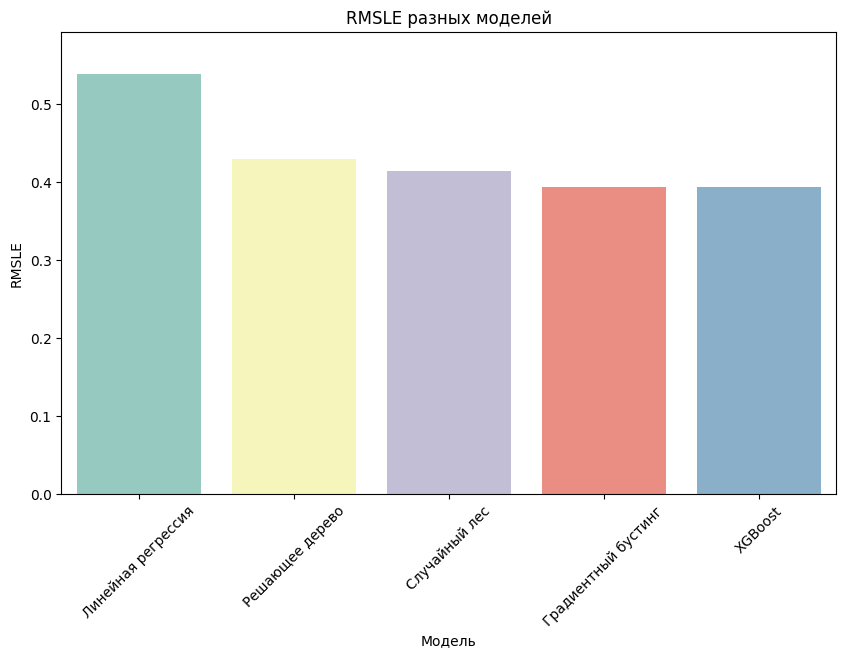

In [ ]:
# Создание DataFrame с названиями моделей и значениями RMSLE
data = {
    'Модель': ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг', 'XGBoost'],
    'RMSLE': [rmsle_valid_lr, rmsle_val_dtr, rmsle_valid_rfr, rmsle_valid_gbr, model_xgb.best_score]
}
df = pd.DataFrame(data)

# Визуализация значений RMSLE
plt.figure(figsize=(10, 6))
sns.barplot(x='Модель', y='RMSLE', data=df, hue='Модель', palette='Set3', legend=False)
plt.xlabel('Модель')
plt.ylabel('RMSLE')
plt.title('RMSLE разных моделей')
plt.xticks(rotation=45)
plt.ylim(0, max(df['RMSLE'])* 1.1)
plt.show()

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

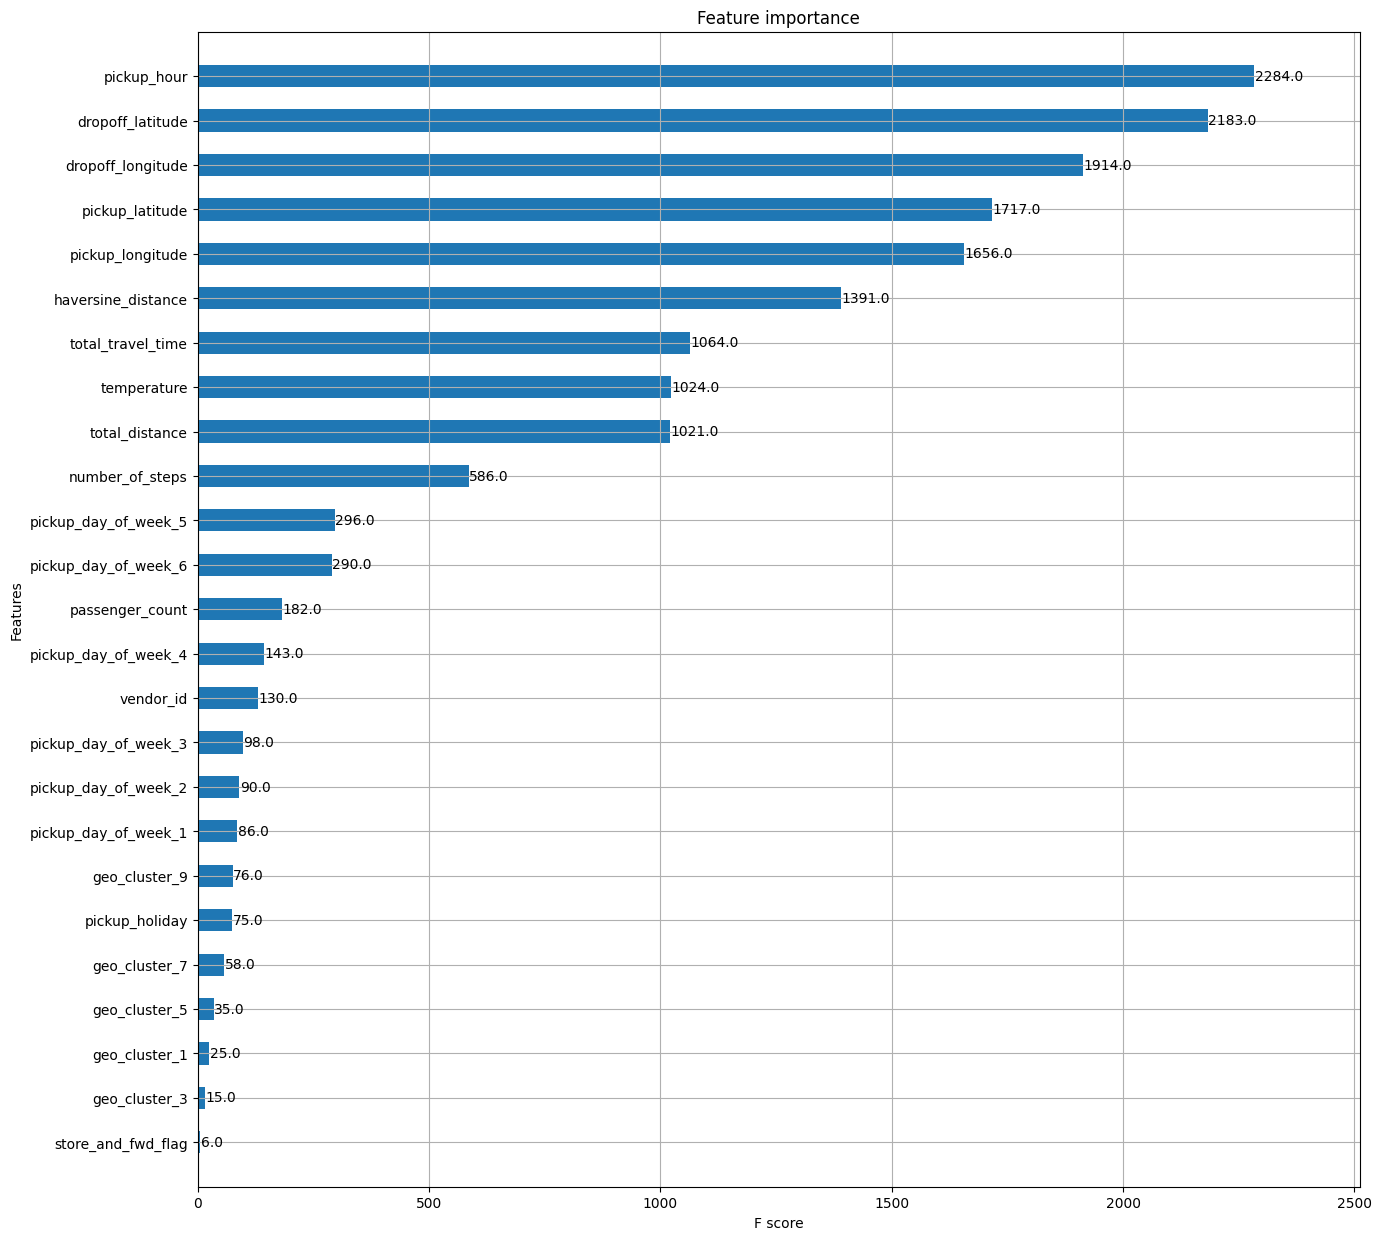

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model_xgb, ax = ax, height=0.5)

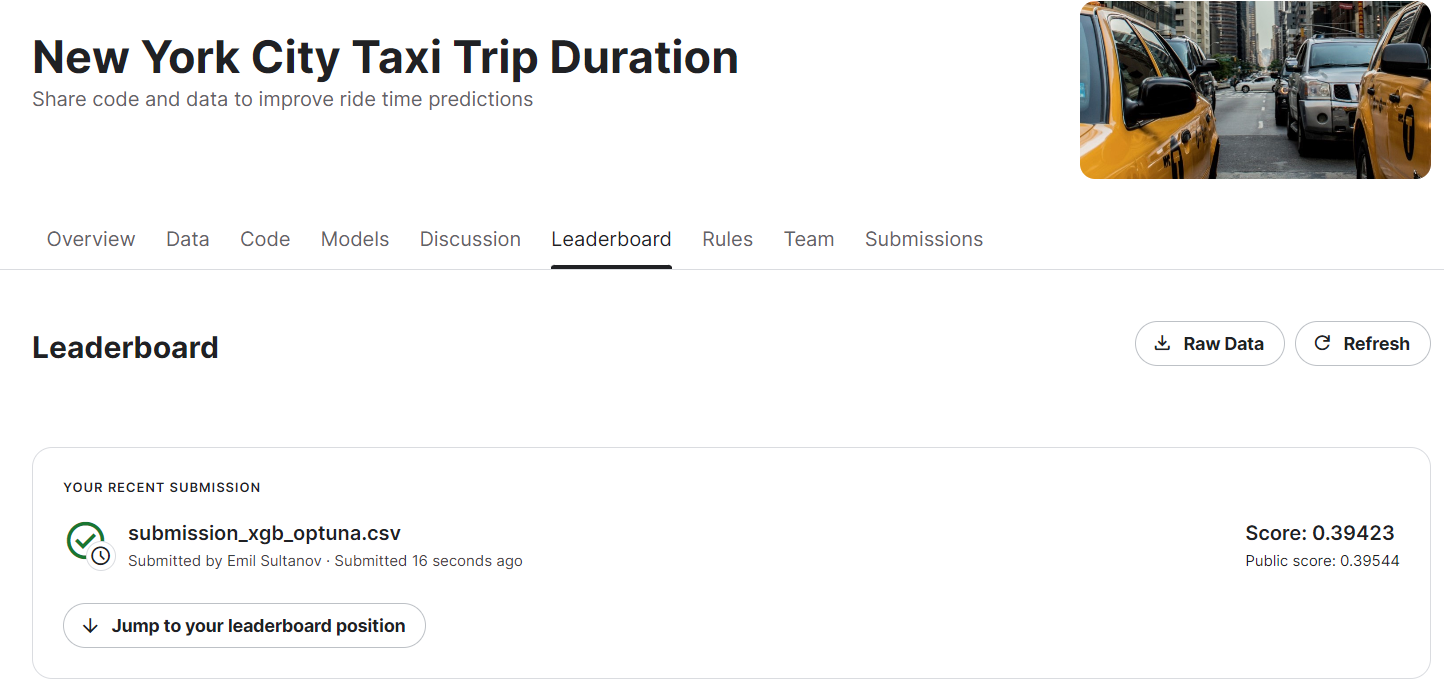

In [ ]:
# !pip freeze > /content/drive/MyDrive/ProjectPracticum2/requirements.txt